## Import Libraries

In [1]:
#import required libraries
import warnings

import pandas as pd
import numpy as np #for arrays
import matplotlib.pyplot as plt #to plot graphs
plt.style.use('ggplot')
import seaborn as sns #to plot graphs
import pyodbc #to connect to sql server

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
from sklearn.model_selection import train_test_split #to split the data into training and testing sets
from sklearn.model_selection import cross_val_score #for cross validation
import sklearn.metrics as metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix #to create a confusion matrix
from sklearn.metrics import plot_confusion_matrix #to draw a confusion matrix
from sklearn.metrics import classification_report
#from sklearn.metrics import accuracy_score
#from sklearn.metrics import recall_score
#from sklearn.metrics import precision_score
from sklearn.metrics import fbeta_score

## Import Dataset from SQL

In [3]:
#importing your dataset from sql
db = 'AdventureWorksDW2019' #databaseName
server = 'DESKTOP-RDRRI0S'  #serverName

#create the connection
conn = pyodbc.connect('DRIVER={SQL SERVER};SERVER=' + server + ';DATABASE=' + db + ';Trusted_Connection=yes')



#query 
query = """
SELECT FS.ProductKey AS ProductID,
	   FS.CustomerKey AS CustomerID,
	   FS.SalesOrderNumber AS SalesOrderID,
	   FS.SalesOrderLineNumber,
	   FS.OrderQuantity AS Quantity,
	   FS.UnitPrice,
	   FS.ProductStandardCost AS StandardCost,
	   FS.TotalProductCost AS Cost,
	   FS.SalesAmount,
	   FS.OrderDate,
	   FORMAT(FS.OrderDate,'yyyy-MM') AS Order_Date,
	   (FS.UnitPrice * FS.OrderQuantity) AS Revenue,
	   ((FS.UnitPrice * FS.OrderQuantity) - (FS.OrderQuantity * FS.ProductStandardCost)) AS Profit,
	   DP.EnglishProductName AS ProductName,
	   DSP.EnglishProductSubcategoryName AS ProductSubCategory,
	   DCP.EnglishProductCategoryName AS ProductCategory,
	   ST.SalesTerritoryRegion AS Region,
	   ST.SalesTerritoryCountry AS Country,
	   ST.SalesTerritoryGroup AS Continent_Group, 
	   DC.BirthDate,
	   DC.CommuteDistance,
	   DC.DateFirstPurchase,
	   DC.Gender,
	   DC.HouseOwnerFlag,
	   DC.MaritalStatus,
	   DC.NumberCarsOwned,
	   DC.NumberChildrenAtHome,
	   DC.TotalChildren,
	   DC.YearlyIncome,
       DC.EnglishEducation AS Education,
       DC.EnglishOccupation AS Occupation
FROM FactInternetSales AS FS
LEFT JOIN DimProduct AS DP
ON FS.ProductKey = DP.ProductKey
LEFT JOIN DimCustomer AS DC
ON FS.CustomerKey = DC.CustomerKey
LEFT JOIN DimSalesTerritory AS ST
ON FS.SalesTerritoryKey = ST.SalesTerritoryKey
LEFT JOIN DimProductSubCategory AS DSP
ON DP.ProductSubCategoryKey = DSP.ProductSubCategoryKey
LEFT JOIN DimProductCategory AS DCP
ON DSP.ProductCategoryKey = DCP.ProductCategoryKey
"""

In [4]:
#reading the sql file from the engine
df = pd.read_sql(query, conn) 

print(df)

       ProductID  CustomerID SalesOrderID  SalesOrderLineNumber  Quantity  \
0            310       21768      SO43697                     1         1   
1            346       28389      SO43698                     1         1   
2            346       25863      SO43699                     1         1   
3            336       14501      SO43700                     1         1   
4            346       11003      SO43701                     1         1   
...          ...         ...          ...                   ...       ...   
60393        485       15868      SO75122                     1         1   
60394        225       15868      SO75122                     2         1   
60395        485       18759      SO75123                     1         1   
60396        486       18759      SO75123                     2         1   
60397        225       18759      SO75123                     3         1   

       UnitPrice  StandardCost       Cost  SalesAmount  OrderDate  ...  \
0

In [5]:
df.head()

,ProductID,CustomerID,SalesOrderID,SalesOrderLineNumber,Quantity,UnitPrice,StandardCost,Cost,SalesAmount,OrderDate,...,DateFirstPurchase,Gender,HouseOwnerFlag,MaritalStatus,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,Education,Occupation
0,310,21768,SO43697,1,1,3578.2700,2171.2942,2171.2942,3578.2700,2010-12-29,...,2010-12-29,M,1,S,3,0,5,70000.0,Bachelors,Management
1,346,28389,SO43698,1,1,3399.9900,1912.1544,1912.1544,3399.9900,2010-12-29,...,2010-12-29,F,0,S,0,3,3,20000.0,High School,Manual
2,346,25863,SO43699,1,1,3399.9900,1912.1544,1912.1544,3399.9900,2010-12-29,...,2010-12-29,F,1,S,3,0,5,40000.0,High School,Professional
3,336,14501,SO43700,1,1,699.0982,413.1463,413.1463,699.0982,2010-12-29,...,2010-12-29,M,1,M,2,0,4,80000.0,Graduate Degree,Management
4,346,11003,SO43701,1,1,3399.9900,1912.1544,1912.1544,3399.9900,2010-12-29,...,2010-12-29,F,0,S,1,0,0,70000.0,Bachelors,Professional


## Data Preprocessing

In [6]:
#get info on dataset and check to see if there are any missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60398 entries, 0 to 60397
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ProductID             60398 non-null  int64         
 1   CustomerID            60398 non-null  int64         
 2   SalesOrderID          60398 non-null  object        
 3   SalesOrderLineNumber  60398 non-null  int64         
 4   Quantity              60398 non-null  int64         
 5   UnitPrice             60398 non-null  float64       
 6   StandardCost          60398 non-null  float64       
 7   Cost                  60398 non-null  float64       
 8   SalesAmount           60398 non-null  float64       
 9   OrderDate             60398 non-null  datetime64[ns]
 10  Order_Date            60398 non-null  object        
 11  Revenue               60398 non-null  float64       
 12  Profit                60398 non-null  float64       
 13  ProductName     

In [7]:
#Check to be sure there are no null values
df.isnull().sum()

ProductID               0
CustomerID              0
SalesOrderID            0
SalesOrderLineNumber    0
Quantity                0
UnitPrice               0
StandardCost            0
Cost                    0
SalesAmount             0
OrderDate               0
Order_Date              0
Revenue                 0
Profit                  0
ProductName             0
ProductSubCategory      0
ProductCategory         0
Region                  0
Country                 0
Continent_Group         0
BirthDate               0
CommuteDistance         0
DateFirstPurchase       0
Gender                  0
HouseOwnerFlag          0
MaritalStatus           0
NumberCarsOwned         0
NumberChildrenAtHome    0
TotalChildren           0
YearlyIncome            0
Education               0
Occupation              0
dtype: int64

In [8]:
df.head()

,ProductID,CustomerID,SalesOrderID,SalesOrderLineNumber,Quantity,UnitPrice,StandardCost,Cost,SalesAmount,OrderDate,...,DateFirstPurchase,Gender,HouseOwnerFlag,MaritalStatus,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,Education,Occupation
0,310,21768,SO43697,1,1,3578.2700,2171.2942,2171.2942,3578.2700,2010-12-29,...,2010-12-29,M,1,S,3,0,5,70000.0,Bachelors,Management
1,346,28389,SO43698,1,1,3399.9900,1912.1544,1912.1544,3399.9900,2010-12-29,...,2010-12-29,F,0,S,0,3,3,20000.0,High School,Manual
2,346,25863,SO43699,1,1,3399.9900,1912.1544,1912.1544,3399.9900,2010-12-29,...,2010-12-29,F,1,S,3,0,5,40000.0,High School,Professional
3,336,14501,SO43700,1,1,699.0982,413.1463,413.1463,699.0982,2010-12-29,...,2010-12-29,M,1,M,2,0,4,80000.0,Graduate Degree,Management
4,346,11003,SO43701,1,1,3399.9900,1912.1544,1912.1544,3399.9900,2010-12-29,...,2010-12-29,F,0,S,1,0,0,70000.0,Bachelors,Professional


## Exploratory Data Analysis

### Transactional Data Analysis

In [9]:
#extract those columns relevant to the transactional data
trans_data = df[["ProductID", "CustomerID","SalesOrderID", "SalesOrderLineNumber", "Quantity", "OrderDate", "Revenue", "Cost","Profit", "ProductName"]]

In [10]:
trans_data.head()

,ProductID,CustomerID,SalesOrderID,SalesOrderLineNumber,Quantity,OrderDate,Revenue,Cost,Profit,ProductName
0,310,21768,SO43697,1,1,2010-12-29,3578.2700,2171.2942,1406.9758,"Road-150 Red, 62"
1,346,28389,SO43698,1,1,2010-12-29,3399.9900,1912.1544,1487.8356,"Mountain-100 Silver, 44"
2,346,25863,SO43699,1,1,2010-12-29,3399.9900,1912.1544,1487.8356,"Mountain-100 Silver, 44"
3,336,14501,SO43700,1,1,2010-12-29,699.0982,413.1463,285.9519,"Road-650 Black, 62"
4,346,11003,SO43701,1,1,2010-12-29,3399.9900,1912.1544,1487.8356,"Mountain-100 Silver, 44"


In [11]:
trans_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60398 entries, 0 to 60397
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ProductID             60398 non-null  int64         
 1   CustomerID            60398 non-null  int64         
 2   SalesOrderID          60398 non-null  object        
 3   SalesOrderLineNumber  60398 non-null  int64         
 4   Quantity              60398 non-null  int64         
 5   OrderDate             60398 non-null  datetime64[ns]
 6   Revenue               60398 non-null  float64       
 7   Cost                  60398 non-null  float64       
 8   Profit                60398 non-null  float64       
 9   ProductName           60398 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(4), object(2)
memory usage: 4.6+ MB


In [12]:
#Convert "Quantity" data type to float
trans_data["Quantity"].astype(float)

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
60393    1.0
60394    1.0
60395    1.0
60396    1.0
60397    1.0
Name: Quantity, Length: 60398, dtype: float64

In [13]:
trans_data.head()

,ProductID,CustomerID,SalesOrderID,SalesOrderLineNumber,Quantity,OrderDate,Revenue,Cost,Profit,ProductName
0,310,21768,SO43697,1,1,2010-12-29,3578.2700,2171.2942,1406.9758,"Road-150 Red, 62"
1,346,28389,SO43698,1,1,2010-12-29,3399.9900,1912.1544,1487.8356,"Mountain-100 Silver, 44"
2,346,25863,SO43699,1,1,2010-12-29,3399.9900,1912.1544,1487.8356,"Mountain-100 Silver, 44"
3,336,14501,SO43700,1,1,2010-12-29,699.0982,413.1463,285.9519,"Road-650 Black, 62"
4,346,11003,SO43701,1,1,2010-12-29,3399.9900,1912.1544,1487.8356,"Mountain-100 Silver, 44"


In [14]:
#check for duplicate rows in the data
print("Duplicate rows:", trans_data.duplicated().sum())

Duplicate rows: 0


In [15]:
#Group and aggregate all transactions by customer_id and order date
trans_grp_data = trans_data.groupby(['CustomerID', 'SalesOrderID', 'OrderDate']).agg({'Quantity':sum,
                                                                           'Revenue':sum,
                                                                           'Profit':sum}).reset_index()

In [16]:
trans_grp_data.head()

,CustomerID,SalesOrderID,OrderDate,Quantity,Revenue,Profit
0,11000,SO43793,2011-01-19,1,3399.99,1487.8356
1,11000,SO51522,2013-01-18,2,2341.97,1068.1300
2,11000,SO57418,2013-05-03,5,2507.03,957.7249
3,11001,SO43767,2011-01-15,1,3374.99,1476.8956
4,11001,SO51493,2013-01-16,6,2419.93,1091.9928


In [17]:
#Calculate the time elapsed between transactiosn per customer
trans_grp_data["No of Days Elapsed"]=trans_grp_data.groupby("CustomerID")["OrderDate"].diff()
trans_grp_data["No of Days Elapsed"]=trans_grp_data["No of Days Elapsed"]/np.timedelta64(1,"D")
trans_grp_data.head()

,CustomerID,SalesOrderID,OrderDate,Quantity,Revenue,Profit,No of Days Elapsed
0,11000,SO43793,2011-01-19,1,3399.99,1487.8356,NaN
1,11000,SO51522,2013-01-18,2,2341.97,1068.1300,730.0
2,11000,SO57418,2013-05-03,5,2507.03,957.7249,105.0
3,11001,SO43767,2011-01-15,1,3374.99,1476.8956,NaN
4,11001,SO51493,2013-01-16,6,2419.93,1091.9928,732.0


In [18]:
#Aggregate the data per customer, to have a single customer view
aggregate = ["sum", "mean", "median", "min", "max"]
agg_trans_by_customer = trans_grp_data.groupby("CustomerID").aggregate({"Quantity":aggregate, "Profit":aggregate,"Revenue":aggregate,"No of Days Elapsed":aggregate}).reset_index()
agg_trans_by_customer.head()

CustomerID Quantity                              Profit               \
                  sum      mean median min max        sum         mean   
0      11000        8  2.666667    2.0   1   5  3513.6905  1171.230167   
1      11001       11  3.666667    4.0   1   6  2795.8839   931.961300   
2      11002        4  1.333333    1.0   1   2  3454.8801  1151.626700   
3      11003        9  3.000000    4.0   1   4  3467.1264  1155.708800   
4      11004        6  2.000000    2.0   1   3  3501.9051  1167.301700   

                        ...  Revenue                                          \
      median       min  ...      sum         mean   median      min      max   
0  1068.1300  957.7249  ...  8248.99  2749.663333  2507.03  2341.97  3399.99   
1  1091.9928  226.9955  ...  6383.88  2127.960000  2419.93   588.96  3374.99   
2  1043.0087  924.0358  ...  8114.04  2704.680000  2419.06  2294.99  3399.99   
3  1054.4538  924.8370  ...  8139.29  2713.096667  2420.34  2318.96  3399.99   
4  1090.0337  924.0358  ...  8196.01  2732.003333  2419.06  2376.96  3399.99   

  No of Days Elapsed                              
                 sum   mean median    min    max  
0              835.0  417.5  417.5  105.0  730.0  
1             1060.0  530.0  530.0  328.0  732.0  
2              778.0  389.0  389.0   54.0  724.0  
3              863.0  431.5  431.5  125.0  738.0  
4              829.0  414.5  414.5   99.0  730.0  

[5 rows x 21 columns]

In [19]:
#Flatten all columns except for CustomerID
trans_ =agg_trans_by_customer.drop("CustomerID", axis=1)

# Flatten all the columns
trans_.columns=['_'.join(trans_).rstrip('_') for trans_ in trans_.columns.values]
trans_.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,Quantity_sum,Quantity_mean,Quantity_median,Quantity_min,Quantity_max,Profit_sum,Profit_mean,Profit_median,Profit_min,Profit_max,Revenue_sum,Revenue_mean,Revenue_median,Revenue_min,Revenue_max,No of Days Elapsed_sum,No of Days Elapsed_mean,No of Days Elapsed_median,No of Days Elapsed_min,No of Days Elapsed_max
0,8,2.666667,2.0,1,5,3513.6905,1171.230167,1068.1300,957.7249,1487.8356,8248.99,2749.663333,2507.03,2341.97,3399.99,835.0,417.5,417.5,105.0,730.0
1,11,3.666667,4.0,1,6,2795.8839,931.961300,1091.9928,226.9955,1476.8956,6383.88,2127.960000,2419.93,588.96,3374.99,1060.0,530.0,530.0,328.0,732.0
2,4,1.333333,1.0,1,2,3454.8801,1151.626700,1043.0087,924.0358,1487.8356,8114.04,2704.680000,2419.06,2294.99,3399.99,778.0,389.0,389.0,54.0,724.0
3,9,3.000000,4.0,1,4,3467.1264,1155.708800,1054.4538,924.8370,1487.8356,8139.29,2713.096667,2420.34,2318.96,3399.99,863.0,431.5,431.5,125.0,738.0
4,6,2.000000,2.0,1,3,3501.9051,1167.301700,1090.0337,924.0358,1487.8356,8196.01,2732.003333,2419.06,2376.96,3399.99,829.0,414.5,414.5,99.0,730.0


In [20]:
#Bring back the CustomerID column
trans_.insert(0, "CustomerID", agg_trans_by_customer["CustomerID"])

In [21]:
trans_.head()

,CustomerID,Quantity_sum,Quantity_mean,Quantity_median,Quantity_min,Quantity_max,Profit_sum,Profit_mean,Profit_median,Profit_min,...,Revenue_sum,Revenue_mean,Revenue_median,Revenue_min,Revenue_max,No of Days Elapsed_sum,No of Days Elapsed_mean,No of Days Elapsed_median,No of Days Elapsed_min,No of Days Elapsed_max
0,11000,8,2.666667,2.0,1,5,3513.6905,1171.230167,1068.1300,957.7249,...,8248.99,2749.663333,2507.03,2341.97,3399.99,835.0,417.5,417.5,105.0,730.0
1,11001,11,3.666667,4.0,1,6,2795.8839,931.961300,1091.9928,226.9955,...,6383.88,2127.960000,2419.93,588.96,3374.99,1060.0,530.0,530.0,328.0,732.0
2,11002,4,1.333333,1.0,1,2,3454.8801,1151.626700,1043.0087,924.0358,...,8114.04,2704.680000,2419.06,2294.99,3399.99,778.0,389.0,389.0,54.0,724.0
3,11003,9,3.000000,4.0,1,4,3467.1264,1155.708800,1054.4538,924.8370,...,8139.29,2713.096667,2420.34,2318.96,3399.99,863.0,431.5,431.5,125.0,738.0
4,11004,6,2.000000,2.0,1,3,3501.9051,1167.301700,1090.0337,924.0358,...,8196.01,2732.003333,2419.06,2376.96,3399.99,829.0,414.5,414.5,99.0,730.0


### Behavorial Data Analysis

In [22]:
#To carry out RFM Analysis we would need CustomerID to uniquely identify each customer, Date to check for Recency, CustomerId and OrderDate to calculate how the number of times a customer bought(Frequency) and Revenue to calculate Monetary Value of each customer
rfm_data = trans_grp_data[["CustomerID", "OrderDate", "SalesOrderID", "Revenue"]]
rfm_data.head()

,CustomerID,OrderDate,SalesOrderID,Revenue
0,11000,2011-01-19,SO43793,3399.99
1,11000,2013-01-18,SO51522,2341.97
2,11000,2013-05-03,SO57418,2507.03
3,11001,2011-01-15,SO43767,3374.99
4,11001,2013-01-16,SO51493,2419.93


In [23]:
#Retrieve the date for the first transaction and the last transaction respectively
rfm_data["OrderDate"].min(), rfm_data["OrderDate"].max()

(Timestamp('2010-12-29 00:00:00'), Timestamp('2014-01-28 00:00:00'))

In [24]:
#To calculate Recency, we use the last order date from the dataset t calculate
import datetime as dt
TODAY = dt.datetime(2014,1,28)
rfm_data["OrderDate"] = pd.to_datetime(rfm_data["OrderDate"])

<ipython-input-24-320ace4aa0db>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_data["OrderDate"] = pd.to_datetime(rfm_data["OrderDate"])


In [25]:
rfmTable = rfm_data.groupby('CustomerID').agg({"OrderDate": lambda x: (TODAY - x.max()).days, "SalesOrderID": lambda x: len(x), "Revenue": lambda x: x.sum()})
rfmTable["OrderDate"] = rfmTable["OrderDate"].astype(int)
rfmTable.rename(columns={"OrderDate": "recency(days)", 
                         "SalesOrderID": "frequency", 
                         "Revenue": "monetary_value"}, inplace=True)

In [26]:
rfmTable.head()

,recency(days),frequency,monetary_value
CustomerID,,,
11000,270,3,8248.99
11001,49,3,6383.88
11002,339,3,8114.04
11003,263,3,8139.29
11004,272,3,8196.01


In [27]:
rfmTable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18484 entries, 11000 to 29483
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recency(days)   18484 non-null  int32  
 1   frequency       18484 non-null  int64  
 2   monetary_value  18484 non-null  float64
dtypes: float64(1), int32(1), int64(1)
memory usage: 505.4 KB


In [28]:
rfmTable["frequency"] = rfmTable["frequency"].astype(float)

In [29]:
rfmTable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18484 entries, 11000 to 29483
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recency(days)   18484 non-null  int32  
 1   frequency       18484 non-null  float64
 2   monetary_value  18484 non-null  float64
dtypes: float64(2), int32(1)
memory usage: 505.4 KB


In [30]:
#Split the rfm metrics into segments using quantiles
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
quantiles

{'recency(days)': {0.25: 86.0, 0.5: 168.0, 0.75: 263.0},
 'frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 2.0},
 'monetary_value': {0.25: 49.97, 0.5: 270.26500000000004, 0.75: 2511.275}}

In [31]:
#The lowest recency, highest frequency and monetary amounts are our best customers.

In [32]:
# Create score form 1 to 4 with 1 being the best and 4 the worst

#Create scores for Recency,
#Values in the first percentile are the best scores (1),
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

#create scores for Frequency and Monetary,
#values in the first percentile are the best scores (4),
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [33]:
#Add segment numbers to the newly created segmented RFM table
rfmTable['R'] = rfmTable['recency(days)'].apply(RScore, args=('recency(days)', quantiles))
rfmTable['F'] = rfmTable['frequency'].apply(FMScore, args=('frequency', quantiles))
rfmTable['M'] = rfmTable['monetary_value'].apply(FMScore, args=('monetary_value', quantiles))
rfmTable.head()

,recency(days),frequency,monetary_value,R,F,M
CustomerID,,,,,,
11000,270,3.0,8248.99,4,1,1
11001,49,3.0,6383.88,1,1,1
11002,339,3.0,8114.04,4,1,1
11003,263,3.0,8139.29,3,1,1
11004,272,3.0,8196.01,4,1,1


In [34]:
#RFM segments split the customer base into an imaginary 3D cube which is hard to visualize. However, we can sort it out.

#Add a new column to combine RFM score: 111 is the highest score.

In [35]:
rfmTable['RFMScore'] = rfmTable.R.map(str)  + rfmTable.F.map(str)  + rfmTable.M.map(str)
rfmTable['RFM_score_total'] = rfmTable[['R', 'F', 'M']].sum(axis = 1)
rfmTable.head()

,recency(days),frequency,monetary_value,R,F,M,RFMScore,RFM_score_total
CustomerID,,,,,,,,
11000,270,3.0,8248.99,4,1,1,411,6
11001,49,3.0,6383.88,1,1,1,111,3
11002,339,3.0,8114.04,4,1,1,411,6
11003,263,3.0,8139.29,3,1,1,311,5
11004,272,3.0,8196.01,4,1,1,411,6


In [36]:
#Assign labels from RFM total score
#score_labels = ['Diamond', 'Gold', 'Silver', 'Platinum']
#score_groups = pd.qcut(rfmTable.RFM_score_total, q = 4, labels = score_labels)
#rfmTable['RFM_stat_label'] = score_groups.values
#rfmTable.head()

In [37]:
#Get insight into the labels/quartiles
quantiles = rfmTable['RFM_score_total'].quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
quantiles

{0.25: 6.0, 0.5: 9.0, 0.75: 10.0}

In [38]:
#Retrieve the % of the most valuable customers (Those 111 segment)
#print("share of 111 segment:{:.2f}%".format(len(rfmTable[rfmTable["RFMScore"]=="111"])/len(rfmTable)*100))

In [39]:
#Retrieve the % of the least valuable customers (Those 411 segment)
#print("share of 411 segment:{:.2f}%".format(len(rfmTable[rfmTable["RFMScore"]=="411"])/len(rfmTable)*100))

In [40]:
#Retrieve the % of the most valuable customers (Those Diamond segment)
#print("share of Diamond status:{:.2f}%".format(len(rfmTable[rfmTable["RFM_stat_label"]=="Diamond"])/len(rfmTable)*100))

In [41]:
#Drop all columns that are no longer necessary
columns = ['R', 'F', 'M']
rfmTable.drop(columns, axis=1, inplace = True)
rfmTable = rfmTable.reset_index()
rfmTable.head()

,CustomerID,recency(days),frequency,monetary_value,RFMScore,RFM_score_total
0,11000,270,3.0,8248.99,411,6
1,11001,49,3.0,6383.88,111,3
2,11002,339,3.0,8114.04,411,6
3,11003,263,3.0,8139.29,311,5
4,11004,272,3.0,8196.01,411,6


## K-Means Clustering

In [42]:
#mport required libraries
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [43]:
#Select variables
df_rfm = rfmTable[["recency(days)","frequency","monetary_value"]]

In [44]:
df_rfm.head()

,recency(days),frequency,monetary_value
0,270,3.0,8248.99
1,49,3.0,6383.88
2,339,3.0,8114.04
3,263,3.0,8139.29
4,272,3.0,8196.01


In [45]:
# Function to check skewness, that is to check if the RFM data is normally distributed
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

recency(days)'s: Skew: 2.459386289365062, : SkewtestResult(statistic=82.6404410779602, pvalue=0.0)
frequency's: Skew: 12.578673101554138, : SkewtestResult(statistic=155.52463827278137, pvalue=0.0)
monetary_value's: Skew: 1.4102138305987435, : SkewtestResult(statistic=59.60813625802598, pvalue=0.0)


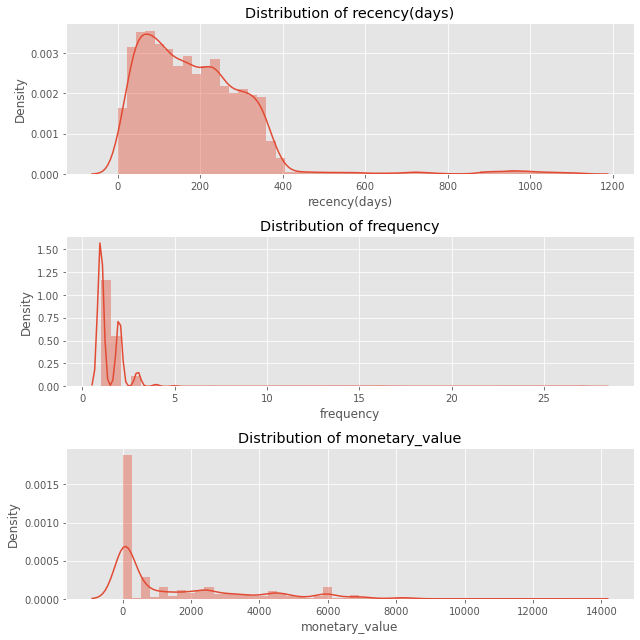

In [46]:
#Plot all 3 graphs together for summary findings
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(rfmTable,'recency(days)')

plt.subplot(3, 1, 2)
check_skew(rfmTable,'frequency')

plt.subplot(3, 1, 3)
check_skew(rfmTable,'monetary_value')

plt.tight_layout()

#### The data is highly skewed,we will need to perform log transformations to reduce the skewness of each variable.

recency(days)'s: Skew: -1.2998281350916792, : SkewtestResult(statistic=-56.44253352487625, pvalue=0.0)
frequency's: Skew: 1.937356946561303, : SkewtestResult(statistic=72.50860032104784, pvalue=0.0)
monetary_value's: Skew: -0.09063600107487962, : SkewtestResult(statistic=-5.022411105648295, pvalue=5.102681628802736e-07)


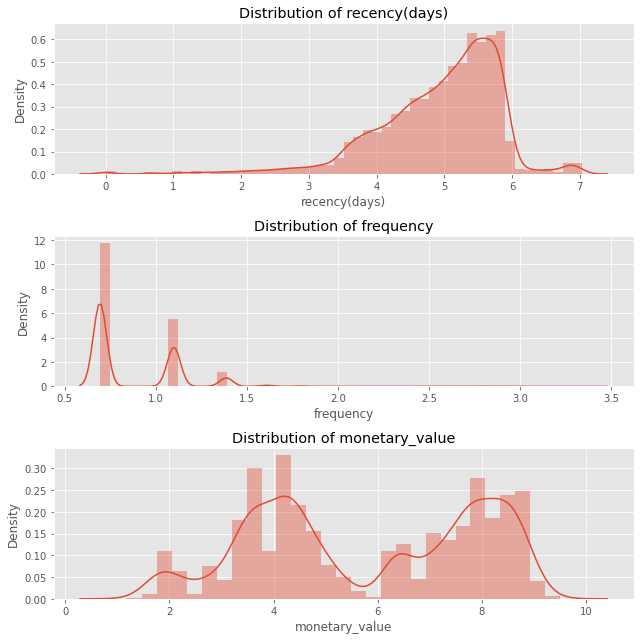

In [47]:
df_rfm = np.log(df_rfm+1)

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_rfm,'recency(days)')

plt.subplot(3, 1, 2)
check_skew(df_rfm,'frequency')
plt.subplot(3, 1, 3)
check_skew(df_rfm,'monetary_value')

plt.tight_layout()

In [48]:
#pip install --user feature_engine

In [49]:
#%pip install --user -U numpy

In [50]:
#pip show numpy

In [51]:
import feature_engine
from feature_engine.outliers import Winsorizer

windsoriser = Winsorizer(tail='both', # cap left, right or both tails 
                          fold=2,
                           variables=[ 'recency(days)', 'frequency', 'monetary_value']
                        )
windsoriser.fit(df_rfm)

Winsorizer(fold=2, tail='both',
           variables=['recency(days)', 'frequency', 'monetary_value'])

In [52]:
df_rfm = windsoriser.transform(df_rfm)

#### Once the skewness is reduced, standardise the data by centring and scaling. 
#### Note all the variables now have a mean of 0 and a standard deviation of 1.

In [53]:
scaler = StandardScaler()

scaler.fit(df_rfm)

RFM_Table_scaled = scaler.transform(df_rfm)

In [54]:
RFM_Table_scaled = pd.DataFrame(RFM_Table_scaled, columns=df_rfm.columns)
RFM_Table_scaled.head()

,recency(days),frequency,monetary_value
0,0.797716,2.208673,1.496591
1,-1.341720,2.208673,1.377730
2,1.084848,2.208673,1.488942
3,0.764588,2.208673,1.490383
4,0.807024,2.208673,1.493603


In [55]:
#%pip install --user -U threadpoolctl

#### Finding the optimal number of clusters

In [56]:
from scipy.spatial.distance import cdist
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(RFM_Table_scaled) 
    kmeanModel.fit(RFM_Table_scaled)     
      
    distortions.append(sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / RFM_Table_scaled.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / RFM_Table_scaled.shape[0] 
    mapping2[k] = kmeanModel.inertia_

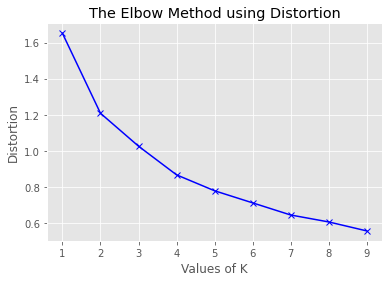

In [57]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

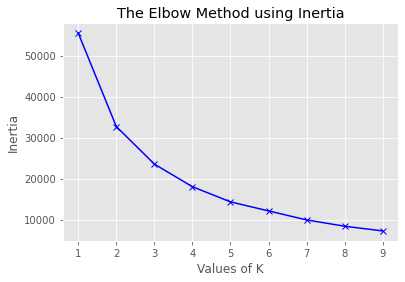

In [58]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

#### The cluster value where this decrease in inertia value becomes constant can be chosen as the right cluster value for our data. 
#### Looking at the above elbow curve, we can choose any number of clusters between 4 to 7.

In [59]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)
    
    #Assign the clusters to the rfm dataframe
    rfmTable["RFM_Cluster"] = kmeans.labels_

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

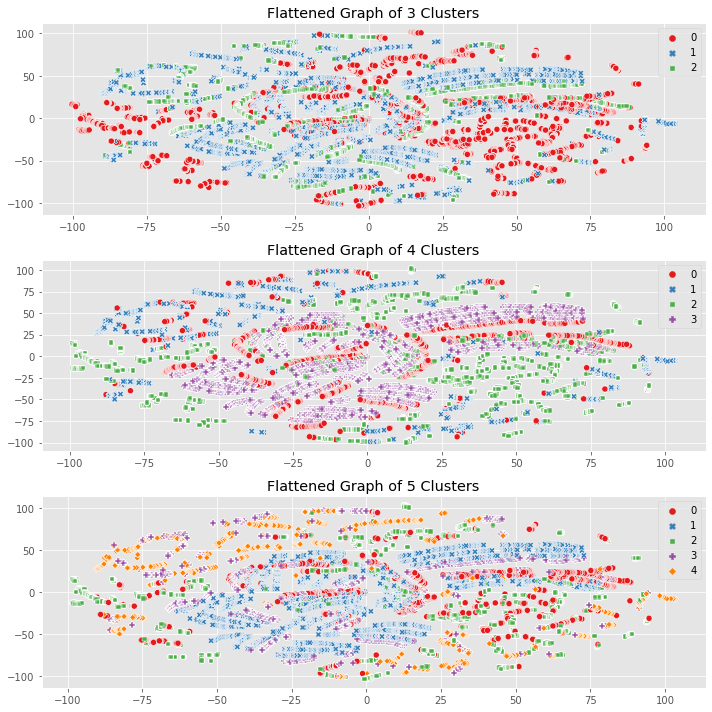

In [60]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(RFM_Table_scaled, 3, rfmTable)

plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(RFM_Table_scaled, 4, rfmTable)

plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(RFM_Table_scaled, 5, rfmTable)

plt.tight_layout()

In [61]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):

    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=rfmTable.index, 
                                       columns=rfmTable.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['recency(days)', 'frequency', 'monetary_value'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

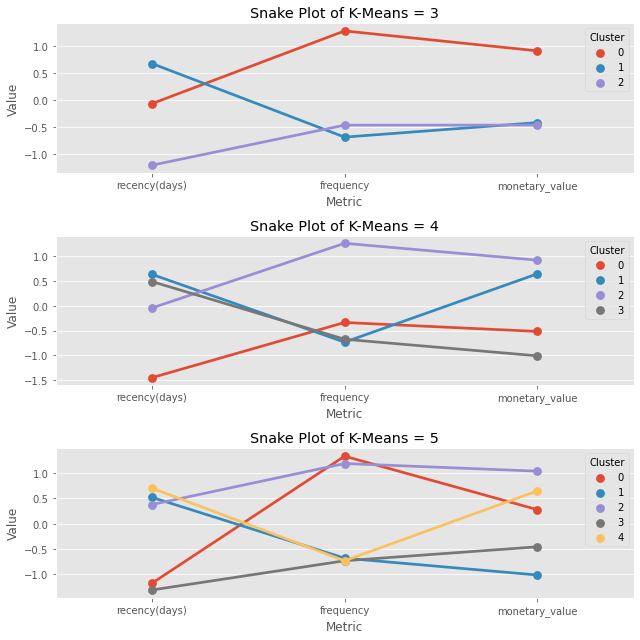

In [62]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 3')
snake_plot(RFM_Table_scaled, df_rfm_k3, rfmTable)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(RFM_Table_scaled, df_rfm_k4, rfmTable)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(RFM_Table_scaled, df_rfm_k5, rfmTable)

plt.tight_layout()

#### Interpretation of the clusters formed using k-means

In [63]:
def rfm_values(df):

    df_new = df.groupby(['Cluster']).agg({
        'recency(days)': 'mean',
        'frequency': 'mean',
        'monetary_value': ['mean', 'count']
    }).round(0)
    
    return df_new

In [64]:
rfm_values(df_rfm_k4)

recency(days) frequency monetary_value      
                 mean      mean           mean count
Cluster                                             
0                48.0       1.0          378.0  3298
1               302.0       1.0         1589.0  3335
2               168.0       2.0         3787.0  5948
3               227.0       1.0           49.0  5903

In [65]:
# join rfm with transactional table to get a single view
single_view = pd.merge(trans_, rfmTable, on=["CustomerID"])
single_view.head()

,CustomerID,Quantity_sum,Quantity_mean,Quantity_median,Quantity_min,Quantity_max,Profit_sum,Profit_mean,Profit_median,Profit_min,...,No of Days Elapsed_mean,No of Days Elapsed_median,No of Days Elapsed_min,No of Days Elapsed_max,recency(days),frequency,monetary_value,RFMScore,RFM_score_total,RFM_Cluster
0,11000,8,2.666667,2.0,1,5,3513.6905,1171.230167,1068.1300,957.7249,...,417.5,417.5,105.0,730.0,270,3.0,8248.99,411,6,2
1,11001,11,3.666667,4.0,1,6,2795.8839,931.961300,1091.9928,226.9955,...,530.0,530.0,328.0,732.0,49,3.0,6383.88,111,3,0
2,11002,4,1.333333,1.0,1,2,3454.8801,1151.626700,1043.0087,924.0358,...,389.0,389.0,54.0,724.0,339,3.0,8114.04,411,6,2
3,11003,9,3.000000,4.0,1,4,3467.1264,1155.708800,1054.4538,924.8370,...,431.5,431.5,125.0,738.0,263,3.0,8139.29,311,5,2
4,11004,6,2.000000,2.0,1,3,3501.9051,1167.301700,1090.0337,924.0358,...,414.5,414.5,99.0,730.0,272,3.0,8196.01,411,6,2


### What does each cluster represent?

##### The first cluster belongs to the "Best Customers" segment which we saw earlier as they purchase recently (R=1), frequent buyers (F=1), and spent the most (M=1).
##### Customers in the second cluster can be interpreted as passerby customers as their last purchase is long ago (R=4),purchased very few (F=4) and spent little (M=4).Company has to come up with new strategies to make them permanent members.
##### The third cluster is more related to the "Almost Lost" segment as they Haven’t purchased for some time(R=3), but used to purchase frequently and spent a lot.
##### The last cluster are very Loyal Customers and they also spent a lot.

### Defining Churn

In [66]:
#Sales Data
trans_data.head()

,ProductID,CustomerID,SalesOrderID,SalesOrderLineNumber,Quantity,OrderDate,Revenue,Cost,Profit,ProductName
0,310,21768,SO43697,1,1,2010-12-29,3578.2700,2171.2942,1406.9758,"Road-150 Red, 62"
1,346,28389,SO43698,1,1,2010-12-29,3399.9900,1912.1544,1487.8356,"Mountain-100 Silver, 44"
2,346,25863,SO43699,1,1,2010-12-29,3399.9900,1912.1544,1487.8356,"Mountain-100 Silver, 44"
3,336,14501,SO43700,1,1,2010-12-29,699.0982,413.1463,285.9519,"Road-650 Black, 62"
4,346,11003,SO43701,1,1,2010-12-29,3399.9900,1912.1544,1487.8356,"Mountain-100 Silver, 44"


In [67]:
trans_data.columns

Index(['ProductID', 'CustomerID', 'SalesOrderID', 'SalesOrderLineNumber',
       'Quantity', 'OrderDate', 'Revenue', 'Cost', 'Profit', 'ProductName'],
      dtype='object')

In [68]:
#Get relevant data to define tenure
tenure = trans_data[["CustomerID","OrderDate"]]
tenure.head()

,CustomerID,OrderDate
0,21768,2010-12-29
1,28389,2010-12-29
2,25863,2010-12-29
3,14501,2010-12-29
4,11003,2010-12-29


In [69]:
#Aggregate the data by grouping CustomerID
tenure_ = tenure.groupby("CustomerID").agg({"OrderDate":["min","max"]})
tenure_.head()

OrderDate           
                  min        max
CustomerID                      
11000      2011-01-19 2013-05-03
11001      2011-01-15 2013-12-10
11002      2011-01-07 2013-02-23
11003      2010-12-29 2013-05-10
11004      2011-01-23 2013-05-01

In [70]:
#Flatten all the columns
tenure_.columns=['_'.join(tenure_).rstrip('_') for tenure_ in tenure_.columns.values]
tenure_.head()

,OrderDate_min,OrderDate_max
CustomerID,,
11000,2011-01-19,2013-05-03
11001,2011-01-15,2013-12-10
11002,2011-01-07,2013-02-23
11003,2010-12-29,2013-05-10
11004,2011-01-23,2013-05-01


In [71]:
# Calculate Tenure - this tells us how long each customer has been customers to the company.
tenure_["Tenure_month"]=tenure_["OrderDate_max"]-tenure_["OrderDate_min"]
tenure_["Tenure_month"]=tenure_["Tenure_month"]/np.timedelta64(1,"M")
tenure_.head()

,OrderDate_min,OrderDate_max,Tenure_month
CustomerID,,,
11000,2011-01-19,2013-05-03,27.433828
11001,2011-01-15,2013-12-10,34.826177
11002,2011-01-07,2013-02-23,25.561100
11003,2010-12-29,2013-05-10,28.353765
11004,2011-01-23,2013-05-01,27.236699


In [72]:
# Determine/create the target varibale (Churn or no churn)
# Determine elapsed time threshold for churning.
tenure_["Tenure_month"].describe()

count    18484.000000
mean         5.171685
std          8.513386
min          0.000000
25%          0.000000
50%          0.000000
75%          8.903674
max         35.778969
Name: Tenure_month, dtype: float64

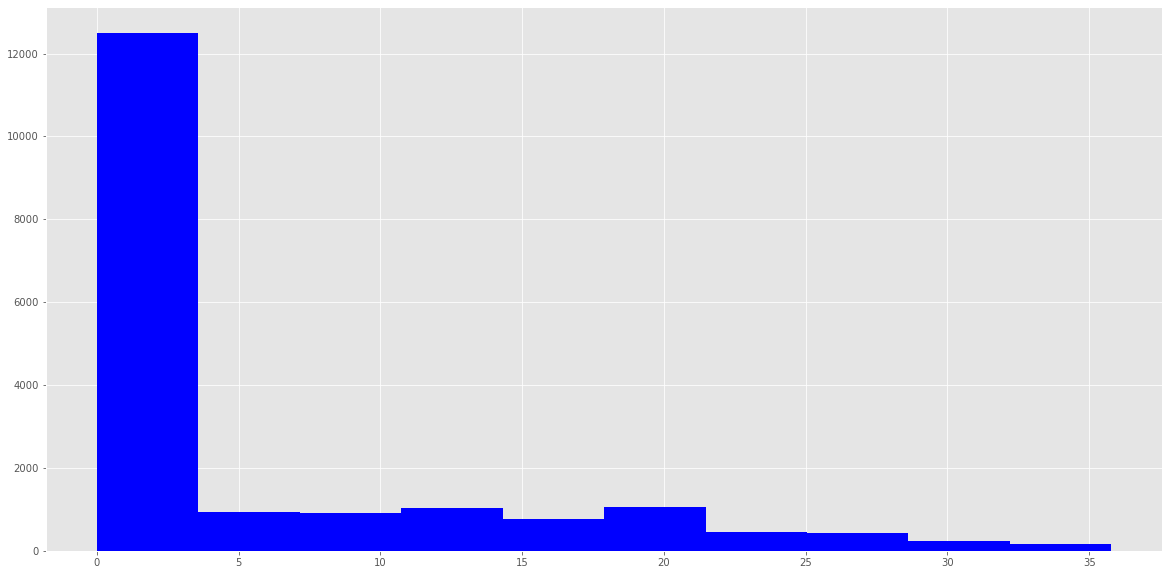

In [73]:
tenure_["Tenure_month"].hist(figsize=(20, 10), color="blue")
pass

In [74]:
# Add recency to table
tenure_["recency"]=(max(tenure["OrderDate"])-tenure_["OrderDate_max"])/(np.timedelta64(1,"D"))
tenure_.head()

,OrderDate_min,OrderDate_max,Tenure_month,recency
CustomerID,,,,
11000,2011-01-19,2013-05-03,27.433828,270.0
11001,2011-01-15,2013-12-10,34.826177,49.0
11002,2011-01-07,2013-02-23,25.561100,339.0
11003,2010-12-29,2013-05-10,28.353765,263.0
11004,2011-01-23,2013-05-01,27.236699,272.0


In [75]:
# Define days to elapse for potential churning (8 months)

#That is, where recency is equal to or greater than 240 days customer has churned

churn_days=240
def churn(x):
    if x >= churn_days:
        return 1
    else:
        return 0
    
#Apply the function to churn column
tenure_["churn"]=[churn(x) for x in tenure_.recency]

In [76]:
tenure_.head()

,OrderDate_min,OrderDate_max,Tenure_month,recency,churn
CustomerID,,,,,
11000,2011-01-19,2013-05-03,27.433828,270.0,1
11001,2011-01-15,2013-12-10,34.826177,49.0,0
11002,2011-01-07,2013-02-23,25.561100,339.0,1
11003,2010-12-29,2013-05-10,28.353765,263.0,1
11004,2011-01-23,2013-05-01,27.236699,272.0,1


In [77]:
tenure_=tenure_.drop(tenure_[["OrderDate_min", "OrderDate_max", "recency"]], axis=1)

In [78]:
tenure_.head()

,Tenure_month,churn
CustomerID,,
11000,27.433828,1
11001,34.826177,0
11002,25.561100,1
11003,28.353765,1
11004,27.236699,1


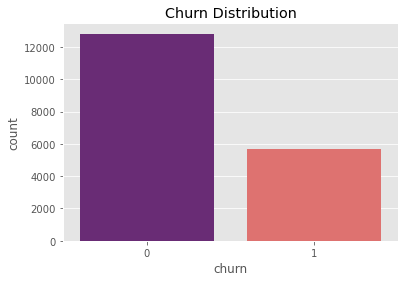

In [79]:
#plot chart showing churners and non-churners
sns.countplot(x = 'churn',  data =tenure_, palette = 'magma')
plt.title('Churn Distribution')
plt.show()

In [80]:
# join tenure with transaction and rfm table. Transaction and rfm table have already been 
# joined as single_view.

single_view = pd.merge(single_view, tenure_, on=["CustomerID"]) 
single_view.head()

,CustomerID,Quantity_sum,Quantity_mean,Quantity_median,Quantity_min,Quantity_max,Profit_sum,Profit_mean,Profit_median,Profit_min,...,No of Days Elapsed_min,No of Days Elapsed_max,recency(days),frequency,monetary_value,RFMScore,RFM_score_total,RFM_Cluster,Tenure_month,churn
0,11000,8,2.666667,2.0,1,5,3513.6905,1171.230167,1068.1300,957.7249,...,105.0,730.0,270,3.0,8248.99,411,6,2,27.433828,1
1,11001,11,3.666667,4.0,1,6,2795.8839,931.961300,1091.9928,226.9955,...,328.0,732.0,49,3.0,6383.88,111,3,0,34.826177,0
2,11002,4,1.333333,1.0,1,2,3454.8801,1151.626700,1043.0087,924.0358,...,54.0,724.0,339,3.0,8114.04,411,6,2,25.561100,1
3,11003,9,3.000000,4.0,1,4,3467.1264,1155.708800,1054.4538,924.8370,...,125.0,738.0,263,3.0,8139.29,311,5,2,28.353765,1
4,11004,6,2.000000,2.0,1,3,3501.9051,1167.301700,1090.0337,924.0358,...,99.0,730.0,272,3.0,8196.01,411,6,2,27.236699,1


### Demographic Analysis

In [81]:
#importing your dataset from sql
db = 'AdventureWorksDW2019' #databaseName
server = 'DESKTOP-RDRRI0S'  #serverName

#create the connection
conn = pyodbc.connect('DRIVER={SQL SERVER};SERVER=' + server + ';DATABASE=' + db + ';Trusted_Connection=yes')

In [82]:
#query 
query = """
SELECT CustomerKey AS CustomerID,
       BirthDate,
       CommuteDistance,
       DateFirstPurchase,
       Gender,
       HouseOwnerFlag,
       MaritalStatus,
       NumberCarsOwned,
       NumberChildrenAtHome,
       TotalChildren,
       YearlyIncome,
       EnglishEducation AS Education,
       EnglishOccupation AS Occupation
FROM dbo.DimCustomer
"""

In [83]:
#reading the sql file from the engine
demo_data = pd.read_sql(query, conn) 

print(demo_data)

       CustomerID   BirthDate CommuteDistance DateFirstPurchase Gender  \
0           11000  1971-10-06       1-2 Miles        2011-01-19      M   
1           11001  1976-05-10       0-1 Miles        2011-01-15      M   
2           11002  1971-02-09       2-5 Miles        2011-01-07      M   
3           11003  1973-08-14      5-10 Miles        2010-12-29      F   
4           11004  1979-08-05       1-2 Miles        2011-01-23      F   
...           ...         ...             ...               ...    ...   
18479       29479  1969-06-30       0-1 Miles        2012-09-04      M   
18480       29480  1977-05-06       0-1 Miles        2013-07-17      F   
18481       29481  1965-07-04       0-1 Miles        2011-08-13      M   
18482       29482  1964-09-01       0-1 Miles        2012-09-18      M   
18483       29483  1965-06-06       0-1 Miles        2012-09-09      M   

      HouseOwnerFlag MaritalStatus  NumberCarsOwned  NumberChildrenAtHome  \
0                  1             M

In [84]:
demo_data.head()

,CustomerID,BirthDate,CommuteDistance,DateFirstPurchase,Gender,HouseOwnerFlag,MaritalStatus,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,Education,Occupation
0,11000,1971-10-06,1-2 Miles,2011-01-19,M,1,M,0,0,2,90000.0,Bachelors,Professional
1,11001,1976-05-10,0-1 Miles,2011-01-15,M,0,S,1,3,3,60000.0,Bachelors,Professional
2,11002,1971-02-09,2-5 Miles,2011-01-07,M,1,M,1,3,3,60000.0,Bachelors,Professional
3,11003,1973-08-14,5-10 Miles,2010-12-29,F,0,S,1,0,0,70000.0,Bachelors,Professional
4,11004,1979-08-05,1-2 Miles,2011-01-23,F,1,S,4,5,5,80000.0,Bachelors,Professional


In [85]:
demo_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CustomerID            18484 non-null  int64  
 1   BirthDate             18484 non-null  object 
 2   CommuteDistance       18484 non-null  object 
 3   DateFirstPurchase     18484 non-null  object 
 4   Gender                18484 non-null  object 
 5   HouseOwnerFlag        18484 non-null  object 
 6   MaritalStatus         18484 non-null  object 
 7   NumberCarsOwned       18484 non-null  int64  
 8   NumberChildrenAtHome  18484 non-null  int64  
 9   TotalChildren         18484 non-null  int64  
 10  YearlyIncome          18484 non-null  float64
 11  Education             18484 non-null  object 
 12  Occupation            18484 non-null  object 
dtypes: float64(1), int64(4), object(8)
memory usage: 1.8+ MB


In [86]:
#Check for duplicates
demo_data.duplicated().sum()

0

In [87]:
demo_data.describe()

,CustomerID,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome
count,18484.000000,18484.000000,18484.000000,18484.000000,18484.000000
mean,20241.500000,1.502705,1.004058,1.844352,57305.777970
std,5336.015523,1.138394,1.522660,1.612408,32285.841703
min,11000.000000,0.000000,0.000000,0.000000,10000.000000
25%,15620.750000,1.000000,0.000000,0.000000,30000.000000
50%,20241.500000,2.000000,0.000000,2.000000,60000.000000
75%,24862.250000,2.000000,2.000000,3.000000,70000.000000
max,29483.000000,4.000000,5.000000,5.000000,170000.000000


In [88]:
# Calculate Age from Birth Date
def Age(birth_date):
    '''
Calculate days btw birthdate and date of the last transaction available.
    '''
    return TODAY - birth_date

# Convert Birth Date into datetime
demo_data["BirthDate"] = pd.to_datetime(demo_data["BirthDate"])

# Apply Age function and convert days to years
demo_data["Age"] = demo_data["BirthDate"].apply(Age)/np.timedelta64(1, "Y")
demo_data.head()

,CustomerID,BirthDate,CommuteDistance,DateFirstPurchase,Gender,HouseOwnerFlag,MaritalStatus,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,Education,Occupation,Age
0,11000,1971-10-06,1-2 Miles,2011-01-19,M,1,M,0,0,2,90000.0,Bachelors,Professional,42.314353
1,11001,1976-05-10,0-1 Miles,2011-01-15,M,0,S,1,3,3,60000.0,Bachelors,Professional,37.720145
2,11002,1971-02-09,2-5 Miles,2011-01-07,M,1,M,1,3,3,60000.0,Bachelors,Professional,42.968713
3,11003,1973-08-14,5-10 Miles,2010-12-29,F,0,S,1,0,0,70000.0,Bachelors,Professional,40.458052
4,11004,1979-08-05,1-2 Miles,2011-01-23,F,1,S,4,5,5,80000.0,Bachelors,Professional,34.483939


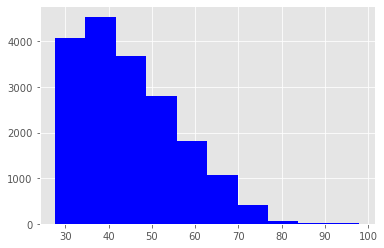

In [89]:
# create a new field for age group
#show distribution to determine bins 
demo_data["Age"].hist(color="blue")
pass

In [90]:
# Create age bands
bins= [0, 30, 40, 50, 60, 70, np.inf]
names= ["<30s","30s", "40s", "50s", "60s", "70+"]
demo_data["Age_group"] =pd.cut(demo_data["Age"], bins, labels=names) 

In [91]:
demo_data.head()

,CustomerID,BirthDate,CommuteDistance,DateFirstPurchase,Gender,HouseOwnerFlag,MaritalStatus,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,Education,Occupation,Age,Age_group
0,11000,1971-10-06,1-2 Miles,2011-01-19,M,1,M,0,0,2,90000.0,Bachelors,Professional,42.314353,40s
1,11001,1976-05-10,0-1 Miles,2011-01-15,M,0,S,1,3,3,60000.0,Bachelors,Professional,37.720145,30s
2,11002,1971-02-09,2-5 Miles,2011-01-07,M,1,M,1,3,3,60000.0,Bachelors,Professional,42.968713,40s
3,11003,1973-08-14,5-10 Miles,2010-12-29,F,0,S,1,0,0,70000.0,Bachelors,Professional,40.458052,40s
4,11004,1979-08-05,1-2 Miles,2011-01-23,F,1,S,4,5,5,80000.0,Bachelors,Professional,34.483939,30s


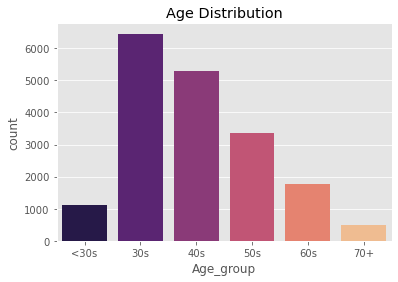

In [92]:
sns.countplot(x = 'Age_group',  data =demo_data, palette = 'magma')
plt.title('Age Distribution')
plt.show()

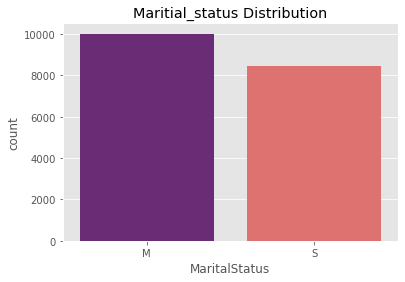

In [93]:
sns.countplot(x = 'MaritalStatus',  data =demo_data, palette = 'magma')
plt.title('Maritial_status Distribution')
plt.show()

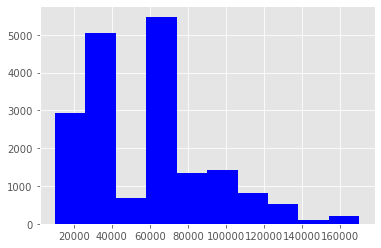

In [94]:
# Create a new field for income group
# show distribution to determine bins.
demo_data["YearlyIncome"].hist(color="blue")
pass

In [95]:
# Create bands
bins= [0, 20000, 60000, 100000, 180000]
names= ["Low", "Mid", "High", "Very High"]
demo_data["income_group"] =pd.cut(demo_data["YearlyIncome"], bins, labels=names) 

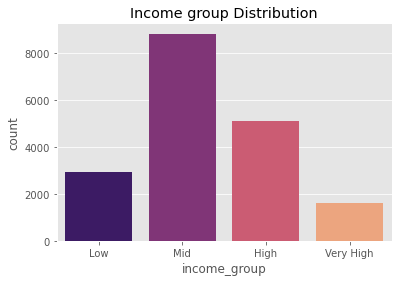

In [96]:
#Plot showing income grouup distribution
sns.countplot(x = 'income_group',  data =demo_data, palette = 'magma')
plt.title('Income group Distribution')
plt.show()

In [97]:
#Create a new field for HouseOwnerFlag
demo_data["HouseOwner"] = demo_data.HouseOwnerFlag.map(lambda HouseOwnerFlag: "Landlord" if HouseOwnerFlag == "1" else "Tenant")

In [98]:
demo_data.head()

,CustomerID,BirthDate,CommuteDistance,DateFirstPurchase,Gender,HouseOwnerFlag,MaritalStatus,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,Education,Occupation,Age,Age_group,income_group,HouseOwner
0,11000,1971-10-06,1-2 Miles,2011-01-19,M,1,M,0,0,2,90000.0,Bachelors,Professional,42.314353,40s,High,Landlord
1,11001,1976-05-10,0-1 Miles,2011-01-15,M,0,S,1,3,3,60000.0,Bachelors,Professional,37.720145,30s,Mid,Tenant
2,11002,1971-02-09,2-5 Miles,2011-01-07,M,1,M,1,3,3,60000.0,Bachelors,Professional,42.968713,40s,Mid,Landlord
3,11003,1973-08-14,5-10 Miles,2010-12-29,F,0,S,1,0,0,70000.0,Bachelors,Professional,40.458052,40s,High,Tenant
4,11004,1979-08-05,1-2 Miles,2011-01-23,F,1,S,4,5,5,80000.0,Bachelors,Professional,34.483939,30s,High,Landlord


In [99]:
#drop HouseOwnerFlag
demo_data = demo_data.drop("HouseOwnerFlag", axis=1)

In [100]:
demo_data.head()

,CustomerID,BirthDate,CommuteDistance,DateFirstPurchase,Gender,MaritalStatus,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,Education,Occupation,Age,Age_group,income_group,HouseOwner
0,11000,1971-10-06,1-2 Miles,2011-01-19,M,M,0,0,2,90000.0,Bachelors,Professional,42.314353,40s,High,Landlord
1,11001,1976-05-10,0-1 Miles,2011-01-15,M,S,1,3,3,60000.0,Bachelors,Professional,37.720145,30s,Mid,Tenant
2,11002,1971-02-09,2-5 Miles,2011-01-07,M,M,1,3,3,60000.0,Bachelors,Professional,42.968713,40s,Mid,Landlord
3,11003,1973-08-14,5-10 Miles,2010-12-29,F,S,1,0,0,70000.0,Bachelors,Professional,40.458052,40s,High,Tenant
4,11004,1979-08-05,1-2 Miles,2011-01-23,F,S,4,5,5,80000.0,Bachelors,Professional,34.483939,30s,High,Landlord


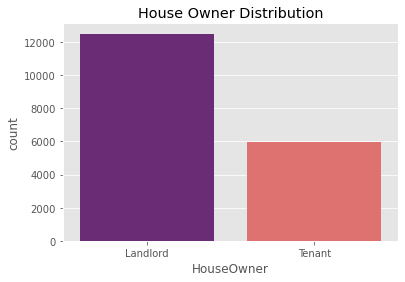

In [101]:
#Plot showing house_owner distribution
sns.countplot(x = 'HouseOwner',  data =demo_data, palette = 'magma')
plt.title('House Owner Distribution')
plt.show()

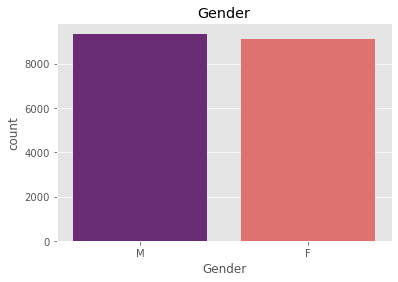

In [102]:
#Plot showing Gender_distribution
sns.countplot(x = 'Gender',  data =demo_data, palette = 'magma')
plt.title('Gender')
plt.show()

In [103]:
#Join transactional and demographic tables into a single view table
single_view=pd.merge(single_view, demo_data, on="CustomerID")
single_view.head()

,CustomerID,Quantity_sum,Quantity_mean,Quantity_median,Quantity_min,Quantity_max,Profit_sum,Profit_mean,Profit_median,Profit_min,...,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,Education,Occupation,Age,Age_group,income_group,HouseOwner
0,11000,8,2.666667,2.0,1,5,3513.6905,1171.230167,1068.1300,957.7249,...,0,0,2,90000.0,Bachelors,Professional,42.314353,40s,High,Landlord
1,11001,11,3.666667,4.0,1,6,2795.8839,931.961300,1091.9928,226.9955,...,1,3,3,60000.0,Bachelors,Professional,37.720145,30s,Mid,Tenant
2,11002,4,1.333333,1.0,1,2,3454.8801,1151.626700,1043.0087,924.0358,...,1,3,3,60000.0,Bachelors,Professional,42.968713,40s,Mid,Landlord
3,11003,9,3.000000,4.0,1,4,3467.1264,1155.708800,1054.4538,924.8370,...,1,0,0,70000.0,Bachelors,Professional,40.458052,40s,High,Tenant
4,11004,6,2.000000,2.0,1,3,3501.9051,1167.301700,1090.0337,924.0358,...,4,5,5,80000.0,Bachelors,Professional,34.483939,30s,High,Landlord


### Churn Distribution

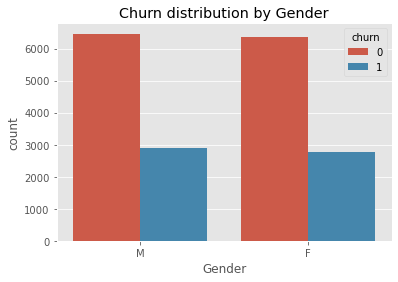

In [104]:
df_gender=single_view[['churn', 'Gender']]
sns.countplot(x='Gender', hue='churn',data = df_gender)
plt.title('Churn distribution by Gender')
plt.show()

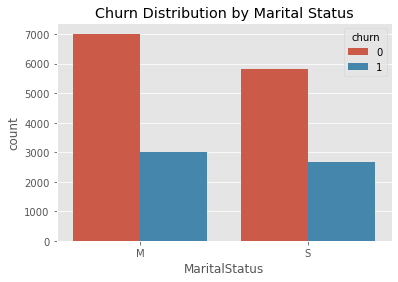

In [105]:
df_MaritalStatus=single_view[['churn', 'MaritalStatus']]
sns.countplot(x='MaritalStatus', hue='churn',data = df_MaritalStatus)
plt.title('Churn Distribution by Marital Status')
plt.show()

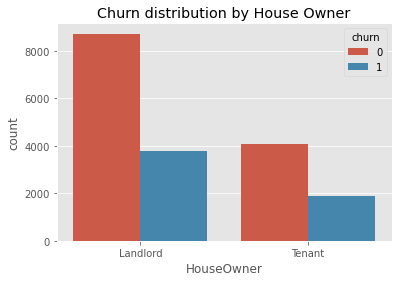

In [106]:
df_houseowner=single_view[['churn', 'HouseOwner']]
sns.countplot(x='HouseOwner', hue='churn',data = df_houseowner)
plt.title('Churn distribution by House Owner')
plt.show()

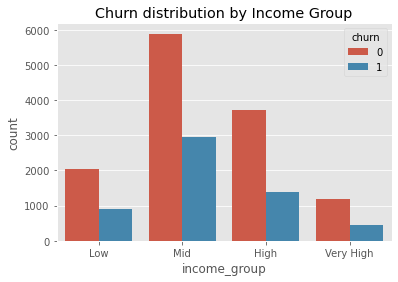

In [107]:
df_incomeGroup=single_view[['churn', 'income_group']]
sns.countplot(x='income_group', hue='churn',data =df_incomeGroup)
plt.title('Churn distribution by Income Group')
plt.show()

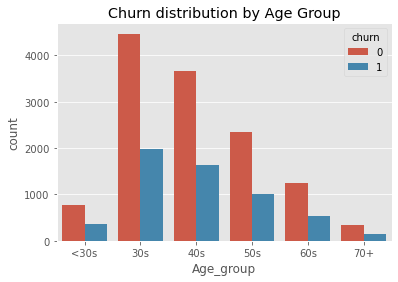

In [108]:
df_AgeGroup=single_view[['churn', 'Age_group']]
sns.countplot(x='Age_group', hue='churn',data =df_AgeGroup)
plt.title('Churn distribution by Age Group')
plt.show()

### Churn Rate Distribution

In [109]:
#import the necessary libraries
import matplotlib.ticker as mtick

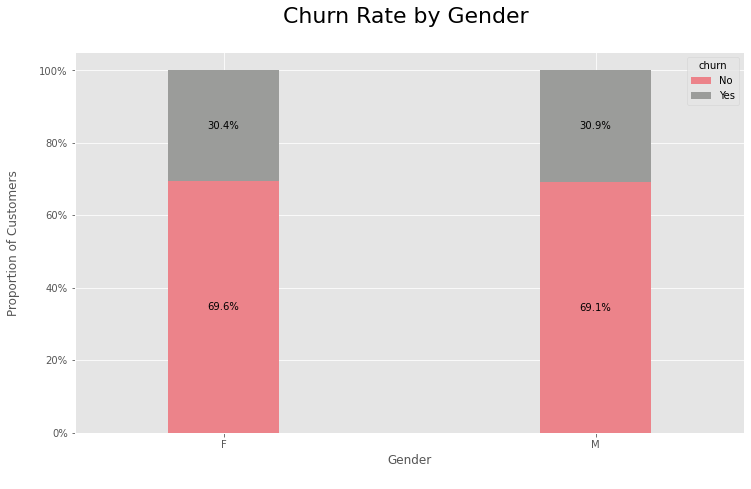

In [110]:
#Churn Rate by Gender
churn1 = single_view.groupby(['Gender','churn']).size().unstack()

churn1.rename(columns={0:'No', 1:'Yes'}, inplace=True)

colors  = ['#ec838a','#9b9c9a']

ax = (churn1.T*100.0 / churn1.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (12,7),
                                                                color = colors)





plt.ylabel('Proportion of Customers\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('Gender\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.title('Churn Rate by Gender \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')
ax.autoscale(enable=False, axis='both', tight=False)

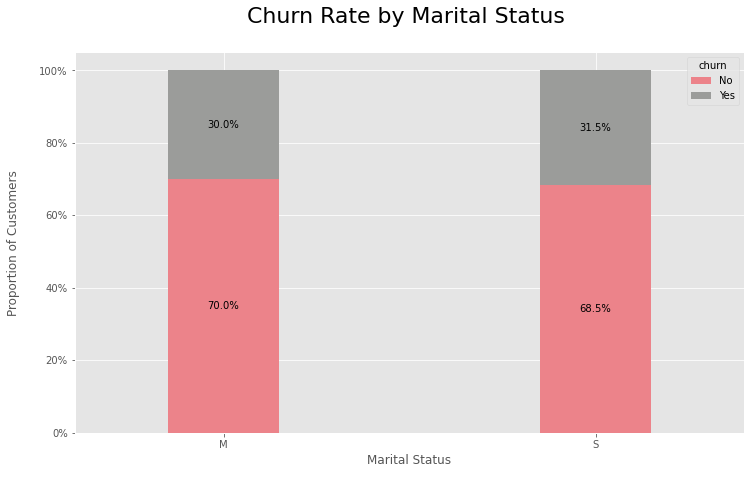

In [111]:
#Churn Rate by Marital Status
churn1 = single_view.groupby(['MaritalStatus','churn']).size().unstack()

churn1.rename(columns={0:'No', 1:'Yes'}, inplace=True)

colors  = ['#ec838a','#9b9c9a']

ax = (churn1.T*100.0 / churn1.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (12,7),
                                                                color = colors)





plt.ylabel('Proportion of Customers\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('Marital Status\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.title('Churn Rate by Marital Status \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')
ax.autoscale(enable=False, axis='both', tight=False)

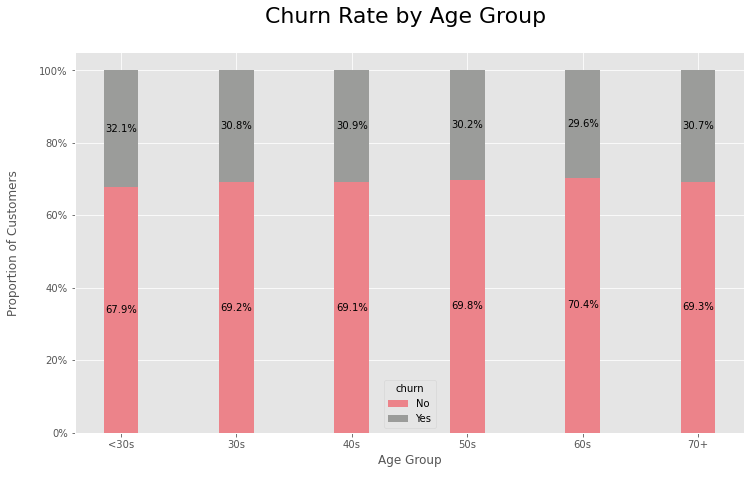

In [112]:
#Churn Rate by Age
churn1 = single_view.groupby(['Age_group','churn']).size().unstack()

churn1.rename(columns={0:'No', 1:'Yes'}, inplace=True)

colors  = ['#ec838a','#9b9c9a']

ax = (churn1.T*100.0 / churn1.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (12,7),
                                                                color = colors)





plt.ylabel('Proportion of Customers\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('Age Group\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.title('Churn Rate by Age Group \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')
ax.autoscale(enable=False, axis='both', tight=False)

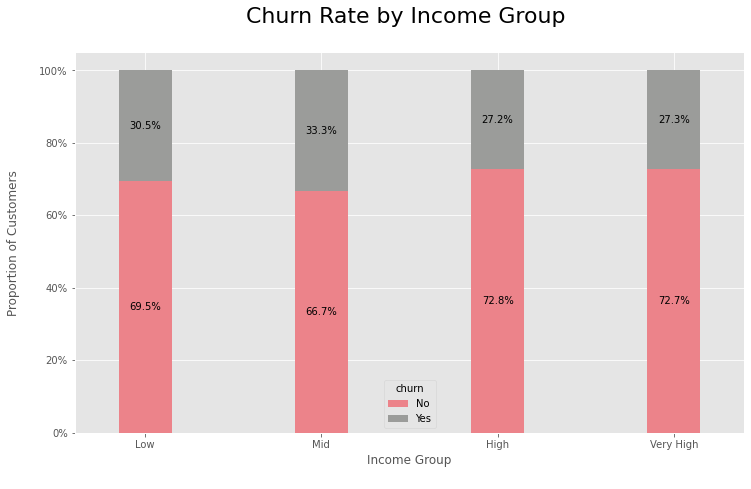

In [113]:
#Churn Rate by Income
churn1 = single_view.groupby(['income_group','churn']).size().unstack()

churn1.rename(columns={0:'No', 1:'Yes'}, inplace=True)

colors  = ['#ec838a','#9b9c9a']

ax = (churn1.T*100.0 / churn1.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (12,7),
                                                                color = colors)





plt.ylabel('Proportion of Customers\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('Income Group\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.title('Churn Rate by Income Group \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')
ax.autoscale(enable=False, axis='both', tight=False)

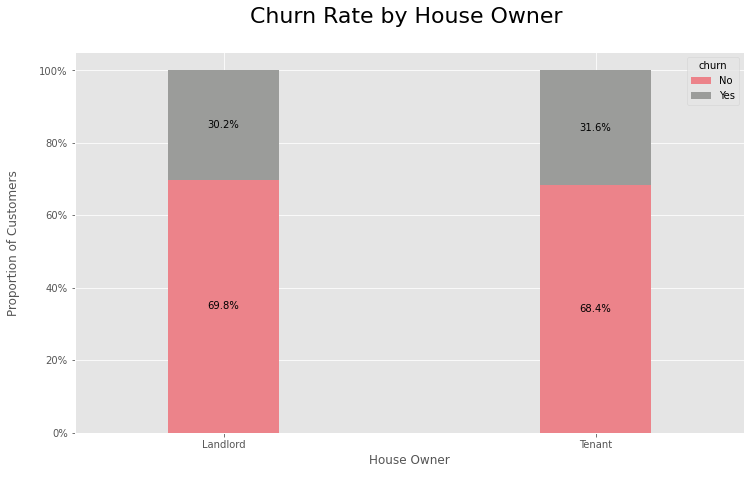

In [114]:
#Churn Rate by House Owner
churn1 = single_view.groupby(['HouseOwner','churn']).size().unstack()

churn1.rename(columns={0:'No', 1:'Yes'}, inplace=True)

colors  = ['#ec838a','#9b9c9a']

ax = (churn1.T*100.0 / churn1.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (12,7),
                                                                color = colors)





plt.ylabel('Proportion of Customers\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('House Owner\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.title('Churn Rate by House Owner \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')
ax.autoscale(enable=False, axis='both', tight=False)

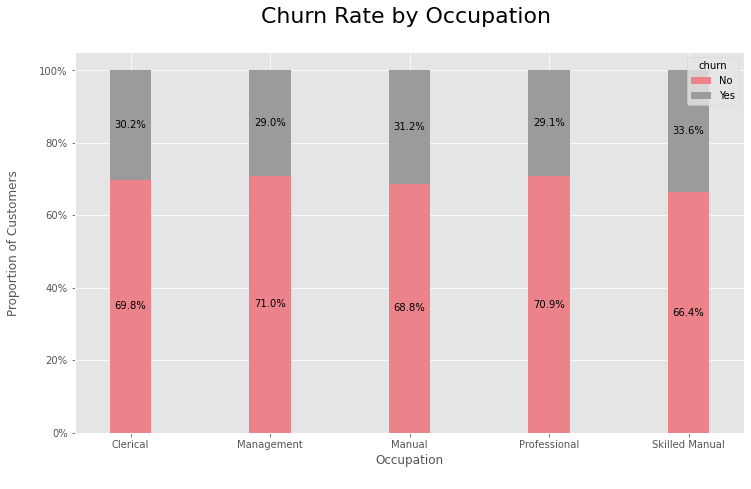

In [115]:
#Churn rate by Occupation
churn1 = single_view.groupby(['Occupation','churn']).size().unstack()

churn1.rename(columns={0:'No', 1:'Yes'}, inplace=True)

colors  = ['#ec838a','#9b9c9a']

ax = (churn1.T*100.0 / churn1.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (12,7),
                                                                color = colors)





plt.ylabel('Proportion of Customers\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('Occupation\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.title('Churn Rate by Occupation \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')
ax.autoscale(enable=False, axis='both', tight=False)

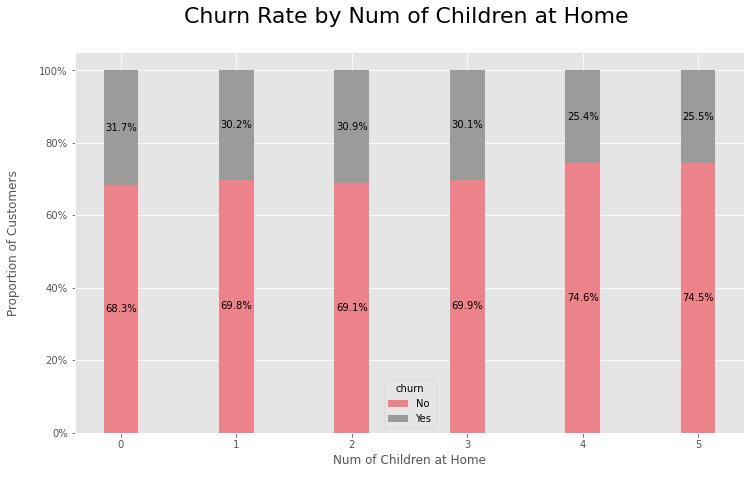

In [116]:
#Churn Rate by NumOfChildrenAtHome
churn1 = single_view.groupby(['NumberChildrenAtHome','churn']).size().unstack()

churn1.rename(columns={0:'No', 1:'Yes'}, inplace=True)

colors  = ['#ec838a','#9b9c9a']

ax = (churn1.T*100.0 / churn1.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (12,7),
                                                                color = colors)





plt.ylabel('Proportion of Customers\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('Num of Children at Home\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.title('Churn Rate by Num of Children at Home \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')
ax.autoscale(enable=False, axis='both', tight=False)

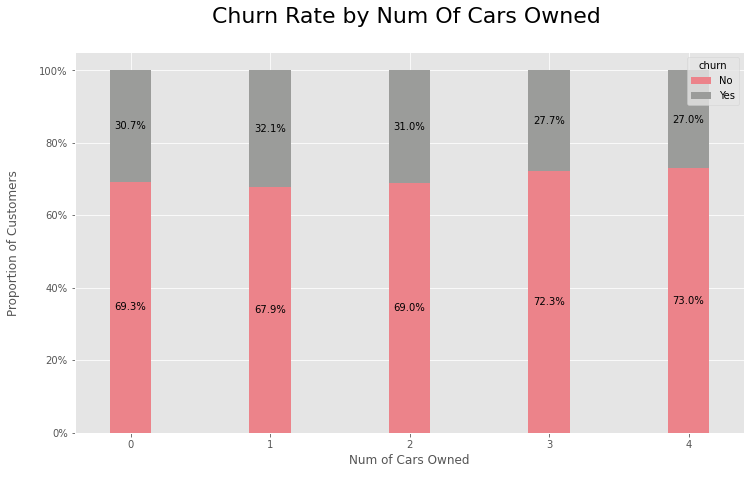

In [117]:
#Churn Rate by CarOwners
churn1 = single_view.groupby(['NumberCarsOwned','churn']).size().unstack()

churn1.rename(columns={0:'No', 1:'Yes'}, inplace=True)

colors  = ['#ec838a','#9b9c9a']

ax = (churn1.T*100.0 / churn1.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (12,7),
                                                                color = colors)





plt.ylabel('Proportion of Customers\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('Num of Cars Owned\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.title('Churn Rate by Num Of Cars Owned \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')
ax.autoscale(enable=False, axis='both', tight=False)

### Attitudinal Analysis

In [118]:
#importing your dataset from sql
db = 'AdventureWorksDW2019' #databaseName
server = 'DESKTOP-RDRRI0S'  #serverName

In [119]:
#create the connection
conn = pyodbc.connect('DRIVER={SQL SERVER};SERVER=' + server + ';DATABASE=' + db + ';Trusted_Connection=yes')

#query 
query = """
SELECT FSA.CustomerKey AS CustomerID, 
       FSA.SalesOrderNumber AS SalesOrderID,
       FSA.SalesOrderLineNumber,
       DSR.SalesReasonReasonType AS SalesReasonType, 
       DSR.SalesReasonName AS SalesReason
FROM FactInternetSales AS FSA
LEFT JOIN FactInternetSalesReason AS FSR
ON FSA.SalesOrderNumber = FSR.SalesOrderNumber
LEFT JOIN DimSalesReason AS DSR
ON FSR.SalesReasonKey = DSR.SalesReasonKey
"""

In [120]:
#reading the sql file from the engine
att_data = pd.read_sql(query, conn) 

print(att_data)

        CustomerID SalesOrderID  SalesOrderLineNumber SalesReasonType  \
0            21768      SO43697                     1           Other   
1            21768      SO43697                     1           Other   
2            27645      SO43702                     1           Other   
3            27645      SO43702                     1           Other   
4            16624      SO43703                     1           Other   
...            ...          ...                   ...             ...   
194581       24192      SO66426                     1            None   
194582       24192      SO66426                     2            None   
194583       22676      SO53226                     1            None   
194584       24698      SO67763                     1            None   
194585       24698      SO67763                     2            None   

         SalesReason  
0       Manufacturer  
1            Quality  
2       Manufacturer  
3            Quality  
4       

### Explore the data

In [121]:
att_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194586 entries, 0 to 194585
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   CustomerID            194586 non-null  int64 
 1   SalesOrderID          194586 non-null  object
 2   SalesOrderLineNumber  194586 non-null  int64 
 3   SalesReasonType       188157 non-null  object
 4   SalesReason           188157 non-null  object
dtypes: int64(2), object(3)
memory usage: 7.4+ MB


In [122]:
#Check for duplicates in dataset
att_data.duplicated().sum()

123642

In [123]:
#Drop all duplicates
att_data.drop_duplicates(subset=None, keep="first", inplace=True)

In [124]:
#Cross-check for duplicates
att_data.duplicated().sum()

0

In [125]:
att_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70944 entries, 0 to 194585
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   CustomerID            70944 non-null  int64 
 1   SalesOrderID          70944 non-null  object
 2   SalesOrderLineNumber  70944 non-null  int64 
 3   SalesReasonType       64515 non-null  object
 4   SalesReason           64515 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.2+ MB


In [126]:
#Cross-check for missing data
att_data.isnull().sum()

CustomerID                 0
SalesOrderID               0
SalesOrderLineNumber       0
SalesReasonType         6429
SalesReason             6429
dtype: int64

In [127]:
# Replace missing values in Sales_reason_type and Sales_reason_type with mode
att_data = att_data.fillna(att_data.mode().iloc[0])
att_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70944 entries, 0 to 194585
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   CustomerID            70944 non-null  int64 
 1   SalesOrderID          70944 non-null  object
 2   SalesOrderLineNumber  70944 non-null  int64 
 3   SalesReasonType       70944 non-null  object
 4   SalesReason           70944 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.2+ MB


In [128]:
#Cross-check for missing data
att_data.isnull().sum()

CustomerID              0
SalesOrderID            0
SalesOrderLineNumber    0
SalesReasonType         0
SalesReason             0
dtype: int64

In [129]:
att_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70944 entries, 0 to 194585
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   CustomerID            70944 non-null  int64 
 1   SalesOrderID          70944 non-null  object
 2   SalesOrderLineNumber  70944 non-null  int64 
 3   SalesReasonType       70944 non-null  object
 4   SalesReason           70944 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.2+ MB


### Transform the data

In [130]:
#Summarise data per customer
#Use One-Hot encoding to convert the values for Sales reason type and Sales reason
cols = ['SalesReasonType', 'SalesReason']
att_data = pd.get_dummies(data = att_data, columns = cols)

In [131]:
att_data.head()

,CustomerID,SalesOrderID,SalesOrderLineNumber,SalesReasonType_Marketing,SalesReasonType_Other,SalesReasonType_Promotion,SalesReason_Manufacturer,SalesReason_On Promotion,SalesReason_Other,SalesReason_Price,SalesReason_Quality,SalesReason_Review,SalesReason_Television Advertisement
0,21768,SO43697,1,0,1,0,1,0,0,0,0,0,0
1,21768,SO43697,1,0,1,0,0,0,0,0,1,0,0
2,27645,SO43702,1,0,1,0,1,0,0,0,0,0,0
3,27645,SO43702,1,0,1,0,0,0,0,0,1,0,0
4,16624,SO43703,1,0,1,0,1,0,0,0,0,0,0


In [132]:
att_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70944 entries, 0 to 194585
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   CustomerID                             70944 non-null  int64 
 1   SalesOrderID                           70944 non-null  object
 2   SalesOrderLineNumber                   70944 non-null  int64 
 3   SalesReasonType_Marketing              70944 non-null  uint8 
 4   SalesReasonType_Other                  70944 non-null  uint8 
 5   SalesReasonType_Promotion              70944 non-null  uint8 
 6   SalesReason_Manufacturer               70944 non-null  uint8 
 7   SalesReason_On Promotion               70944 non-null  uint8 
 8   SalesReason_Other                      70944 non-null  uint8 
 9   SalesReason_Price                      70944 non-null  uint8 
 10  SalesReason_Quality                    70944 non-null  uint8 
 11  SalesReason_Re

In [133]:
# Aggregate the variables 
att_data = att_data.groupby('CustomerID').agg({'SalesReasonType_Marketing':'max',
                                               'SalesReasonType_Other':'max', 
                                               'SalesReasonType_Promotion':'max',
                                               'SalesReason_Manufacturer':'max', 
                                               'SalesReason_On Promotion':'max',
                                               'SalesReason_Other':'max', 
                                               'SalesReason_Price':'max', 
                                               'SalesReason_Quality':'max',
                                               'SalesReason_Review':'max', 
                                               'SalesReason_Television  Advertisement':'max'}).reset_index()

In [134]:
att_data.head()

,CustomerID,SalesReasonType_Marketing,SalesReasonType_Other,SalesReasonType_Promotion,SalesReason_Manufacturer,SalesReason_On Promotion,SalesReason_Other,SalesReason_Price,SalesReason_Quality,SalesReason_Review,SalesReason_Television Advertisement
0,11000,0,1,1,0,1,0,1,0,0,0
1,11001,0,1,0,0,0,0,1,0,0,0
2,11002,0,1,1,0,1,0,1,0,0,0
3,11003,0,1,0,0,0,0,1,0,0,0
4,11004,0,1,0,0,0,0,1,0,0,0


In [135]:
att_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype
---  ------                                 --------------  -----
 0   CustomerID                             18484 non-null  int64
 1   SalesReasonType_Marketing              18484 non-null  uint8
 2   SalesReasonType_Other                  18484 non-null  uint8
 3   SalesReasonType_Promotion              18484 non-null  uint8
 4   SalesReason_Manufacturer               18484 non-null  uint8
 5   SalesReason_On Promotion               18484 non-null  uint8
 6   SalesReason_Other                      18484 non-null  uint8
 7   SalesReason_Price                      18484 non-null  uint8
 8   SalesReason_Quality                    18484 non-null  uint8
 9   SalesReason_Review                     18484 non-null  uint8
 10  SalesReason_Television  Advertisement  18484 non-null  uint8
dtypes: int64(1), uint8(10)
memor

In [136]:
# Join transactional, demomographic and attitudinal data
single_view = pd.merge(single_view, att_data, on="CustomerID")
single_view.head().transpose()

,0,1,2,3,4
CustomerID,11000,11001,11002,11003,11004
Quantity_sum,8,11,4,9,6
Quantity_mean,2.66667,3.66667,1.33333,3,2
Quantity_median,2,4,1,4,2
Quantity_min,1,1,1,1,1
Quantity_max,5,6,2,4,3
Profit_sum,3513.69,2795.88,3454.88,3467.13,3501.91
Profit_mean,1171.23,931.961,1151.63,1155.71,1167.3
Profit_median,1068.13,1091.99,1043.01,1054.45,1090.03
Profit_min,957.725,226.995,924.036,924.837,924.036


### Exploratory Data Analysis

#### Hold Out Sample

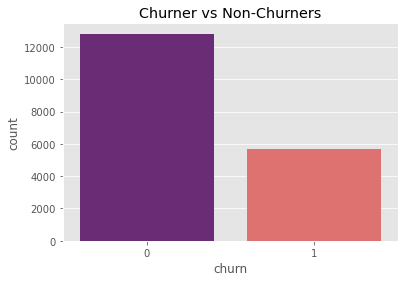

In [137]:
# Count plot for target varible (Churners vs nonchurners)
sns.countplot(x = 'churn',  data =single_view, palette = 'magma')
plt.title('Churner vs Non-Churners')
plt.show()

In [138]:
single_view['churn'].value_counts()

0    12817
1     5667
Name: churn, dtype: int64

#### Hold out for score data scoring;50% of nonchurners

In [139]:
# Hold out score data scoring;50% of nonchurners
non_churners = single_view[single_view["churn"]==0]
non_churners.head()

,CustomerID,Quantity_sum,Quantity_mean,Quantity_median,Quantity_min,Quantity_max,Profit_sum,Profit_mean,Profit_median,Profit_min,...,SalesReasonType_Marketing,SalesReasonType_Other,SalesReasonType_Promotion,SalesReason_Manufacturer,SalesReason_On Promotion,SalesReason_Other,SalesReason_Price,SalesReason_Quality,SalesReason_Review,SalesReason_Television Advertisement
1,11001,11,3.666667,4.0,1,6,2795.8839,931.961300,1091.9928,226.9955,...,0,1,0,0,0,0,1,0,0,0
12,11012,5,2.500000,2.5,2,3,50.8686,25.434300,25.4343,3.9312,...,0,1,0,0,0,0,1,0,0,0
13,11013,5,2.500000,2.5,2,3,71.3388,35.669400,35.6694,24.4014,...,0,1,0,0,0,0,1,0,0,0
17,11017,4,1.333333,1.0,1,2,2814.5690,938.189667,1056.7682,280.9052,...,0,1,1,0,1,0,1,0,0,0
18,11018,7,2.333333,2.0,1,4,2867.5259,955.841967,1068.1300,311.5603,...,0,1,1,0,1,0,1,0,0,0


In [140]:
#Non_churner model
from sklearn.model_selection import train_test_split
seed=0
score_pct=0.5
model_data, score_data=train_test_split(non_churners,test_size=score_pct, random_state=seed)

len(model_data)

6408

In [141]:
len(score_data)

6409

In [142]:
#Join non-churner model data with churner data
churners = single_view[single_view['churn'] == 1]
model_data = pd.concat([model_data, churners], ignore_index=True)
model_data.shape

(12075, 54)

In [143]:
model_data.head().transpose()

,0,1,2,3,4
CustomerID,27488,20810,27756,20652,25903
Quantity_sum,2,2,1,2,4
Quantity_mean,1,2,1,2,2
Quantity_median,1,2,1,2,2
Quantity_min,1,2,1,2,1
Quantity_max,1,2,1,2,3
Profit_sum,492.624,3.9312,43.8137,419.828,2387.78
Profit_mean,246.312,3.9312,43.8137,419.828,1193.89
Profit_median,246.312,3.9312,43.8137,419.828,1193.89
Profit_min,196.34,3.9312,43.8137,419.828,910.884


In [144]:
# Check again for missing values 
model_data.isnull().sum()[model_data.isnull().sum()!=0]

#Customers with nan values for Days Elapsed are those that have made only one transaction.
#It was decided to leave out those variables from the model in place of replacing with mean, mode or median or dropping it, because the nan values are over 2/3 of the total customers.

No of Days Elapsed_mean      7864
No of Days Elapsed_median    7864
No of Days Elapsed_min       7864
No of Days Elapsed_max       7864
dtype: int64

In [145]:
#Check again for duplicates
print('Number of duplicates:', model_data.duplicated().sum())

Number of duplicates: 0


### Categorical Data

In [146]:
#Get necessary columns
cols = model_data.columns
cols

Index(['CustomerID', 'Quantity_sum', 'Quantity_mean', 'Quantity_median',
       'Quantity_min', 'Quantity_max', 'Profit_sum', 'Profit_mean',
       'Profit_median', 'Profit_min', 'Profit_max', 'Revenue_sum',
       'Revenue_mean', 'Revenue_median', 'Revenue_min', 'Revenue_max',
       'No of Days Elapsed_sum', 'No of Days Elapsed_mean',
       'No of Days Elapsed_median', 'No of Days Elapsed_min',
       'No of Days Elapsed_max', 'recency(days)', 'frequency',
       'monetary_value', 'RFMScore', 'RFM_score_total', 'RFM_Cluster',
       'Tenure_month', 'churn', 'BirthDate', 'CommuteDistance',
       'DateFirstPurchase', 'Gender', 'MaritalStatus', 'NumberCarsOwned',
       'NumberChildrenAtHome', 'TotalChildren', 'YearlyIncome', 'Education',
       'Occupation', 'Age', 'Age_group', 'income_group', 'HouseOwner',
       'SalesReasonType_Marketing', 'SalesReasonType_Other',
       'SalesReasonType_Promotion', 'SalesReason_Manufacturer',
       'SalesReason_On Promotion', 'SalesReason_Other'

In [147]:
#Remove unnecessary fields
col_ = ['CustomerID', 
        'Quantity_min', 
        'Revenue_sum', 
        'BirthDate',
        'No of Days Elapsed_sum',
        'No of Days Elapsed_mean', 
        'No of Days Elapsed_median',
        'No of Days Elapsed_min', 
        'No of Days Elapsed_max']

select_data = model_data.drop(col_, axis = 1)
select_data.columns

Index(['Quantity_sum', 'Quantity_mean', 'Quantity_median', 'Quantity_max',
       'Profit_sum', 'Profit_mean', 'Profit_median', 'Profit_min',
       'Profit_max', 'Revenue_mean', 'Revenue_median', 'Revenue_min',
       'Revenue_max', 'recency(days)', 'frequency', 'monetary_value',
       'RFMScore', 'RFM_score_total', 'RFM_Cluster', 'Tenure_month', 'churn',
       'CommuteDistance', 'DateFirstPurchase', 'Gender', 'MaritalStatus',
       'NumberCarsOwned', 'NumberChildrenAtHome', 'TotalChildren',
       'YearlyIncome', 'Education', 'Occupation', 'Age', 'Age_group',
       'income_group', 'HouseOwner', 'SalesReasonType_Marketing',
       'SalesReasonType_Other', 'SalesReasonType_Promotion',
       'SalesReason_Manufacturer', 'SalesReason_On Promotion',
       'SalesReason_Other', 'SalesReason_Price', 'SalesReason_Quality',
       'SalesReason_Review', 'SalesReason_Television  Advertisement'],
      dtype='object')

In [148]:
# Filter categorical variables
cat =['RFMScore', 
      'RFM_score_total',  
      'RFM_Cluster', 
      'MaritalStatus', 
      'Gender', 
      'TotalChildren',
      'YearlyIncome',
      'NumberChildrenAtHome', 
      'Occupation', 
      'Education', 
      'CommuteDistance',
      'NumberCarsOwned',
      'Age_group',
      'income_group',
      'HouseOwner', 
      'SalesReasonType_Marketing', 
      'SalesReasonType_Other',
      'SalesReasonType_Promotion',
      'SalesReason_Manufacturer',
      'SalesReason_On Promotion', 
      'SalesReason_Other', 
      'SalesReason_Price',
      'SalesReason_Quality', 
      'SalesReason_Review',
      'SalesReason_Television  Advertisement']

In [149]:
#Get distribution frequency per category
for var in cat:
    print(select_data[var].value_counts())

444    1242
442    1118
443     870
421     810
344     714
321     564
342     559
144     487
244     484
343     481
242     466
221     461
142     439
243     362
121     350
143     349
441     281
123     261
111     200
211     173
223     157
323     157
311     149
422     137
322     107
113     106
222      98
122      95
423      88
112      44
213      44
411      43
124      37
224      36
313      24
324      21
424      17
212      14
413       8
341       7
312       5
241       4
114       3
214       2
141       1
Name: RFMScore, dtype: int64
10    2100
9     1798
11    1584
7     1580
12    1242
8     1160
6     1019
5      825
4      567
3      200
Name: RFM_score_total, dtype: int64
1    4133
2    2781
4    2403
3    1445
0    1313
Name: RFM_Cluster, dtype: int64
M    6529
S    5546
Name: MaritalStatus, dtype: int64
M    6129
F    5946
Name: Gender, dtype: int64
0    3385
1    2443
2    2432
4    1495
3    1405
5     915
Name: TotalChildren, dtype: int64
60000.0 

<ipython-input-150-e2b6f99c5912>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)


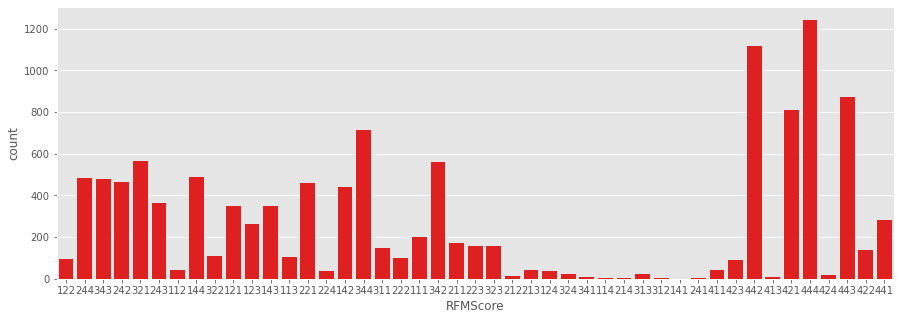

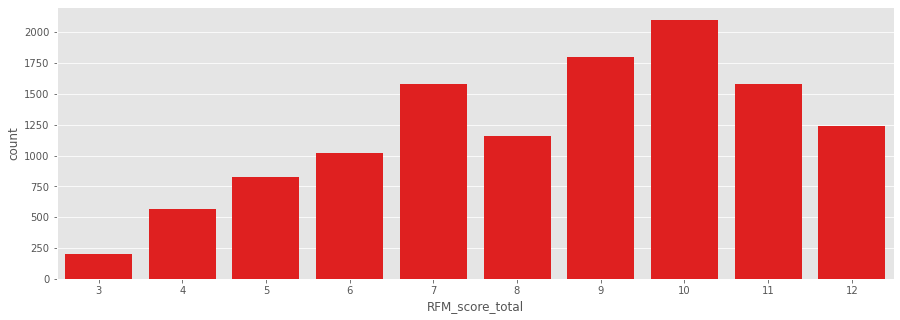

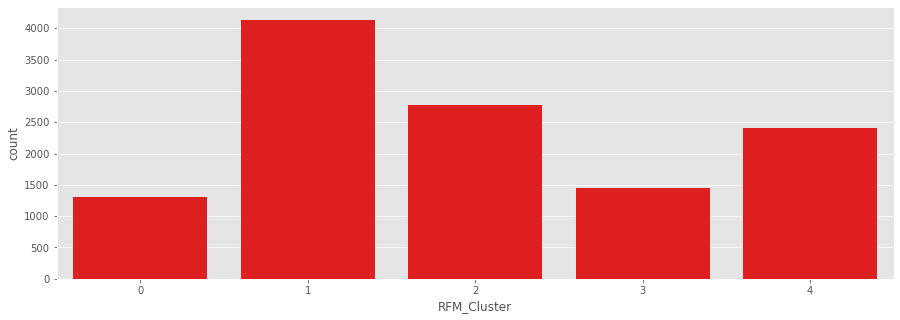

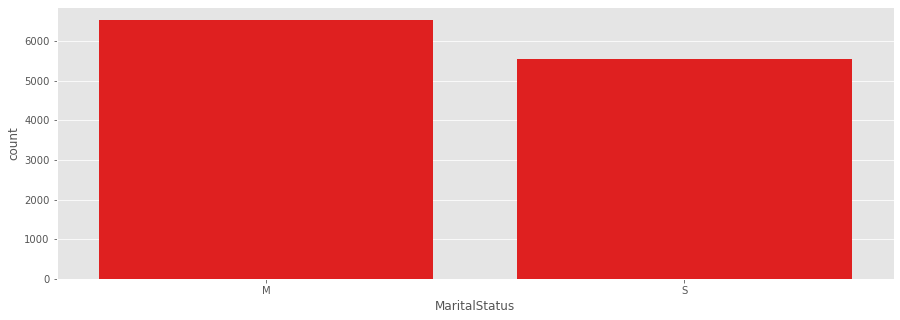

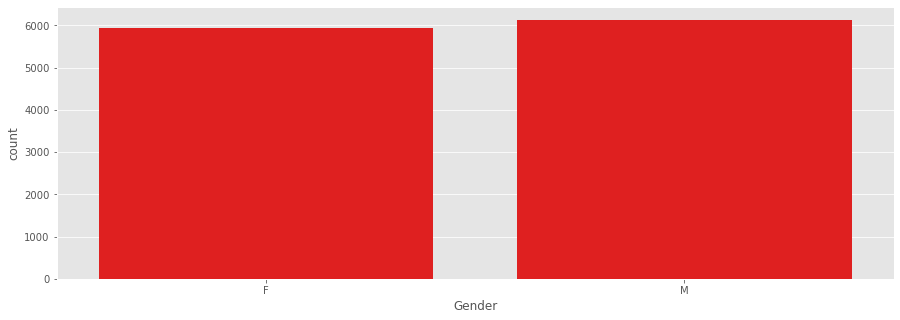

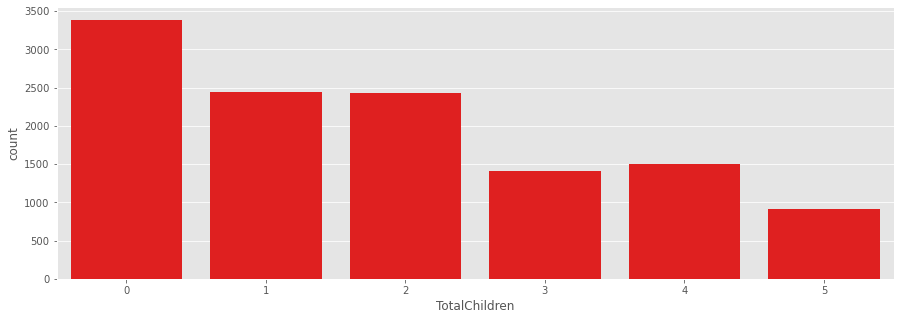

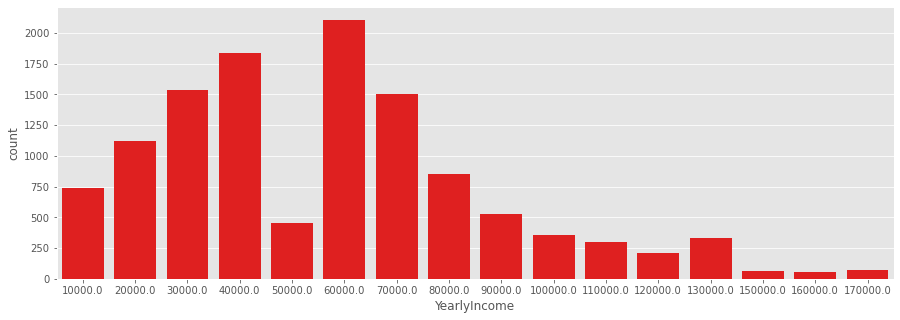

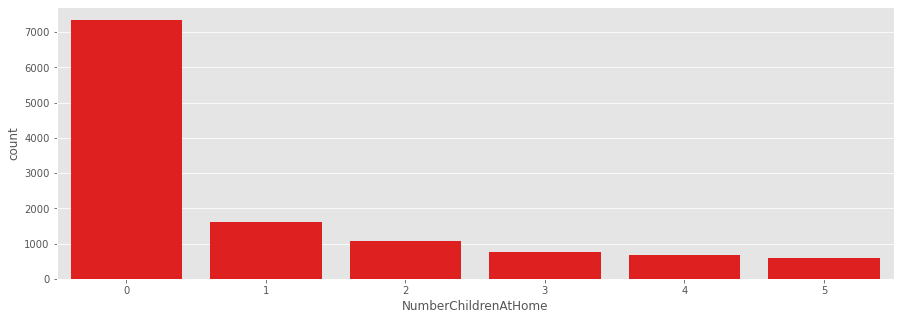

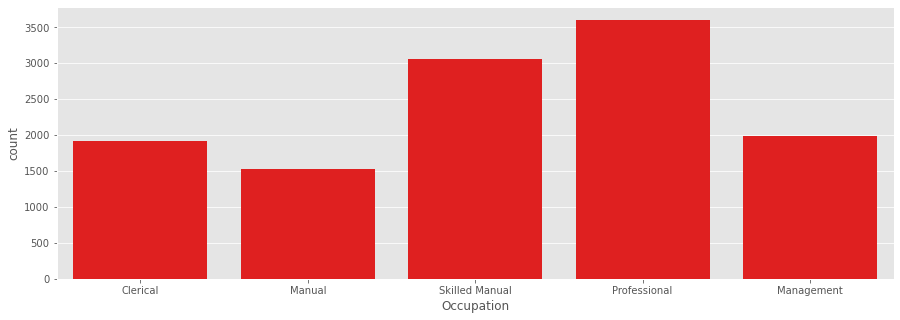

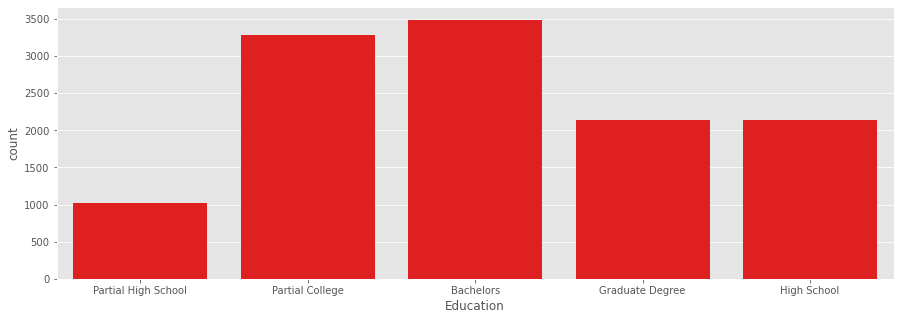

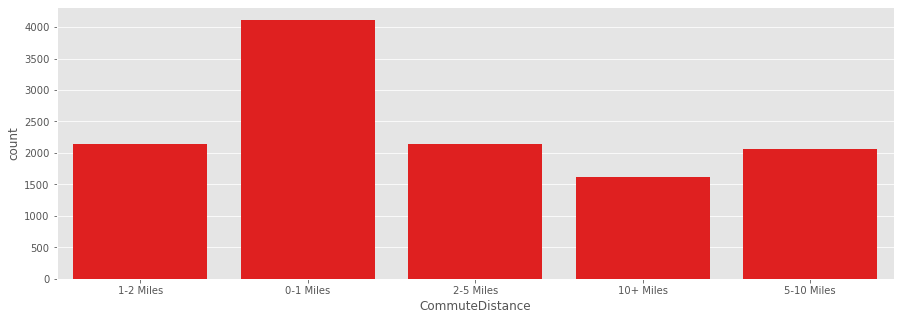

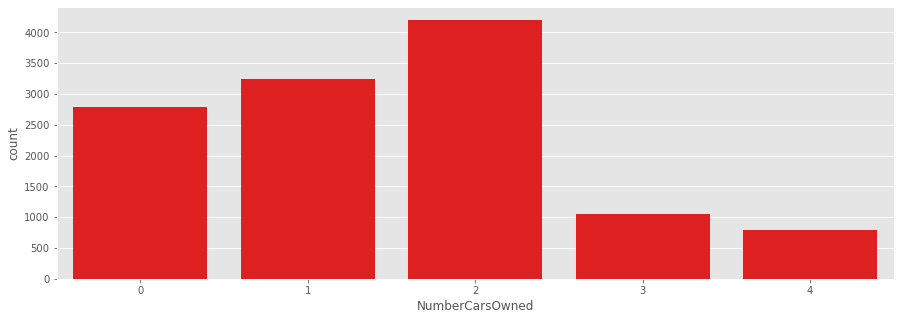

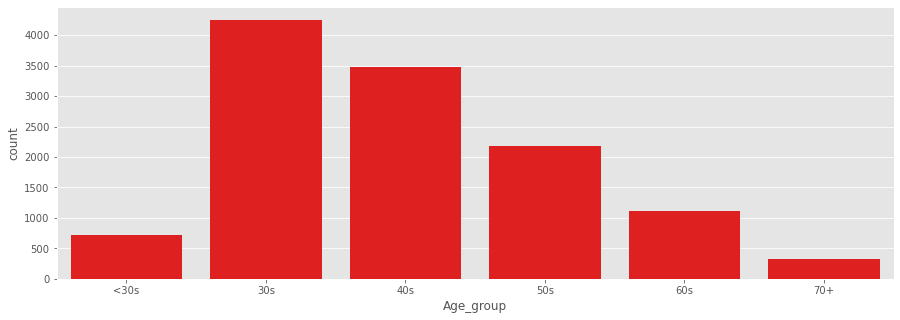

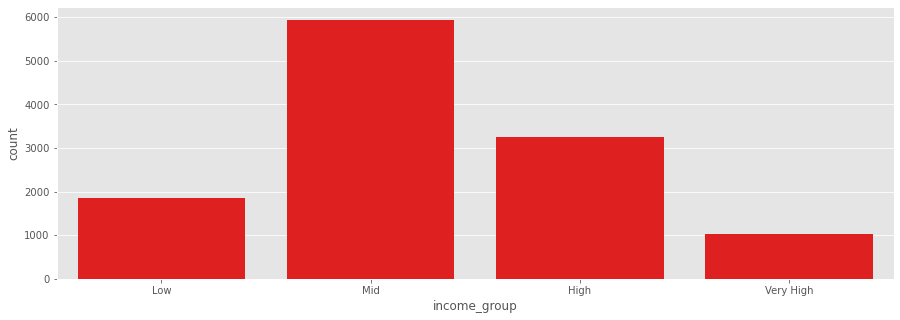

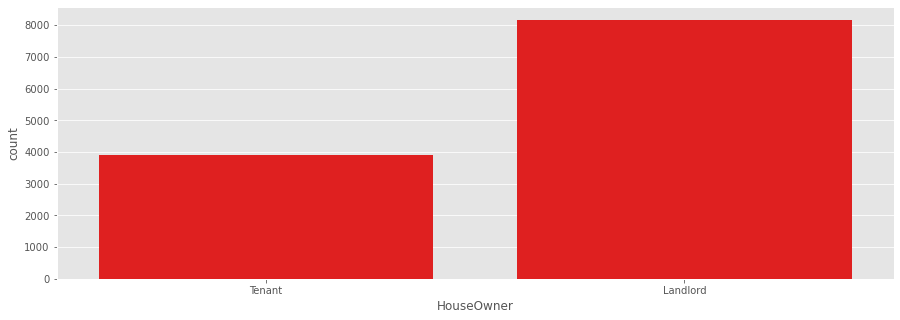

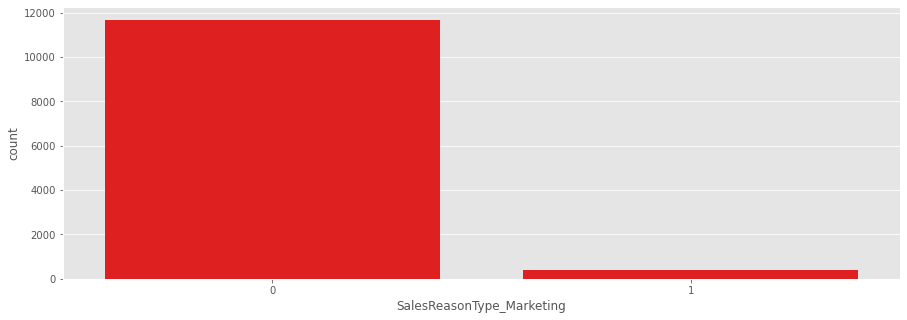

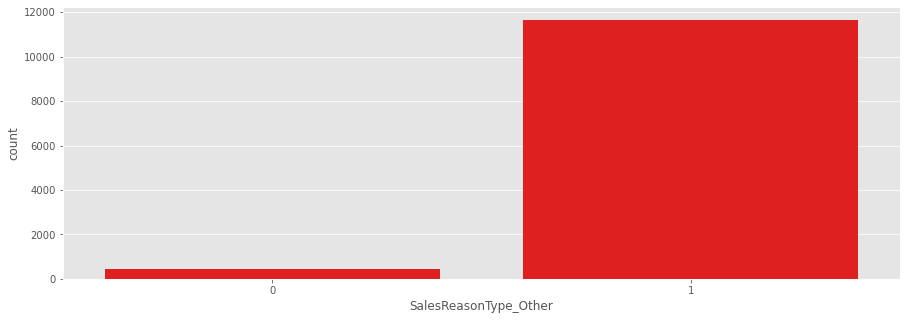

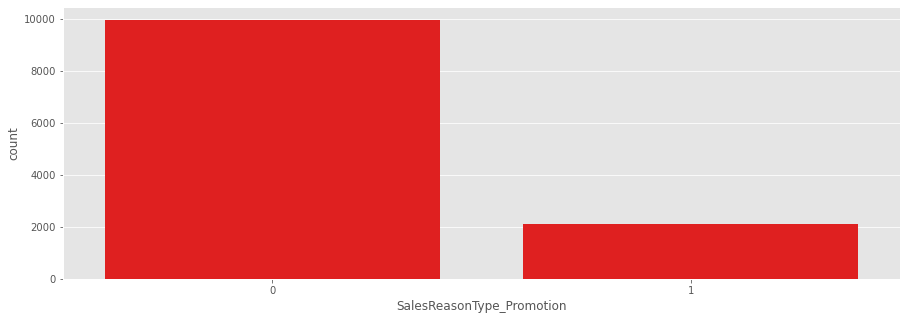

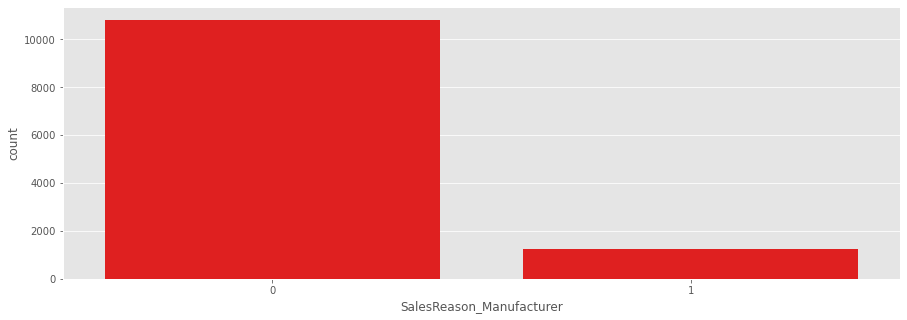

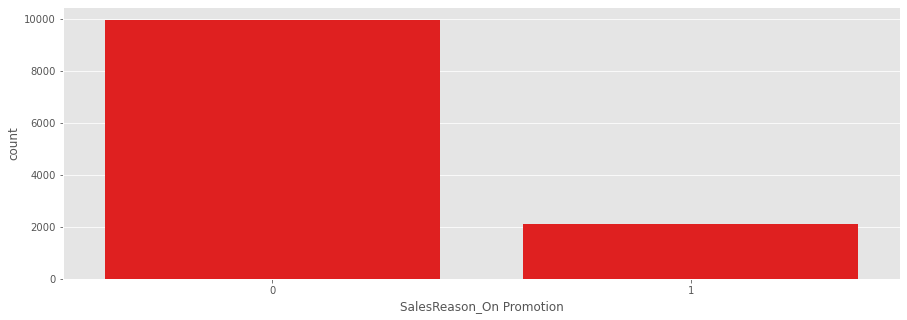

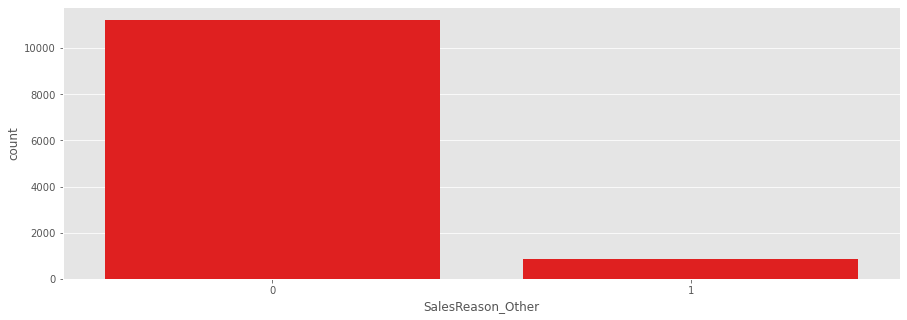

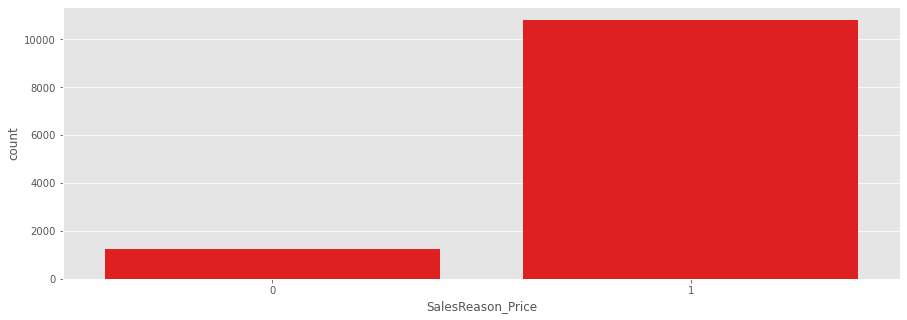

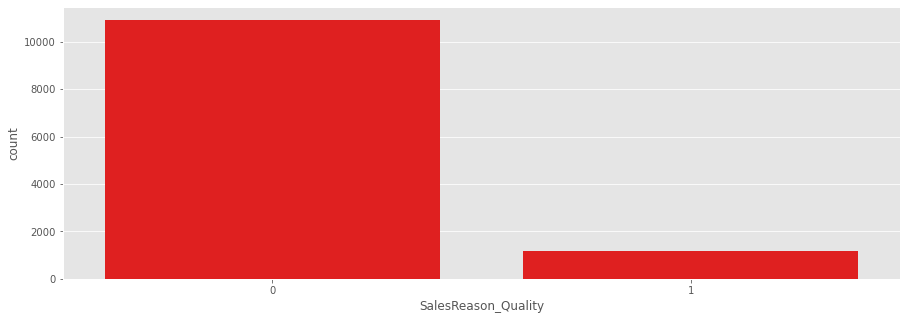

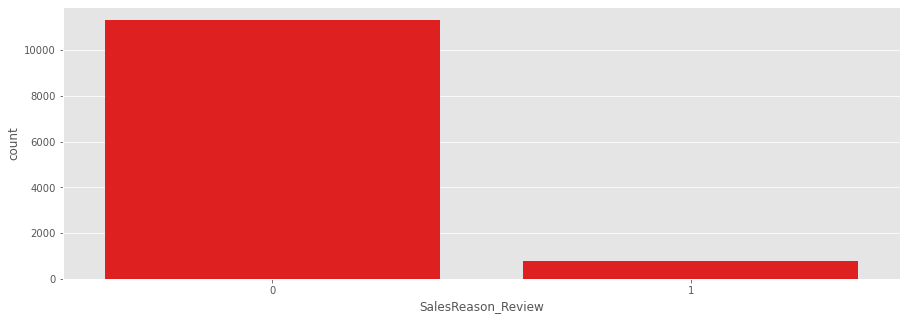

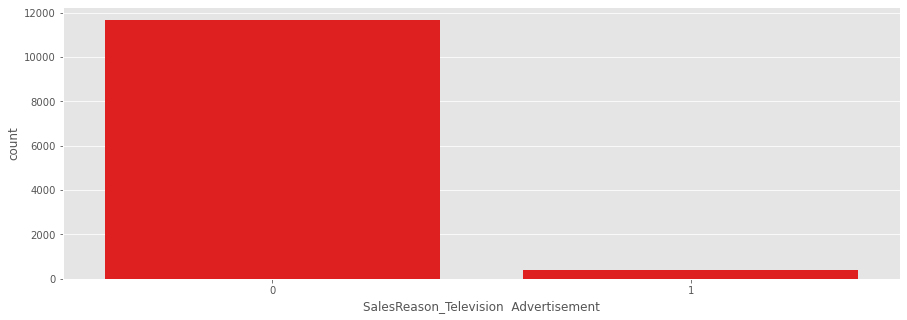

In [150]:
#PLot distribution/frequency per category
cat_df = select_data[cat]
plt.rcParams['figure.figsize'] = (15, 5) # Chart sizes

for i, col in enumerate(cat_df.columns):
   plt.figure(i)
   sns.countplot(x=col, data=cat_df, color = 'red')

In [151]:
att_data.columns

Index(['CustomerID', 'SalesReasonType_Marketing', 'SalesReasonType_Other',
       'SalesReasonType_Promotion', 'SalesReason_Manufacturer',
       'SalesReason_On Promotion', 'SalesReason_Other', 'SalesReason_Price',
       'SalesReason_Quality', 'SalesReason_Review',
       'SalesReason_Television  Advertisement'],
      dtype='object')

In [152]:
#Encode all categorical data
dummies =['RFM_Cluster', 
          'RFMScore', 
          'RFM_score_total', 
          'MaritalStatus', 
          'Gender',
          'TotalChildren',
          'NumberChildrenAtHome', 
          'Occupation', 
          'Education', 
          'CommuteDistance', 
          'NumberCarsOwned', 
          'Age_group', 
          'income_group',
          'HouseOwner']
 
encoded_data = pd.get_dummies(select_data, columns = [v for v in dummies], drop_first = False)
encoded_data.columns.tolist()

['Quantity_sum',
 'Quantity_mean',
 'Quantity_median',
 'Quantity_max',
 'Profit_sum',
 'Profit_mean',
 'Profit_median',
 'Profit_min',
 'Profit_max',
 'Revenue_mean',
 'Revenue_median',
 'Revenue_min',
 'Revenue_max',
 'recency(days)',
 'frequency',
 'monetary_value',
 'Tenure_month',
 'churn',
 'DateFirstPurchase',
 'YearlyIncome',
 'Age',
 'SalesReasonType_Marketing',
 'SalesReasonType_Other',
 'SalesReasonType_Promotion',
 'SalesReason_Manufacturer',
 'SalesReason_On Promotion',
 'SalesReason_Other',
 'SalesReason_Price',
 'SalesReason_Quality',
 'SalesReason_Review',
 'SalesReason_Television  Advertisement',
 'RFM_Cluster_0',
 'RFM_Cluster_1',
 'RFM_Cluster_2',
 'RFM_Cluster_3',
 'RFM_Cluster_4',
 'RFMScore_111',
 'RFMScore_112',
 'RFMScore_113',
 'RFMScore_114',
 'RFMScore_121',
 'RFMScore_122',
 'RFMScore_123',
 'RFMScore_124',
 'RFMScore_141',
 'RFMScore_142',
 'RFMScore_143',
 'RFMScore_144',
 'RFMScore_211',
 'RFMScore_212',
 'RFMScore_213',
 'RFMScore_214',
 'RFMScore_221',


In [153]:
print(encoded_data.columns.tolist())

['Quantity_sum', 'Quantity_mean', 'Quantity_median', 'Quantity_max', 'Profit_sum', 'Profit_mean', 'Profit_median', 'Profit_min', 'Profit_max', 'Revenue_mean', 'Revenue_median', 'Revenue_min', 'Revenue_max', 'recency(days)', 'frequency', 'monetary_value', 'Tenure_month', 'churn', 'DateFirstPurchase', 'YearlyIncome', 'Age', 'SalesReasonType_Marketing', 'SalesReasonType_Other', 'SalesReasonType_Promotion', 'SalesReason_Manufacturer', 'SalesReason_On Promotion', 'SalesReason_Other', 'SalesReason_Price', 'SalesReason_Quality', 'SalesReason_Review', 'SalesReason_Television  Advertisement', 'RFM_Cluster_0', 'RFM_Cluster_1', 'RFM_Cluster_2', 'RFM_Cluster_3', 'RFM_Cluster_4', 'RFMScore_111', 'RFMScore_112', 'RFMScore_113', 'RFMScore_114', 'RFMScore_121', 'RFMScore_122', 'RFMScore_123', 'RFMScore_124', 'RFMScore_141', 'RFMScore_142', 'RFMScore_143', 'RFMScore_144', 'RFMScore_211', 'RFMScore_212', 'RFMScore_213', 'RFMScore_214', 'RFMScore_221', 'RFMScore_222', 'RFMScore_223', 'RFMScore_224', 'RFM

In [154]:
#Get frequency of target variable
encoded_data['churn'].value_counts()

0    6408
1    5667
Name: churn, dtype: int64

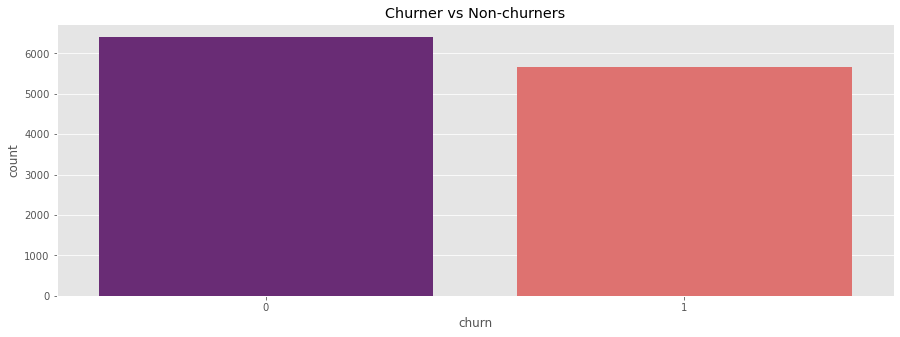

In [155]:
#Modified plot for churner vs churner
sns.countplot(x = 'churn',  data =encoded_data, palette = 'magma')
plt.title('Churner vs Non-churners')
plt.show()

### Continuous Data

In [156]:
#Display columns
cols

Index(['CustomerID', 'Quantity_sum', 'Quantity_mean', 'Quantity_median',
       'Quantity_min', 'Quantity_max', 'Profit_sum', 'Profit_mean',
       'Profit_median', 'Profit_min', 'Profit_max', 'Revenue_sum',
       'Revenue_mean', 'Revenue_median', 'Revenue_min', 'Revenue_max',
       'No of Days Elapsed_sum', 'No of Days Elapsed_mean',
       'No of Days Elapsed_median', 'No of Days Elapsed_min',
       'No of Days Elapsed_max', 'recency(days)', 'frequency',
       'monetary_value', 'RFMScore', 'RFM_score_total', 'RFM_Cluster',
       'Tenure_month', 'churn', 'BirthDate', 'CommuteDistance',
       'DateFirstPurchase', 'Gender', 'MaritalStatus', 'NumberCarsOwned',
       'NumberChildrenAtHome', 'TotalChildren', 'YearlyIncome', 'Education',
       'Occupation', 'Age', 'Age_group', 'income_group', 'HouseOwner',
       'SalesReasonType_Marketing', 'SalesReasonType_Other',
       'SalesReasonType_Promotion', 'SalesReason_Manufacturer',
       'SalesReason_On Promotion', 'SalesReason_Other'

In [157]:
#Display categorical variables
cat

['RFMScore',
 'RFM_score_total',
 'RFM_Cluster',
 'MaritalStatus',
 'Gender',
 'TotalChildren',
 'YearlyIncome',
 'NumberChildrenAtHome',
 'Occupation',
 'Education',
 'CommuteDistance',
 'NumberCarsOwned',
 'Age_group',
 'income_group',
 'HouseOwner',
 'SalesReasonType_Marketing',
 'SalesReasonType_Other',
 'SalesReasonType_Promotion',
 'SalesReason_Manufacturer',
 'SalesReason_On Promotion',
 'SalesReason_Other',
 'SalesReason_Price',
 'SalesReason_Quality',
 'SalesReason_Review',
 'SalesReason_Television  Advertisement']

In [158]:
#Display deleted columns
col_

['CustomerID',
 'Quantity_min',
 'Revenue_sum',
 'BirthDate',
 'No of Days Elapsed_sum',
 'No of Days Elapsed_mean',
 'No of Days Elapsed_median',
 'No of Days Elapsed_min',
 'No of Days Elapsed_max']

In [159]:
#Filter continuous variables
cont_ = [v for v in cols if v not in cat and v not in col_ and v != 'churn']

#Display conitnuous variables
cont_

['Quantity_sum',
 'Quantity_mean',
 'Quantity_median',
 'Quantity_max',
 'Profit_sum',
 'Profit_mean',
 'Profit_median',
 'Profit_min',
 'Profit_max',
 'Revenue_mean',
 'Revenue_median',
 'Revenue_min',
 'Revenue_max',
 'recency(days)',
 'frequency',
 'monetary_value',
 'Tenure_month',
 'DateFirstPurchase',
 'Age']

In [160]:
#Display data statistics
encoded_data[cont_].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity_sum,12075.0,3.166377,2.471651,1.000000,2.000000,3.000000,4.000000,68.000000
Quantity_mean,12075.0,2.219859,0.933536,1.000000,1.500000,2.000000,3.000000,8.000000
Quantity_median,12075.0,2.215487,0.947316,1.000000,1.500000,2.000000,3.000000,8.000000
Quantity_max,12075.0,2.531925,1.113132,1.000000,2.000000,2.000000,3.000000,8.000000
Profit_sum,12075.0,654.354011,863.347553,1.433500,26.467200,196.340400,1077.714000,5254.600000
Profit_mean,12075.0,384.692136,431.437255,1.433500,24.715975,196.340400,777.730650,1487.835600
Profit_median,12075.0,384.800910,432.113466,1.433500,24.401400,196.340400,797.694575,1487.835600
Profit_min,12075.0,322.520644,385.110490,1.433500,22.360600,196.340400,481.602900,1487.835600
Profit_max,12075.0,446.899919,509.802009,1.433500,25.027400,196.340400,924.563600,1487.835600
Revenue_mean,12075.0,942.406499,1067.468818,2.290000,39.980000,539.990000,1915.944800,3578.270000


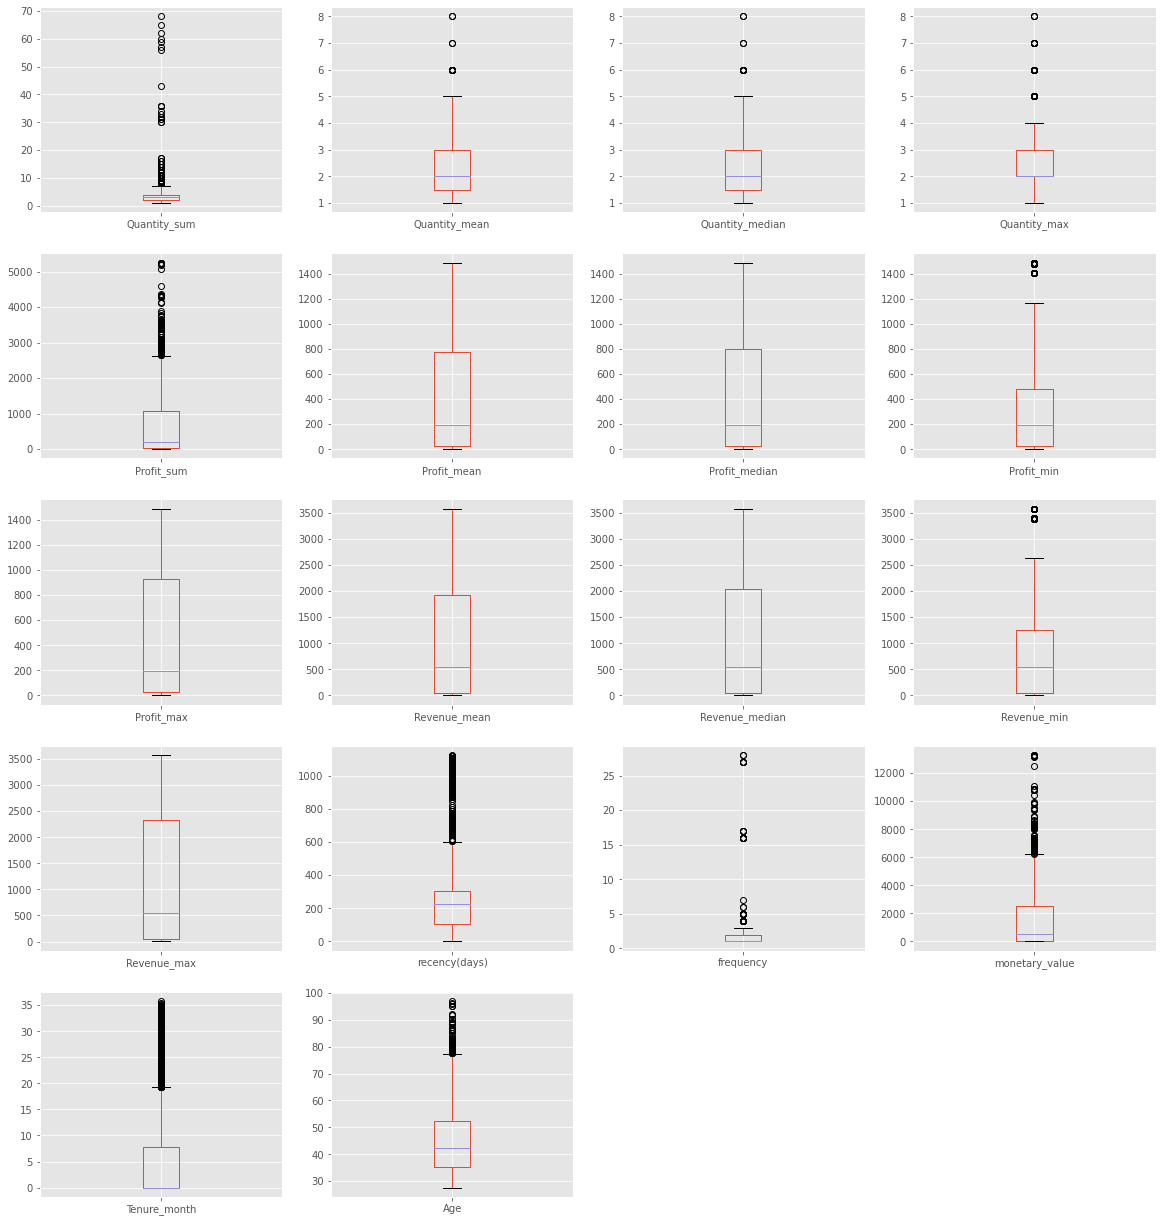

In [161]:
#Boxplots
encoded_data[cont_].plot(kind='box', subplots=True, figsize=(20,40),
                      layout=(9,4), sharex=False, sharey=False)
plt.show()

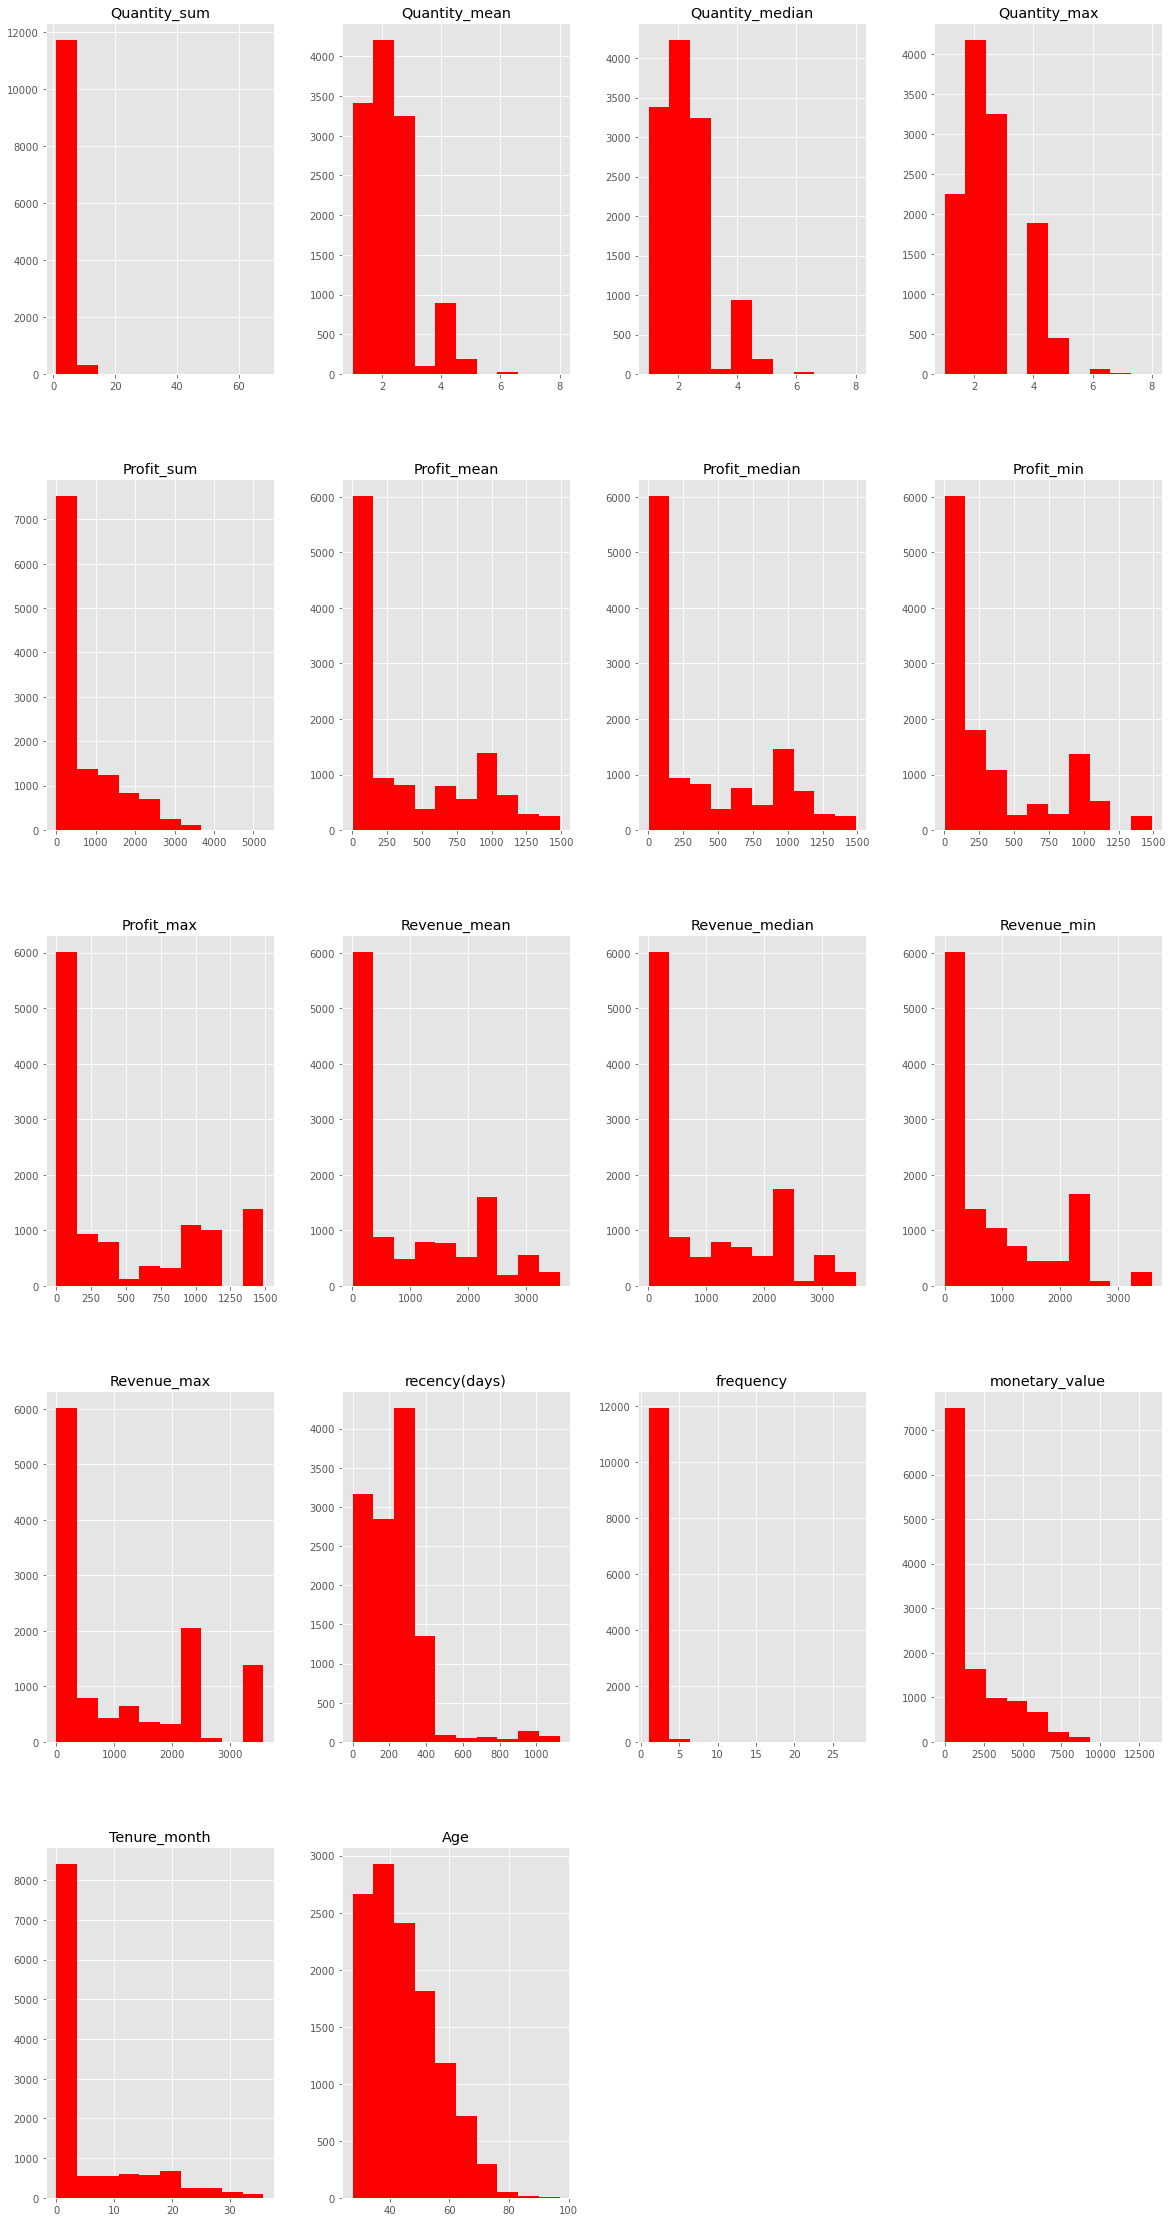

In [162]:
#Histogram
encoded_data[cont_].hist(figsize=(20,40), color = 'red')
pass

In [163]:
print(encoded_data.columns.tolist())

['Quantity_sum', 'Quantity_mean', 'Quantity_median', 'Quantity_max', 'Profit_sum', 'Profit_mean', 'Profit_median', 'Profit_min', 'Profit_max', 'Revenue_mean', 'Revenue_median', 'Revenue_min', 'Revenue_max', 'recency(days)', 'frequency', 'monetary_value', 'Tenure_month', 'churn', 'DateFirstPurchase', 'YearlyIncome', 'Age', 'SalesReasonType_Marketing', 'SalesReasonType_Other', 'SalesReasonType_Promotion', 'SalesReason_Manufacturer', 'SalesReason_On Promotion', 'SalesReason_Other', 'SalesReason_Price', 'SalesReason_Quality', 'SalesReason_Review', 'SalesReason_Television  Advertisement', 'RFM_Cluster_0', 'RFM_Cluster_1', 'RFM_Cluster_2', 'RFM_Cluster_3', 'RFM_Cluster_4', 'RFMScore_111', 'RFMScore_112', 'RFMScore_113', 'RFMScore_114', 'RFMScore_121', 'RFMScore_122', 'RFMScore_123', 'RFMScore_124', 'RFMScore_141', 'RFMScore_142', 'RFMScore_143', 'RFMScore_144', 'RFMScore_211', 'RFMScore_212', 'RFMScore_213', 'RFMScore_214', 'RFMScore_221', 'RFMScore_222', 'RFMScore_223', 'RFMScore_224', 'RFM

In [164]:
# Remove unnecessary data 
remove=['RFMScore_111', 'RFMScore_112', 'RFMScore_113', 'RFMScore_114', 'RFMScore_121',
        'RFMScore_122', 'RFMScore_123', 'RFMScore_124', 'RFMScore_141', 'RFMScore_142', 
        'RFMScore_143', 'RFMScore_144', 'RFMScore_211', 'RFMScore_212', 'RFMScore_213',
        'RFMScore_214', 'RFMScore_221', 'RFMScore_222', 'RFMScore_223', 'RFMScore_224',
        'RFMScore_241', 'RFMScore_242', 'RFMScore_243', 'RFMScore_244', 'RFMScore_311', 
        'RFMScore_312', 'RFMScore_313', 'RFMScore_321', 'RFMScore_322', 'RFMScore_323',
        'RFMScore_324', 'RFMScore_341', 'RFMScore_342', 'RFMScore_343', 'RFMScore_344',
        'RFMScore_411', 'RFMScore_413', 'RFMScore_421', 'RFMScore_422', 'RFMScore_423', 
        'RFMScore_424', 'RFMScore_441', 'RFMScore_442', 'RFMScore_443', 'RFMScore_444', 
        'RFM_score_total_3', 'RFM_score_total_4', 'RFM_score_total_5', 'RFM_score_total_6', 'RFM_score_total_7', 'RFM_score_total_8', 
        'RFM_score_total_9', 'RFM_score_total_10', 'RFM_score_total_11', 'RFM_score_total_12', 'Revenue_min', 'Revenue_max','Age','YearlyIncome','recency(days)',
        'frequency','monetary_value']
encoded_data = encoded_data.drop(remove, axis = 1)

In [165]:
encoded_data.columns

Index(['Quantity_sum', 'Quantity_mean', 'Quantity_median', 'Quantity_max',
       'Profit_sum', 'Profit_mean', 'Profit_median', 'Profit_min',
       'Profit_max', 'Revenue_mean', 'Revenue_median', 'Tenure_month', 'churn',
       'DateFirstPurchase', 'SalesReasonType_Marketing',
       'SalesReasonType_Other', 'SalesReasonType_Promotion',
       'SalesReason_Manufacturer', 'SalesReason_On Promotion',
       'SalesReason_Other', 'SalesReason_Price', 'SalesReason_Quality',
       'SalesReason_Review', 'SalesReason_Television  Advertisement',
       'RFM_Cluster_0', 'RFM_Cluster_1', 'RFM_Cluster_2', 'RFM_Cluster_3',
       'RFM_Cluster_4', 'MaritalStatus_M', 'MaritalStatus_S', 'Gender_F',
       'Gender_M', 'TotalChildren_0', 'TotalChildren_1', 'TotalChildren_2',
       'TotalChildren_3', 'TotalChildren_4', 'TotalChildren_5',
       'NumberChildrenAtHome_0', 'NumberChildrenAtHome_1',
       'NumberChildrenAtHome_2', 'NumberChildrenAtHome_3',
       'NumberChildrenAtHome_4', 'NumberChildren

### Feature Selection

In [166]:
encoded_data.head(10)

,Quantity_sum,Quantity_mean,Quantity_median,Quantity_max,Profit_sum,Profit_mean,Profit_median,Profit_min,Profit_max,Revenue_mean,...,Age_group_40s,Age_group_50s,Age_group_60s,Age_group_70+,income_group_Low,income_group_Mid,income_group_High,income_group_Very High,HouseOwner_Landlord,HouseOwner_Tenant
0,2,1.000,1.0,1,492.6238,246.311900,246.31190,196.3404,296.2834,661.490000,...,0,1,0,0,1,0,0,0,0,1
1,2,2.000,2.0,2,3.9312,3.931200,3.93120,3.9312,3.9312,6.280000,...,0,0,1,0,1,0,0,0,1,0
2,1,1.000,1.0,1,43.8137,43.813700,43.81370,43.8137,43.8137,69.990000,...,1,0,0,0,0,1,0,0,0,1
3,2,2.000,2.0,2,419.8279,419.827900,419.82790,419.8279,419.8279,1174.480000,...,0,0,0,0,0,1,0,0,1,0
4,4,2.000,2.0,3,2387.7791,1193.889550,1193.88955,910.8835,1476.8956,2886.520000,...,0,1,0,0,0,0,1,0,1,0
5,4,2.000,2.0,3,1696.6324,848.316200,848.31620,289.6566,1406.9758,2167.300000,...,1,0,0,0,0,0,1,0,0,1
6,3,3.000,3.0,3,115.4844,115.484400,115.48440,115.4844,115.4844,184.480000,...,0,0,0,1,1,0,0,0,0,1
7,4,4.000,4.0,4,447.4553,447.455300,447.45530,447.4553,447.4553,1184.460000,...,0,0,1,0,0,1,0,0,1,0
8,2,2.000,2.0,2,45.8814,45.881400,45.88140,45.8814,45.8814,78.980000,...,0,0,0,0,0,1,0,0,0,1
9,30,1.875,2.0,4,341.4799,21.342494,17.73140,1.4335,59.1444,40.891875,...,0,0,0,0,0,1,0,0,1,0


In [167]:
#check for missing values
encoded_data.isnull().sum()

Quantity_sum              0
Quantity_mean             0
Quantity_median           0
Quantity_max              0
Profit_sum                0
                         ..
income_group_Mid          0
income_group_High         0
income_group_Very High    0
HouseOwner_Landlord       0
HouseOwner_Tenant         0
Length: 77, dtype: int64

In [168]:
#check for duplicates
encoded_data.duplicated().sum()

4

In [169]:
#Drop duplicates 
encoded_data = encoded_data.drop_duplicates()

In [170]:
#Re-check for duplicates
encoded_data.duplicated().sum()

0

In [171]:
encoded_data.head()

,Quantity_sum,Quantity_mean,Quantity_median,Quantity_max,Profit_sum,Profit_mean,Profit_median,Profit_min,Profit_max,Revenue_mean,...,Age_group_40s,Age_group_50s,Age_group_60s,Age_group_70+,income_group_Low,income_group_Mid,income_group_High,income_group_Very High,HouseOwner_Landlord,HouseOwner_Tenant
0,2,1.0,1.0,1,492.6238,246.31190,246.31190,196.3404,296.2834,661.49,...,0,1,0,0,1,0,0,0,0,1
1,2,2.0,2.0,2,3.9312,3.93120,3.93120,3.9312,3.9312,6.28,...,0,0,1,0,1,0,0,0,1,0
2,1,1.0,1.0,1,43.8137,43.81370,43.81370,43.8137,43.8137,69.99,...,1,0,0,0,0,1,0,0,0,1
3,2,2.0,2.0,2,419.8279,419.82790,419.82790,419.8279,419.8279,1174.48,...,0,0,0,0,0,1,0,0,1,0
4,4,2.0,2.0,3,2387.7791,1193.88955,1193.88955,910.8835,1476.8956,2886.52,...,0,1,0,0,0,0,1,0,1,0


In [172]:
encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12071 entries, 0 to 12074
Data columns (total 77 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Quantity_sum                           12071 non-null  int64  
 1   Quantity_mean                          12071 non-null  float64
 2   Quantity_median                        12071 non-null  float64
 3   Quantity_max                           12071 non-null  int64  
 4   Profit_sum                             12071 non-null  float64
 5   Profit_mean                            12071 non-null  float64
 6   Profit_median                          12071 non-null  float64
 7   Profit_min                             12071 non-null  float64
 8   Profit_max                             12071 non-null  float64
 9   Revenue_mean                           12071 non-null  float64
 10  Revenue_median                         12071 non-null  float64
 11  Te

In [173]:
#Set target Variable
y = encoded_data.churn

In [174]:
#Features
X = encoded_data.drop("churn", axis=1)
X.head(10)

,Quantity_sum,Quantity_mean,Quantity_median,Quantity_max,Profit_sum,Profit_mean,Profit_median,Profit_min,Profit_max,Revenue_mean,...,Age_group_40s,Age_group_50s,Age_group_60s,Age_group_70+,income_group_Low,income_group_Mid,income_group_High,income_group_Very High,HouseOwner_Landlord,HouseOwner_Tenant
0,2,1.000,1.0,1,492.6238,246.311900,246.31190,196.3404,296.2834,661.490000,...,0,1,0,0,1,0,0,0,0,1
1,2,2.000,2.0,2,3.9312,3.931200,3.93120,3.9312,3.9312,6.280000,...,0,0,1,0,1,0,0,0,1,0
2,1,1.000,1.0,1,43.8137,43.813700,43.81370,43.8137,43.8137,69.990000,...,1,0,0,0,0,1,0,0,0,1
3,2,2.000,2.0,2,419.8279,419.827900,419.82790,419.8279,419.8279,1174.480000,...,0,0,0,0,0,1,0,0,1,0
4,4,2.000,2.0,3,2387.7791,1193.889550,1193.88955,910.8835,1476.8956,2886.520000,...,0,1,0,0,0,0,1,0,1,0
5,4,2.000,2.0,3,1696.6324,848.316200,848.31620,289.6566,1406.9758,2167.300000,...,1,0,0,0,0,0,1,0,0,1
6,3,3.000,3.0,3,115.4844,115.484400,115.48440,115.4844,115.4844,184.480000,...,0,0,0,1,1,0,0,0,0,1
7,4,4.000,4.0,4,447.4553,447.455300,447.45530,447.4553,447.4553,1184.460000,...,0,0,1,0,0,1,0,0,1,0
8,2,2.000,2.0,2,45.8814,45.881400,45.88140,45.8814,45.8814,78.980000,...,0,0,0,0,0,1,0,0,0,1
9,30,1.875,2.0,4,341.4799,21.342494,17.73140,1.4335,59.1444,40.891875,...,0,0,0,0,0,1,0,0,1,0


In [175]:
#Get list of all features
col = encoded_data.columns
print(col)

Index(['Quantity_sum', 'Quantity_mean', 'Quantity_median', 'Quantity_max',
       'Profit_sum', 'Profit_mean', 'Profit_median', 'Profit_min',
       'Profit_max', 'Revenue_mean', 'Revenue_median', 'Tenure_month', 'churn',
       'DateFirstPurchase', 'SalesReasonType_Marketing',
       'SalesReasonType_Other', 'SalesReasonType_Promotion',
       'SalesReason_Manufacturer', 'SalesReason_On Promotion',
       'SalesReason_Other', 'SalesReason_Price', 'SalesReason_Quality',
       'SalesReason_Review', 'SalesReason_Television  Advertisement',
       'RFM_Cluster_0', 'RFM_Cluster_1', 'RFM_Cluster_2', 'RFM_Cluster_3',
       'RFM_Cluster_4', 'MaritalStatus_M', 'MaritalStatus_S', 'Gender_F',
       'Gender_M', 'TotalChildren_0', 'TotalChildren_1', 'TotalChildren_2',
       'TotalChildren_3', 'TotalChildren_4', 'TotalChildren_5',
       'NumberChildrenAtHome_0', 'NumberChildrenAtHome_1',
       'NumberChildrenAtHome_2', 'NumberChildrenAtHome_3',
       'NumberChildrenAtHome_4', 'NumberChildren

In [176]:
X["DateFirstPurchase"].head()

0    2012-11-30
1    2013-08-30
2    2013-07-17
3    2013-08-18
4    2011-04-10
Name: DateFirstPurchase, dtype: object

In [177]:
X["DateFirstPurchase"] = X["DateFirstPurchase"].str.replace("-","").astype(int)

In [178]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12071 entries, 0 to 12074
Data columns (total 76 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Quantity_sum                           12071 non-null  int64  
 1   Quantity_mean                          12071 non-null  float64
 2   Quantity_median                        12071 non-null  float64
 3   Quantity_max                           12071 non-null  int64  
 4   Profit_sum                             12071 non-null  float64
 5   Profit_mean                            12071 non-null  float64
 6   Profit_median                          12071 non-null  float64
 7   Profit_min                             12071 non-null  float64
 8   Profit_max                             12071 non-null  float64
 9   Revenue_mean                           12071 non-null  float64
 10  Revenue_median                         12071 non-null  float64
 11  Te

#### Weight of Eveidence (WOE) and Information Value

In [179]:
#pip install xverse

In [180]:
#Import library of WOE
from xverse.transformer import WOE

In [181]:
#initialize weight of evidence and information value
info_value= WOE()
#Fit data
info_value.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


WOE(mono_custom_binning={'Age_group_30s': array([0., 1.]),
                         'Age_group_40s': array([0., 1.]),
                         'Age_group_50s': array([0., 1.]),
                         'Age_group_60s': array([0., 1.]),
                         'Age_group_70+': array([0., 1.]),
                         'Age_group_<30s': array([0., 1.]),
                         'CommuteDistance_0-1 Miles': array([0., 1.]),
                         'CommuteDistance_1-2 Miles': array([0., 1.]),
                         'CommuteDistance_10+ Miles': array([0., 1.]),
                         'CommuteDist...
              'NumberCarsOwned_2': {0: -0.016643579132125705,
                                    1: 0.031146685915598268},
              'NumberCarsOwned_3': {0: 0.012984556583934022,
                                    1: -0.13742040273522943},
              'NumberCarsOwned_4': {0: 0.01154730101863463,
                                    1: -0.16482151903304365},
              'NumberChildrenAtHome_0': {0: -0.06579365522573373,
                                         1: 0.042154675994047555},
              'NumberChildrenAtHome_1': {0: 0.006375020602258648,
                                         1: -0.041281220555843774}, ...})

In [182]:
#Weight of evidence transformation dataset
info_value.woe_df.head(10)

,Variable_Name,Category,Count,Event,Non_Event,Event_Rate,Non_Event_Rate,Event_Distribution,Non_Event_Distribution,WOE,Information_Value
0,Age_group_30s,0,7820,3677,4143,0.470205,0.529795,0.649302,0.646536,0.004270,0.000034
1,Age_group_30s,1,4251,1986,2265,0.467184,0.532816,0.350698,0.353464,-0.007859,0.000034
2,Age_group_40s,0,8601,4032,4569,0.468783,0.531217,0.711990,0.713015,-0.001438,0.000005
3,Age_group_40s,1,3470,1631,1839,0.470029,0.529971,0.288010,0.286985,0.003565,0.000005
4,Age_group_50s,0,9885,4655,5230,0.470916,0.529084,0.822002,0.816167,0.007124,0.000230
5,Age_group_50s,1,2186,1008,1178,0.461116,0.538884,0.177998,0.183833,-0.032256,0.000230
6,Age_group_60s,0,10955,5136,5819,0.468827,0.531173,0.906940,0.908084,-0.001260,0.000016
7,Age_group_60s,1,1116,527,589,0.472222,0.527778,0.093060,0.091916,0.012368,0.000016
8,Age_group_70+,0,11749,5514,6235,0.469317,0.530683,0.973689,0.973002,0.000705,0.000018
9,Age_group_70+,1,322,149,173,0.462733,0.537267,0.026311,0.026998,-0.025752,0.000018


In [183]:
#information value dataset, Iv=(Event-Non-Event%) = WOE
iv_df=info_value.iv_df
iv_df

,Variable_Name,Information_Value
11,DateFirstPurchase,1.221591
49,RFM_Cluster_1,0.254988
52,RFM_Cluster_4,0.188423
65,Tenure_month,0.148704
47,Quantity_sum,0.116029
...,...,...
69,TotalChildren_3,0.000028
4,Age_group_70+,0.000018
3,Age_group_60s,0.000016
13,Education_Graduate Degree,0.000015


In [184]:
#Rename Variable_Name to index (to be used later in voting section)
iv_df.rename(columns={"Variable_Name":"index"}, inplace=True)
iv_df

,index,Information_Value
11,DateFirstPurchase,1.221591
49,RFM_Cluster_1,0.254988
52,RFM_Cluster_4,0.188423
65,Tenure_month,0.148704
47,Quantity_sum,0.116029
...,...,...
69,TotalChildren_3,0.000028
4,Age_group_70+,0.000018
3,Age_group_60s,0.000016
13,Education_Graduate Degree,0.000015


#### Random Forest

In [185]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

In [186]:
#Initialize Random Forest
rf=RandomForestClassifier(random_state = seed)
# Fit data
rf.fit(X,y)
# produce predictions
preds=rf.predict(X)
# Calculate accuracy
accuracy = accuracy_score(preds,y)
print(accuracy)

1.0


In [187]:
# Create a dataframe with variable importance scores
rf_df = pd.DataFrame(rf.feature_importances_, columns = ["RF"], index = X.columns)
rf_df = rf_df.reset_index()
rf_df.sort_values(['RF'], ascending=0)

,index,RF
12,DateFirstPurchase,0.420694
11,Tenure_month,0.083172
23,RFM_Cluster_0,0.050632
26,RFM_Cluster_3,0.048052
4,Profit_sum,0.034211
...,...,...
22,SalesReason_Television Advertisement,0.001070
42,NumberChildrenAtHome_4,0.000924
13,SalesReasonType_Marketing,0.000679
69,Age_group_70+,0.000579


#### Recursive feature elimination (RFE)

In [188]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
log_reg= LogisticRegression(random_state=seed)
rfe =RFE(estimator=log_reg, step=1)
rfe.fit(X, y)

RFE(estimator=LogisticRegression(random_state=0))

In [189]:
rfe_df = pd.DataFrame(rfe.support_, columns = ["RFE"], index = X.columns)
rfe_df =rfe_df.reset_index()
rfe_df[rfe_df["RFE"]== True]

,index,RFE
0,Quantity_sum,True
1,Quantity_mean,True
2,Quantity_median,True
3,Quantity_max,True
4,Profit_sum,True
5,Profit_mean,True
6,Profit_median,True
7,Profit_min,True
8,Profit_max,True
9,Revenue_mean,True


#### Extra Trees

In [190]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import make_classification
etc=ExtraTreesClassifier(random_state=seed)
etc.fit(X,y)
etc_df=pd.DataFrame(etc.feature_importances_, columns= ["Extra_trees"], index=X.columns)
etc_df=etc_df.reset_index()
etc_df.sort_values(["Extra_trees"], ascending=0)

,index,Extra_trees
12,DateFirstPurchase,0.203657
26,RFM_Cluster_3,0.077543
23,RFM_Cluster_0,0.064098
24,RFM_Cluster_1,0.040272
11,Tenure_month,0.035023
...,...,...
43,NumberChildrenAtHome_5,0.002168
69,Age_group_70+,0.001938
14,SalesReasonType_Other,0.001601
22,SalesReason_Television Advertisement,0.001502


#### Chi-Square

In [191]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import chi2

In [192]:
KBest = SelectKBest(score_func=chi2, k=5)
chi_sq = KBest.fit(X, y)
pd.options.display.float_format = '{:.2f}'.format
chi_sq_df = pd.DataFrame(chi_sq.scores_, columns=['Chi_square'], index =X.columns)
chi_sq_df = chi_sq_df.reset_index()
chi_sq_df.sort_values('Chi_square', ascending=0)

,index,Chi_square
10,Revenue_median,57937.26
9,Revenue_mean,55411.65
7,Profit_min,36032.87
4,Profit_sum,33659.72
6,Profit_median,15742.98
...,...,...
65,Age_group_30s,0.07
69,Age_group_70+,0.05
68,Age_group_60s,0.04
50,Education_Graduate Degree,0.04


#### L1

In [193]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

In [194]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
l1 = SelectFromModel(lsvc,prefit=True)
l1_df = pd.DataFrame(l1.get_support(), columns = ["L1"], index = X.columns)
l1_df = l1_df.reset_index()
l1_df[l1_df['L1'] == True]

C:\Users\MMT\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,index,L1
0,Quantity_sum,True
3,Quantity_max,True
4,Profit_sum,True
5,Profit_mean,True
6,Profit_median,True
7,Profit_min,True
8,Profit_max,True
9,Revenue_mean,True
10,Revenue_median,True
11,Tenure_month,True


### Feature voting

In [195]:
from functools import reduce

In [196]:
# Combine altogether
dfs = [iv_df, rf_df, rfe_df, etc_df, chi_sq_df, l1_df]
summary = reduce(lambda left,right: pd.merge(left,right,on='index'), dfs)
summary.head()

,index,Information_Value,RF,RFE,Extra_trees,Chi_square,L1
0,DateFirstPurchase,1.22,0.42,True,0.20,257.78,False
1,RFM_Cluster_1,0.25,0.03,True,0.04,493.95,True
2,RFM_Cluster_4,0.19,0.02,True,0.02,439.67,False
3,Tenure_month,0.15,0.08,True,0.04,6121.00,True
4,Quantity_sum,0.12,0.02,True,0.01,732.71,True


In [197]:
# Calculate scores
# Filter columns with non-binary values
columns = ['Information_Value', 'RF', 'Extra_trees', 'Chi_square']

score_table = pd.DataFrame({},[])
score_table['index'] = summary['index']

# Assign 1 if the score is in the top 5, else 0
for i in columns:
    score_table[i] = summary['index'].isin(list(summary.nlargest(5,i)['index'])).astype(int)

# Convert True to 1 and False to 0
score_table['RFE'] = summary['RFE'].astype(int)
score_table['L1'] = summary['L1'].astype(int)

In [198]:
score_table['Final_score']= score_table.sum(axis=1)
score_table.sort_values('Final_score', ascending=0)

,index,Information_Value,RF,Extra_trees,Chi_square,RFE,L1,Final_score
3,Tenure_month,1,1,1,0,1,1,5
0,DateFirstPurchase,1,1,1,0,1,0,4
12,Profit_sum,0,1,0,1,1,1,4
1,RFM_Cluster_1,1,0,1,0,1,1,4
6,RFM_Cluster_3,0,1,1,0,1,1,4
...,...,...,...,...,...,...,...,...
50,Occupation_Manual,0,0,0,0,0,0,0
51,Age_group_<30s,0,0,0,0,0,0,0
32,income_group_Very High,0,0,0,0,0,0,0
56,income_group_Low,0,0,0,0,0,0,0


### Multicollinearity check

In [199]:
# Filter variables with score >= 2
select_var = X[list(score_table[score_table['Final_score'] >= 2]['index'])] 

In [200]:
from statsmodels.stats import outliers_influence
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [201]:
def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
    return(vif)

vif = calculate_vif(select_var)
vif

,Features,VIF
0,DateFirstPurchase,28.68
1,RFM_Cluster_1,7.27
2,RFM_Cluster_4,5.05
3,Tenure_month,8.70
4,Quantity_sum,5.86
5,RFM_Cluster_3,3.00
6,RFM_Cluster_0,1.86
7,SalesReason_Quality,2.33
8,Quantity_max,10.48
9,Profit_sum,20.13


In [202]:
# Narrow down the features until their VIF is equal to or lower than 5
while vif['VIF'][vif['VIF'] > 5].any():
    remove = vif.sort_values('VIF',ascending=0)['Features'][:1]
    select_var.drop(remove,axis=1,inplace=True)
    vif = calculate_vif(select_var)

vif

,Features,VIF
0,RFM_Cluster_1,1.92
1,RFM_Cluster_4,2.65
2,Tenure_month,3.65
3,Quantity_sum,2.86
4,RFM_Cluster_3,1.39
5,RFM_Cluster_0,1.51
6,SalesReason_Quality,1.82
7,Profit_min,3.61
8,income_group_Mid,3.15
9,income_group_High,2.01


In [203]:
final_features = vif['Features']

In [204]:
# Create the final dataframe with all selected features and label
final_var = list(vif['Features']) + ['churn']
final_df = encoded_data[final_var]
final_df.head()

,RFM_Cluster_1,RFM_Cluster_4,Tenure_month,Quantity_sum,RFM_Cluster_3,RFM_Cluster_0,SalesReason_Quality,Profit_min,income_group_Mid,income_group_High,Occupation_Skilled Manual,churn
0,0,0,12.48,2,0,1,0,196.34,0,0,0,0
1,1,0,0.00,2,0,0,0,3.93,0,0,0,0
2,1,0,0.00,1,0,0,0,43.81,1,0,1,0
3,0,1,0.00,2,0,0,0,419.83,1,0,1,0
4,0,0,25.86,4,0,0,0,910.88,0,1,1,0


In [205]:
#Check for correlation between variables
corr = final_df.corr()
corr

,RFM_Cluster_1,RFM_Cluster_4,Tenure_month,Quantity_sum,RFM_Cluster_3,RFM_Cluster_0,SalesReason_Quality,Profit_min,income_group_Mid,income_group_High,Occupation_Skilled Manual,churn
RFM_Cluster_1,1.00,-0.36,-0.42,-0.27,-0.27,-0.25,-0.23,-0.55,-0.03,-0.04,-0.01,0.25
RFM_Cluster_4,-0.36,1.00,-0.29,-0.15,-0.18,-0.17,-0.00,0.44,0.17,-0.09,0.08,0.21
Tenure_month,-0.42,-0.29,1.00,0.35,-0.22,0.35,0.53,0.37,-0.11,0.10,-0.05,-0.19
Quantity_sum,-0.27,-0.15,0.35,1.00,-0.10,0.36,0.04,0.06,-0.06,0.08,-0.03,-0.18
RFM_Cluster_3,-0.27,-0.18,-0.22,-0.10,1.00,-0.13,-0.12,-0.12,0.01,-0.00,-0.00,-0.35
RFM_Cluster_0,-0.25,-0.17,0.35,0.36,-0.13,1.00,0.01,-0.04,-0.03,0.04,-0.01,-0.33
SalesReason_Quality,-0.23,-0.00,0.53,0.04,-0.12,0.01,1.00,0.46,-0.01,0.04,0.02,0.11
Profit_min,-0.55,0.44,0.37,0.06,-0.12,-0.04,0.46,1.00,-0.00,0.08,0.02,0.08
income_group_Mid,-0.03,0.17,-0.11,-0.06,0.01,-0.03,-0.01,-0.00,1.00,-0.60,0.32,0.05
income_group_High,-0.04,-0.09,0.10,0.08,-0.00,0.04,0.04,0.08,-0.60,1.00,-0.08,-0.05


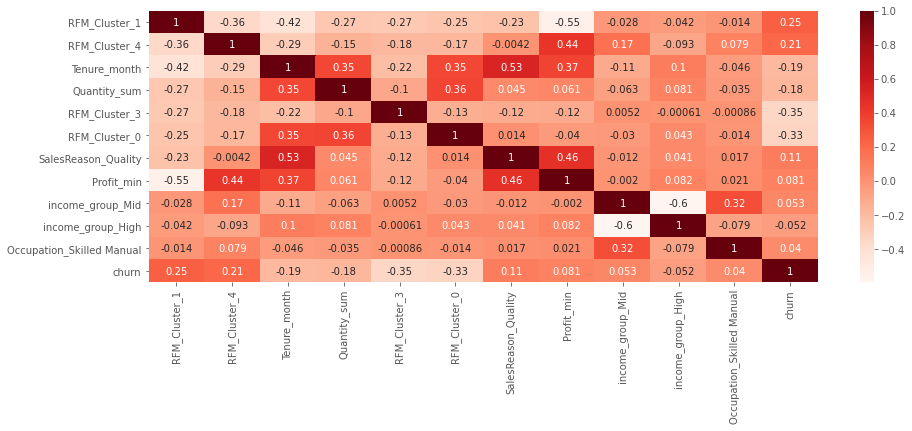

In [206]:
# Plot heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=plt.cm.Reds)
pass

In [207]:
#Split the data into train and test data
X = final_df.loc[:, final_df.columns != 'churn']
y = final_df['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=30,test_size=0.3)
X_train.shape, X_test.shape

((8449, 11), (3622, 11))

In [208]:
X_train.corr()

,RFM_Cluster_1,RFM_Cluster_4,Tenure_month,Quantity_sum,RFM_Cluster_3,RFM_Cluster_0,SalesReason_Quality,Profit_min,income_group_Mid,income_group_High,Occupation_Skilled Manual
RFM_Cluster_1,1.00,-0.36,-0.42,-0.26,-0.27,-0.25,-0.24,-0.55,-0.01,-0.05,-0.01
RFM_Cluster_4,-0.36,1.00,-0.29,-0.15,-0.19,-0.17,-0.01,0.43,0.17,-0.09,0.08
Tenure_month,-0.42,-0.29,1.00,0.35,-0.22,0.35,0.54,0.36,-0.11,0.10,-0.05
Quantity_sum,-0.26,-0.15,0.35,1.00,-0.11,0.36,0.05,0.06,-0.07,0.08,-0.03
RFM_Cluster_3,-0.27,-0.19,-0.22,-0.11,1.00,-0.13,-0.12,-0.11,-0.01,0.01,-0.01
RFM_Cluster_0,-0.25,-0.17,0.35,0.36,-0.13,1.00,0.02,-0.04,-0.04,0.04,-0.01
SalesReason_Quality,-0.24,-0.01,0.54,0.05,-0.12,0.02,1.00,0.45,-0.01,0.05,0.01
Profit_min,-0.55,0.43,0.36,0.06,-0.11,-0.04,0.45,1.00,-0.01,0.09,0.02
income_group_Mid,-0.01,0.17,-0.11,-0.07,-0.01,-0.04,-0.01,-0.01,1.00,-0.60,0.32
income_group_High,-0.05,-0.09,0.10,0.08,0.01,0.04,0.05,0.09,-0.60,1.00,-0.08


<ipython-input-209-24061a9f784a>:5: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


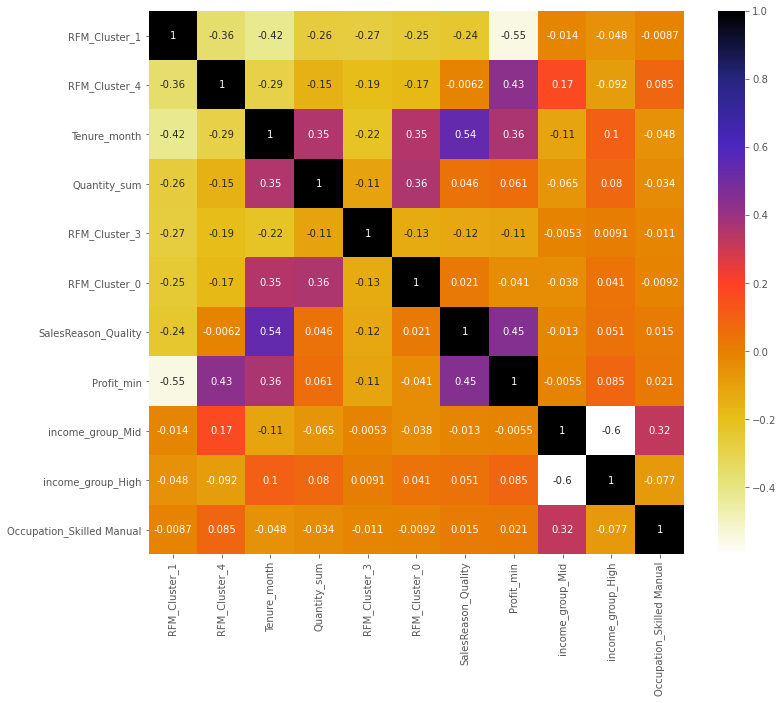

In [209]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = X_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [210]:
#Determine and select highly correlated features using the function below 

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [211]:
corr_features = correlation(X_train, 0.80)
len(set(corr_features))

0

In [212]:
corr_features

set()

In [213]:
X_train = X_train.drop(corr_features,axis=1)
X_test = X_test.drop(corr_features,axis=1)

### Model Selection

#### Decision Trees

In [214]:
#import relevant libraries
from sklearn.tree import DecisionTreeClassifier

In [215]:
# Fit the training set in the Decsion Tree
tree = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=30, min_samples_leaf=5)
tree.fit(X_train, y_train)

# Predict train set
train_pred = tree.predict(X_train)
# Predict test set
test_pred= tree.predict(X_test)

# Calculate scores
train_acc = 100*tree.score(X_train, y_train)
test_acc = 100*tree.score(X_test, y_test) 
train_f1 = 100*fbeta_score(y_train, train_pred, beta = 1)
test_f1 = 100*fbeta_score(y_test, test_pred, beta = 1)

# Gather the results in a dataframe
# Create a list with the metric names
metrics = ['train_accuracy', 'test_accuracy', 'train_f1_score', 'test_f1_score']
# Create an array with the score values
scores = np.array([train_acc, test_acc, train_f1, test_f1])
#Create the dataframe
pd.options.display.float_format = '{:.2f}'.format
DT_df = pd.DataFrame(scores, columns = ['Decision_tree'], index = metrics).reset_index()
DT_df

,index,Decision_tree
0,train_accuracy,71.80
1,test_accuracy,71.59
2,train_f1_score,73.13
3,test_f1_score,73.25


In [216]:
print("Accuracy = "+ str(accuracy_score(y_test,test_pred)))
print("F1 Score = " + str(f1_score(y_test,test_pred)))
print(classification_report(y_test, test_pred))

Accuracy = 0.7159028161236886
F1 Score = 0.7325188458539121
              precision    recall  f1-score   support

           0       0.80      0.62      0.70      1920
           1       0.66      0.83      0.73      1702

    accuracy                           0.72      3622
   macro avg       0.73      0.72      0.71      3622
weighted avg       0.73      0.72      0.71      3622



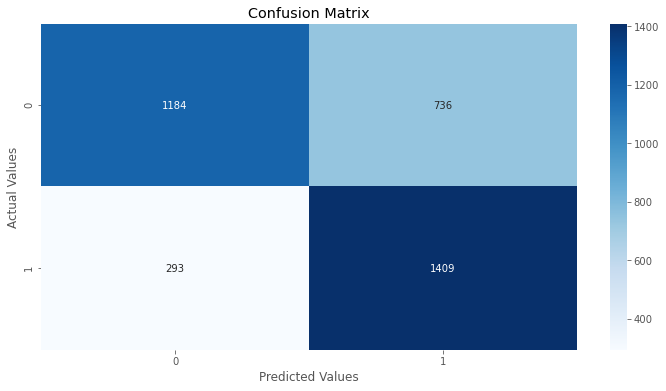

In [217]:
cm=confusion_matrix(y_test,test_pred)
plt.figure(figsize=(12,6))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True,fmt='d', cmap='Blues')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.savefig('confusion_matrix.png')

#### Random Forest

In [218]:
#Import Random Forest library
from sklearn.ensemble import RandomForestClassifier

In [219]:
# Train the model with the data
rf = RandomForestClassifier (n_estimators=700, random_state = 30)

rf.fit(X_train, y_train)

# Predict train and test sets
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

#calculate scores
train_acc = 100*rf.score(X_train, y_train)
test_acc = 100*rf.score(X_test, y_test) 
train_f1 = 100*fbeta_score(y_train, train_pred, beta = 1)
test_f1 = 100*fbeta_score(y_test, test_pred, beta = 1)

# Gather the results in a dataframe
# Create a list with the metric names
metrics = ['train_accuracy', 'test_accuracy', 'train_f1_score', 'test_f1_score']
# Create an array with the score values
scores = np.array([train_acc, test_acc, train_f1, test_f1])

#Create the dataframe
pd.options.display.float_format = '{:.2f}'.format
RF_df = pd.DataFrame(scores, columns = ['Random_Forest'], index = metrics).reset_index()
RF_df

,index,Random_Forest
0,train_accuracy,88.44
1,test_accuracy,73.96
2,train_f1_score,88.31
3,test_f1_score,74.01


In [220]:
print("Accuracy = "+ str(accuracy_score(y_test,test_pred)))
print("F1 Score = " + str(f1_score(y_test,test_pred)))
print(classification_report(y_test, test_pred))

Accuracy = 0.7396466040861402
F1 Score = 0.7401488013226785
              precision    recall  f1-score   support

           0       0.79      0.70      0.74      1920
           1       0.70      0.79      0.74      1702

    accuracy                           0.74      3622
   macro avg       0.74      0.74      0.74      3622
weighted avg       0.75      0.74      0.74      3622



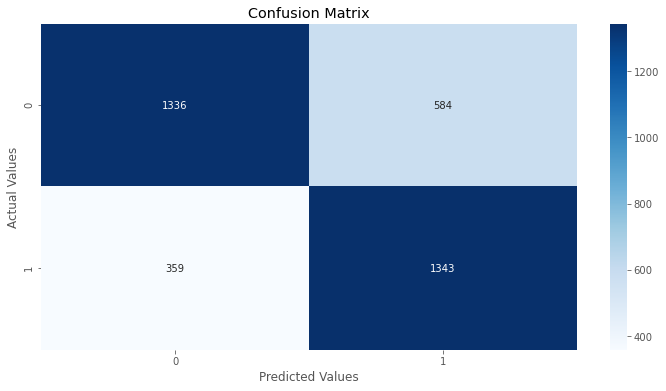

In [221]:
cm=confusion_matrix(y_test,test_pred)
plt.figure(figsize=(12,6))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True,fmt='d', cmap='Blues')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.savefig('confusion_matrix.png')

#### Logistic Regression 

In [222]:
# Import libraries
from sklearn.linear_model import LogisticRegression

In [223]:
#Train Model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

train_pred = log_reg.predict(X_train)
test_pred = log_reg.predict(X_test)

train_acc = 100*log_reg.score(X_train, y_train)
test_acc = 100*log_reg.score(X_test, y_test) 
train_f1 = 100*fbeta_score(y_train, train_pred, beta = 1)
test_f1 = 100*fbeta_score(y_test, test_pred, beta = 1)

scores = np.array([train_acc, test_acc, train_f1, test_f1])
LR_df = pd.DataFrame(scores, columns = ['Logistic_regression'], index = metrics).reset_index()
LR_df

C:\Users\MMT\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,index,Logistic_regression
0,train_accuracy,72.21
1,test_accuracy,72.00
2,train_f1_score,74.20
3,test_f1_score,73.99


In [224]:
print("Accuracy = "+ str(accuracy_score(y_test,test_pred)))
print("F1 Score = " + str(f1_score(y_test,test_pred)))
print(classification_report(y_test, test_pred))

Accuracy = 0.7200441744892324
F1 Score = 0.7398665982555156
              precision    recall  f1-score   support

           0       0.82      0.61      0.70      1920
           1       0.66      0.85      0.74      1702

    accuracy                           0.72      3622
   macro avg       0.74      0.73      0.72      3622
weighted avg       0.74      0.72      0.72      3622



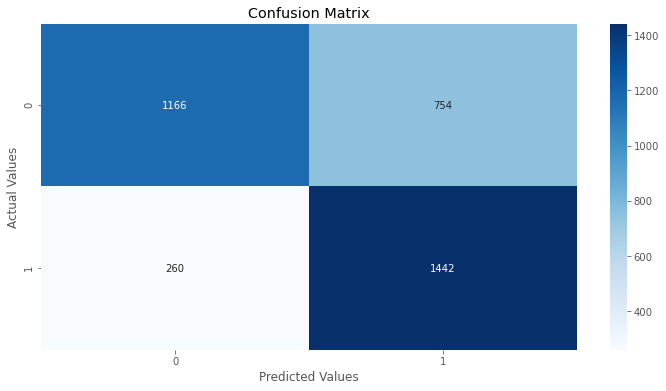

In [225]:
cm=confusion_matrix(y_test,test_pred)
plt.figure(figsize=(12,6))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True,fmt='d', cmap='Blues')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.savefig('confusion_matrix.png')

#### K-Nearest Neighbour

In [226]:
# import libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing

In [227]:
# Scale data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

#Scale data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)

In [228]:
#Select k
training_F1 = []
test_F1 = []

# Try n_neighbours from 1 to 10
neighbors_settings = range(1, 11)

# Run the model for different n_neighbours
for k in neighbors_settings:
    # Build the model
    knn = KNeighborsClassifier(n_neighbors = k, metric = 'minkowski', p = 2)
    # Use scaled data
    knn.fit(X_train_scaled, y_train)

    # Predict train set
    train_pred = knn.predict(X_train_scaled)
    # Predict test set
    test_pred = knn.predict(X_test_scaled)
    
    # Record training set F1 score
    training_F1.append(fbeta_score(y_train, train_pred, beta = 1))
    # Record test set F1 score - More important than training accuracy
    test_F1.append(fbeta_score(y_test, test_pred, beta = 1))

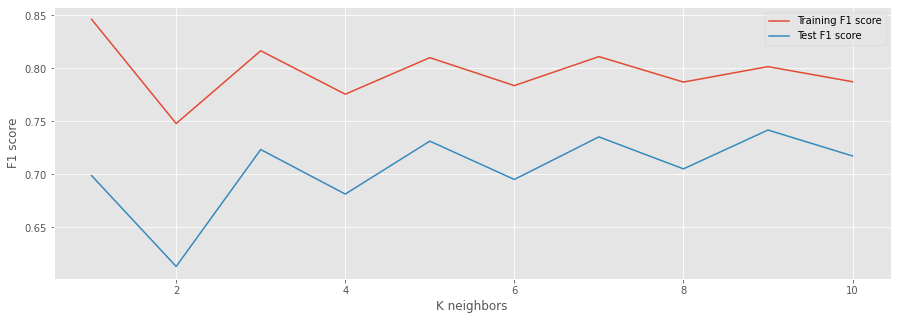

In [229]:
# Plot training and test F1 score
plt.plot(neighbors_settings, training_F1, label = "Training F1 score")
plt.plot(neighbors_settings, test_F1, label = "Test F1 score")
plt.ylabel("F1 score")
plt.xlabel("K neighbors")
plt.legend()
pass

In [230]:
# I choose k = 8 where fluctuation almost flattens and F1 score on sets doesn't vary significantly
knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(X_train_scaled, y_train)

train_pred = knn.predict(X_train_scaled)
test_pred = knn.predict(X_test_scaled)

train_acc = 100*knn.score(X_train_scaled, y_train)
test_acc = 100*knn.score(X_test_scaled, y_test) 
train_f1 = 100*fbeta_score(y_train, train_pred, beta = 1)
test_f1 = 100*fbeta_score(y_test, test_pred, beta = 1)

scores = np.array([train_acc, test_acc, train_f1, test_f1])
KNN_df = pd.DataFrame(scores, columns = ['KNN'], index = metrics).reset_index()
KNN_df

,index,KNN
0,train_accuracy,79.89
1,test_accuracy,71.73
2,train_f1_score,78.71
3,test_f1_score,70.52


In [231]:
knn_acc = print("Accuracy = "+ str(accuracy_score(y_test,test_pred)))
knn_f1 = print("F1 Score = " + str(f1_score(y_test,test_pred)))
print(classification_report(y_test, test_pred))

Accuracy = 0.7172832689122032
F1 Score = 0.7052389176741508
              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1920
           1       0.69      0.72      0.71      1702

    accuracy                           0.72      3622
   macro avg       0.72      0.72      0.72      3622
weighted avg       0.72      0.72      0.72      3622



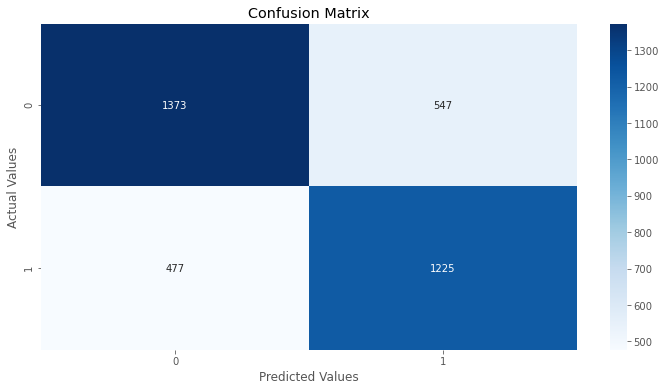

In [232]:
cm=confusion_matrix(y_test,test_pred)
plt.figure(figsize=(12,6))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True,fmt='d', cmap='Blues')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.savefig('confusion_matrix.png')

#### Naive Bayes

In [233]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [234]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

train_pred = gnb.predict(X_train)
test_pred = gnb.predict(X_test)

train_acc = 100*gnb.score(X_train, y_train)
test_acc = 100*gnb.score(X_test, y_test) 
train_f1 = 100*fbeta_score(y_train, train_pred, beta = 1)
test_f1 = 100*fbeta_score(y_test, test_pred, beta = 1)

scores = np.array([train_acc, test_acc, train_f1, test_f1])
NB_df = pd.DataFrame(scores, columns = ['Naive_bayes'], index = metrics).reset_index()
NB_df

,index,Naive_bayes
0,train_accuracy,70.09
1,test_accuracy,69.13
2,train_f1_score,75.81
3,test_f1_score,75.28


In [235]:
print("Accuracy = "+ str(accuracy_score(y_test,test_pred)))
print("F1 Score = " + str(f1_score(y_test,test_pred)))
print(classification_report(y_test, test_pred))

Accuracy = 0.6913307564881281
F1 Score = 0.7527642636001769
              precision    recall  f1-score   support

           0       1.00      0.42      0.59      1920
           1       0.60      1.00      0.75      1702

    accuracy                           0.69      3622
   macro avg       0.80      0.71      0.67      3622
weighted avg       0.81      0.69      0.67      3622



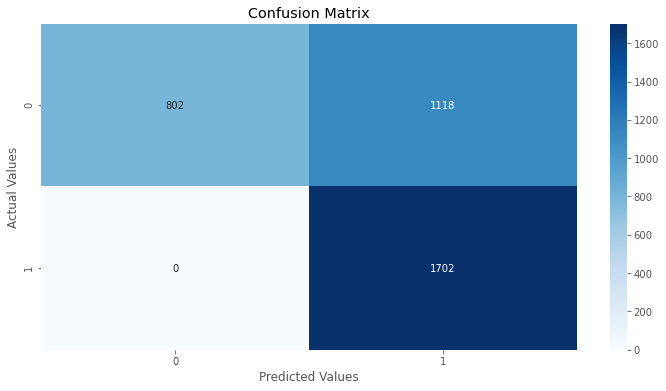

In [236]:
cm=confusion_matrix(y_test,test_pred)
plt.figure(figsize=(12,6))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True,fmt='d', cmap='Blues')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.savefig('confusion_matrix.png')

### Winning Model

In [237]:
# Create a dataframe with scores
# Combine altogether
dfs = [DT_df, RF_df, LR_df, KNN_df, NB_df]
summary = reduce(lambda left,right: pd.merge(left, right, on = 'index'), dfs)
summary

,index,Decision_tree,Random_Forest,Logistic_regression,KNN,Naive_bayes
0,train_accuracy,71.80,88.44,72.21,79.89,70.09
1,test_accuracy,71.59,73.96,72.00,71.73,69.13
2,train_f1_score,73.13,88.31,74.20,78.71,75.81
3,test_f1_score,73.25,74.01,73.99,70.52,75.28


In [238]:
# Filter F1 scores
f1_summary = summary.iloc[3:,:]
f1_summary = f1_summary.transpose()
f1_summary.columns = f1_summary.iloc[0]
f1_summary.drop(f1_summary.index[0], inplace = True)
f1_summary

index,test_f1_score
Decision_tree,73.25
Random_Forest,74.01
Logistic_regression,73.99
KNN,70.52
Naive_bayes,75.28


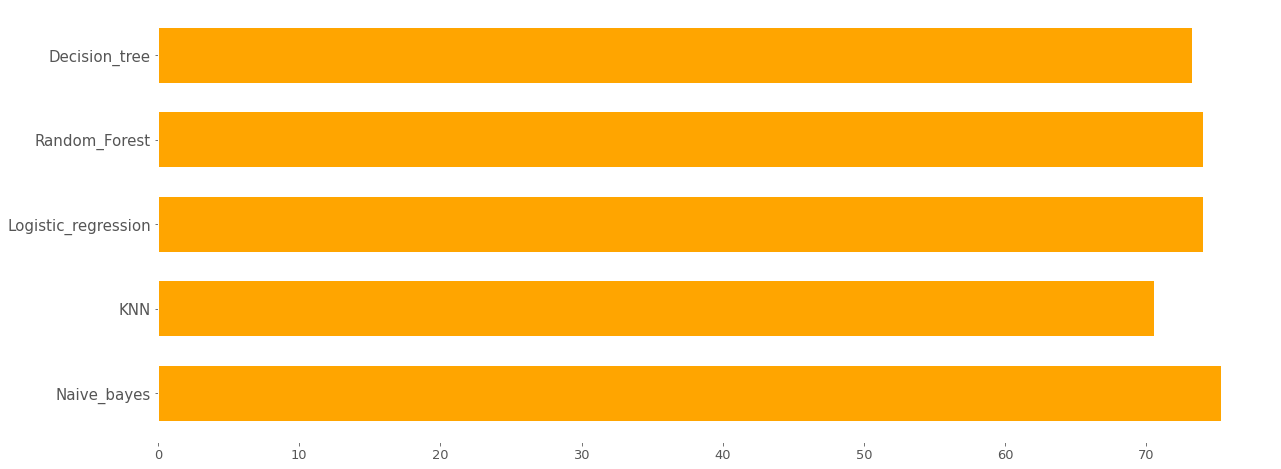

In [239]:
# PLot F1 scores
chart = f1_summary.plot(y ='test_f1_score',
                        kind = 'barh', color ='orange',
                        legend = False, width = 0.65, figsize=(20,8))
chart.set_facecolor('white')
chart.set_ylabel('')
chart.invert_yaxis()
plt.yticks(fontsize=15)
plt.xticks(fontsize=13)
pass

### Random Forest is the winning model

### Hyperparameter Tuning

#### Validation Curves

In [240]:
#Plot validation curve for various parameters to estimate their optimal values
# This will help us narrow down the potential values and therefore reduce running time of Grid search
# Check out current parametrers
print(rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 700, 'n_jobs': None, 'oob_score': False, 'random_state': 30, 'verbose': 0, 'warm_start': False}


In [241]:
# Applying Grid Search to find best parameters for our winning model
from sklearn.model_selection import validation_curve, StratifiedKFold, GridSearchCV

# n_estimators parameter
# Create a list with the range of values for n_estimators
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Obtain train and test scores from validation curve
# Use all data for cross validation - no need to split into train and test sets
train_scores, test_scores = validation_curve(rf, X, y, 
                                             param_name = "n_estimators", 
                                             param_range = n_estimators,
                                             cv = 3, scoring= "f1", 
                                             n_jobs= -1)

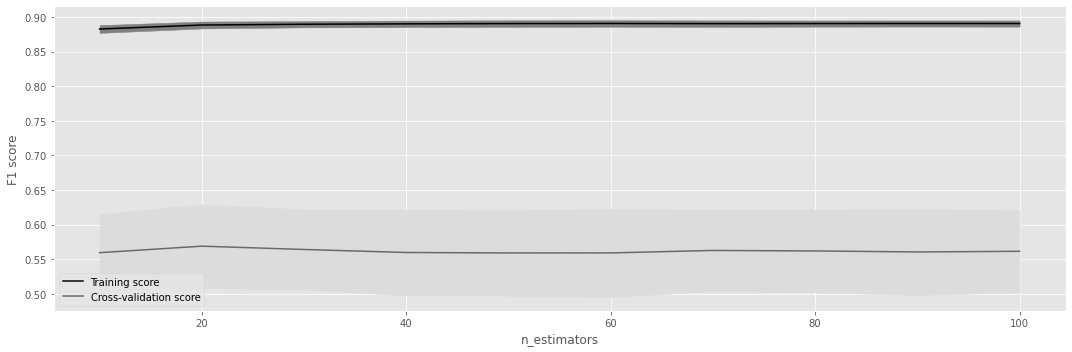

In [242]:
def validation_curve_plot(parameter, values, train_scores, test_scores):
    '''Calculate mean and standard deviation for training set scores'''
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)

    '''Calculate mean and standard deviation for test set scores'''
    test_mean = np.mean(test_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)
    
    '''Plot mean accuracy scores for training and test sets'''
    plt.plot(values, train_mean, label="Training score", color="black")
    plt.plot(values, test_mean, label="Cross-validation score", color="dimgrey")

    '''Plot accurancy bands for training and test sets'''
    plt.fill_between(values, train_mean - train_std, train_mean + train_std, color="gray")
    plt.fill_between(values, test_mean - test_std, test_mean + test_std, color="gainsboro")

    '''Create plot'''
    plt.xlabel(parameter)
    plt.ylabel("F1 score")
    plt.tight_layout()
    plt.legend(loc="best")

# Call function to plot validation curve
validation_curve_plot("n_estimators", n_estimators, train_scores, test_scores)

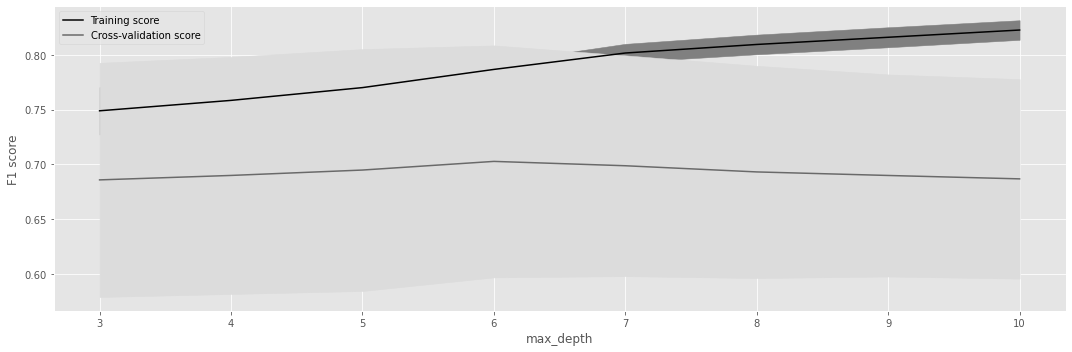

In [243]:
max_depth = [int(x) for x in np.linspace(start = 3, stop = 10, num = 10)]

train_scores, test_scores = validation_curve(rf, X, y, 
                                             param_name = "max_depth", 
                                             param_range = max_depth,
                                             cv = 3, scoring= "f1", 
                                             n_jobs= -1)

validation_curve_plot("max_depth", max_depth, train_scores, test_scores)

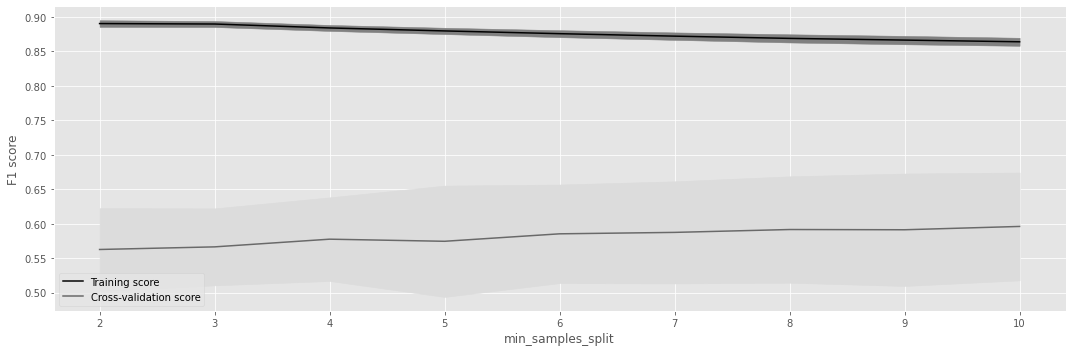

In [244]:
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 10)]

train_scores, test_scores = validation_curve(rf, X, y, 
                                             param_name = "min_samples_split", 
                                             param_range = min_samples_split,
                                             cv = 3, scoring= "f1", 
                                             n_jobs= -1)

validation_curve_plot("min_samples_split", min_samples_split, train_scores, test_scores)

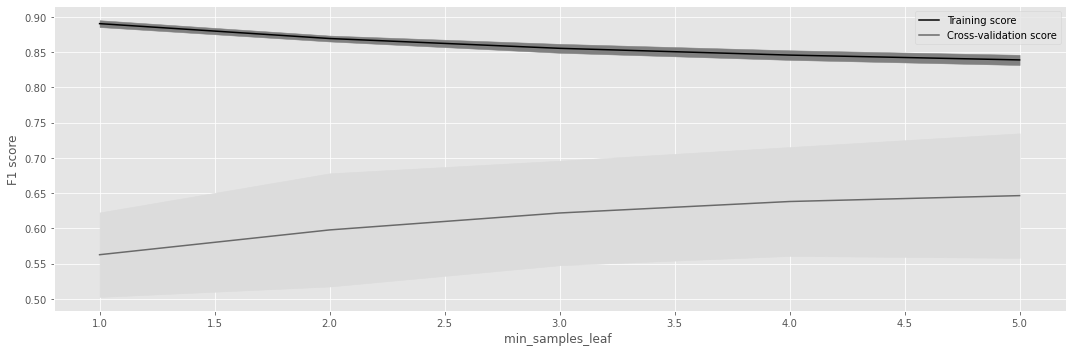

In [245]:
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 5, num = 10)]

train_scores, test_scores = validation_curve(rf, X, y, 
                                             param_name = "min_samples_leaf", 
                                             param_range = min_samples_leaf,
                                             cv = 3, scoring= "f1", 
                                             n_jobs= -1)

validation_curve_plot("min_samples_leaf ", min_samples_leaf, train_scores, test_scores)

#### Grid Search Cross Validation

In [246]:
# Create lists with potential optimal values for each parameter
n_estimators = [20, 40, 100]
max_features = ['auto', 'sqrt']
max_depth = [3, 4]
min_samples_split = [2, 10]
min_samples_leaf = [1, 5]
random_state = [seed]

# Create a dictionary with the range of parameter values
grid = {'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'random_state': random_state}

# Define cross-validation method
cv_method = StratifiedKFold(n_splits = 3, random_state = seed, shuffle = True)

# Intialize Grid Search model
gs = GridSearchCV(estimator = rf, param_grid = grid, cv = cv_method,
                  scoring = 'f1', verbose = 2, n_jobs = -1)

# Train model with data
gs.fit(X, y)

# Print optimal parameter values
print(gs.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
{'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20, 'random_state': 0}


In [247]:
print(gs.best_estimator_)

RandomForestClassifier(max_depth=4, max_features='auto', n_estimators=20,
                       random_state=0)


In [248]:
gs.best_score_

0.7453687596696951

### Model Evaluation

#### Classification Report

In [249]:
# Print the score of the best estimator
best_score = gs.best_score_ * 100
print("Best mean test score: {:.2f}%".format(best_score))

Best mean test score: 74.54%


In [250]:
# Calculate improvement of Grid search model on baseline
baseline = f1_summary.loc['Random_Forest','test_f1_score']
print('Improvement on baseline model of {:0.2f}%'.format(100 * (best_score - baseline) / baseline))

Improvement on baseline model of 0.71%


In [251]:
#Very slight improvement

In [252]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [253]:
#Predicting the test result
y_pred = rf.predict(X_test)

C:\Users\MMT\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [254]:
# Make predictions
gs.pred = gs.best_estimator_.predict(X)
# Print classification report
print(classification_report(y_test, gs.pred))

ValueError: Found input variables with inconsistent numbers of samples: [3622, 12071]

In [ ]:
accuracy = accuracy_score(y_test, gs.pred)

In [ ]:
accuracy

#### Confusion Matrix

In [ ]:
confusion_df= pd.crosstab(y,pd.Series(gs.pred),rownames=['Actual'],colnames=['Pred'])
confusion_df

In [ ]:
# Define elements of confusion matrix for later use in A/B testing
tp = confusion_df.loc[1,1]
tn = confusion_df.loc[0,0]
fp = confusion_df.loc[0,1]
fn = confusion_df.loc[1,0]

In [ ]:
# Plot a heatmap of the confusion matrix
con_mat = confusion_matrix(y, gs.pred)
con_mat

colormap = plt.cm.Wistia
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(con_mat,cmap=colormap,linewidths=0.1,linecolor='white',annot = False, cbar = 0)

ax.set_ylim(2, 0)
ax.set_xlim(2, 0)
ax.set_aspect("equal")
plt.yticks(rotation=0)

# Set y and x label
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Insert text in each cell of matrix
s = [['TN','FP'], 
     ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(con_mat[i][j]), ha="right", va ="top", size='x-large')

In [ ]:
con_mat = confusion_matrix(y, gs.pred)

In [ ]:
con_mat

#### Save the Model

In [ ]:
 import joblib

In [ ]:
#Save model
final_model = gs.best_estimator_ 
filename = 'churn_model_final'
joblib.dump(final_model, filename)

In [ ]:
final_model

### A/B Testing

#### Calculate average revenue per customer for a year

In [ ]:
# Find latest date of sales data
max(trans_data['OrderDate'])

In [ ]:
# Find earliest date of sales data
min(trans_data['OrderDate'])

In [ ]:
# Summarise sales by Order Date
daily_sales = trans_data.groupby('OrderDate').agg({'Revenue':'sum'})
daily_sales.head()

In [ ]:
# Summarise data by monthly sales
monthly_sales = daily_sales.resample('MS').sum()
monthly_sales.head()

In [ ]:
# Plot data
ax = monthly_sales['Revenue'].plot(figsize=(15, 6), color = 'mediumslateblue')
ax.xaxis.set_label_text("")
ax.set_ylim(ymin=0)
pass

In [ ]:
trans_data.tail()

In [ ]:
trans_data['OrderDate'] = pd.to_datetime(trans_data['OrderDate']) 

In [ ]:
#Trans_data = Trans_data.sort_index('OrderDate')

df1 = trans_data[(trans_data['OrderDate'] > '2011-01-01') & (trans_data['OrderDate'] <= '2011-12-31')]
df2 = trans_data[(trans_data['OrderDate'] > '2012-01-01') & (trans_data['OrderDate'] <= '2012-12-31')]
df3 = trans_data[(trans_data['OrderDate'] > '2013-01-01') & (trans_data['OrderDate'] <= '2013-12-31')]
df_list = [df1, df2, df3]
rev_list = []
for df in df_list:
    rev = sum(df.Revenue)
    customer_num = len(df.CustomerID.unique())
    customer_rev = rev / customer_num
    rev_list.append(customer_rev)

In [ ]:
# Calculate average annual revenue per customer
annual_customer_rev = sum(rev_list)/len(rev_list)
annual_customer_rev

In [ ]:
# Let's assume there is a cost per customer
# E.g. a voucher to entice customers could be considered mitigation cost
#mitigation_cost = 350
# Alternatively we could set cost to be 10% of the average annual customer revenue
# mitigation_cost = annual_customer_rev * 0.05
mitigation_cost=annual_customer_rev*0.10
mitigation_cost

In [ ]:
# Calculate profit for baseline and model scenarios
baseline_spend = mitigation_cost * (tp + tn + fp + fn)
baseline_rev = annual_customer_rev * (tp + fn)
baseline_profit = baseline_rev - baseline_spend 

model_spend = mitigation_cost * (tp + fp)
model_rev = annual_customer_rev * tp
model_profit = model_rev - model_spend 

print('If we targeted all customers with an effective mitigation strategy, the profit would be', int(baseline_profit))
print('If we targeted only the predicted churners with an effective mitigation strategy, the profit would be',int(model_profit))
print('This is an improvement of {:0.2f}%'.format((model_profit-baseline_profit)/baseline_profit*100))

In [ ]:
# If we are unsure about mitigation cost, we can determine the best strategy by trying various values
baseline_profit = []
model_profit =[]

for i in range(400):
    baseline_profit.append(baseline_rev - (tp+fp+tn+fn) * i)
    model_profit.append(model_rev - (tp+fp) * i)
    
    
fig = plt.figure()
ax = plt.axes()

x = range(400)
y1 = baseline_profit
y2 = model_profit
ax.plot(x,y1,color='chartreuse', label ='Baseline')
ax.plot(x,y2,color='fuchsia', label ='Model')
ax.legend()
plt.xlabel('Mitigation cost')
plt.ylabel('Profit')
pass

In [ ]:
y1 = np.array(y1)
y2 = np.array(y2)
idx = np.argwhere(np.diff(np.sign(y1 - y2))).flatten()
int(idx)

In [ ]:
print('Our model is superior to the baseline scenario when the mitigation cost exceeds',int(idx),'dollars per customer')

#### Maximum return

In [ ]:
# Goal: Maximum return on investment; our metric in this case is precision
# Calculate baseline and model return
baseline_return = (baseline_rev - baseline_spend) / baseline_spend *100
model_return = (model_rev - model_spend) / model_spend *100

In [ ]:
print('If we targeted all customers with an effective mitigation strategy, the return on investment would be {:0.2f}%'.format(baseline_return))
print('If we targeted only the predicted churners with an effective mitigation strategy, the return on investment would be {:0.2f}%'.format(model_return))

In [ ]:
# If we are unsure about mitigation cost, we can determine the best strategy by trying various values
baseline_return = []
model_return =[]

for i in range(1,400):
    baseline_return.append((baseline_rev - (tp+fp+tn+fn) * i)/ ((tp+fp+tn+fn) * i) * 100)
    model_return.append((model_rev - (tp+fp) * i)/ ((tp+fp) * i) * 100)
    
fig = plt.figure()
ax = plt.axes()

x = range(1,400)
y1 = baseline_return
y2 = model_return
ax.plot(x,y1,color='chartreuse', label ='Baseline')
ax.plot(x,y2,color='fuchsia', label ='Model')
ax.legend()
plt.xlabel('Mitigation cost')
plt.ylabel('Return %')
pass

In [ ]:
print('Our model would give better return on investment compared to the baseline scenario regardless of the mitigation cost')

In [ ]:
# If our goal is to optimise both maximum profit and maximum return, our metric is F1 score

### Data Scoring

In [ ]:
score_data.head().transpose()

In [ ]:
score_data.info()

In [ ]:
#Double check for missing values and duplicates
score_data.isnull().sum()[score_data.isnull().sum()!=0]

In [ ]:
#Check for potential duplicate rows
print('Number of duplicates:', score_data.duplicated().sum())

In [ ]:
#Delete fields that are of no use for our modelling
#Exclude Customer_id from deleted list so we can idetify churning customers later on
col_.remove('CustomerID')
col_ = col_ + ['churn']
score_data.drop(col_, axis = 1, inplace= True)

In [ ]:
for var in cat:
 print(score_data[var].value_counts())

In [ ]:
#PLot distribution/frequency per category
cat_df = score_data[cat]
plt.rcParams['figure.figsize'] = (15, 5) # Chart sizes

for i, col in enumerate(cat_df.columns):
   plt.figure(i)
   sns.countplot(x=col, data=cat_df, color = 'mediumslateblue')

In [ ]:
#Encode categorical data (besides drivers which are already binary)
encoded_score_data = pd.get_dummies(score_data, columns = [v for v in dummies], drop_first = False)

In [ ]:
encoded_score_var = list(encoded_score_data.columns)
encoded_score_var 

In [ ]:
#Filter continuous variables
cont = [v for v in cols if v not in cat and v not in col_  and v != 'CustomerID']

In [ ]:
#Get quick stats
encoded_score_data[cont].describe().transpose()

In [ ]:
# Plot boxplots
encoded_score_data[cont].plot(kind='box', subplots=True, figsize=(20,40),
                      layout=(9,4), sharex=False, sharey=False)
plt.show()

In [ ]:
# PLot histograms
encoded_score_data[cont].hist(figsize=(20,40), color = 'mediumslateblue')
pass

In [ ]:
# Check if all encoded features of model dataset are included in score dataset
result = all(v in encoded_score_var for v in final_features)
if result:
    print('All encoded features of model dataset are included in score dataset.')
else:
    print('Not all encoded features of model dataset are included in score dataset.')

In [ ]:
# Find which encoded features are not present in score dataset
missing_var = set(final_features) - set(encoded_score_var)
missing_var

In [ ]:
# Create missing fields and assign 0 to all rows
for v in missing_var:
    encoded_score_data[v] = 0

In [ ]:
# Create the final score dataframe with all selected features and Customer id
score_df = encoded_score_data[final_features]
score_df.insert(0, 'CustomerID', encoded_score_data['CustomerID'])
score_df.head()

### Model Deployment

In [ ]:
loaded_model = joblib.load('churn_model_final')
loaded_model

In [ ]:
# Make predictions
features = score_df.loc[:, score_df.columns != 'CustomerID']
predictions = loaded_model.predict(features)
# Add a new column to the dataframe with the predictions
score_df.insert(1, "churn", predictions, True)
score_df.head()

In [ ]:
# Show how many customers are predicted to churn (1) and not to churn (0)
score_df.groupby('churn').size()

In [ ]:
# Filter potential churners
predicted_churners = score_df[score_df['churn'] == 1]

In [ ]:
predicted_churners.head()

In [ ]:
filename = 'Predicted churners.csv'
csv_file = predicted_churners.to_csv(filename, index = None, header = True)

### Profile of Predicted Churners vs Non-Churners

In [ ]:
predicted_churners.head()

In [ ]:
# Select CustomerID, churn
pred=predicted_churners[["CustomerID", "churn"]]
pred.head()

In [ ]:
rfmTable.head()

In [ ]:
# Select CustomerID and RFM_cluster from the rfm table
rf1=rfmTable[["CustomerID", "RFM_Cluster"]]
rf1.head()

In [ ]:
# Select gender, Maritial status, Total number of children, Education, Occupation, Age group, Income group, House Owner
Dems=demo_data[["CustomerID","MaritalStatus","Gender","TotalChildren","NumberChildrenAtHome","Occupation","Education","NumberCarsOwned","Age_group","income_group","HouseOwner"]]
Dems.head()

In [ ]:
#Join Pred, rf1 and Dems tables

In [ ]:
Chd=pd.merge(pred, rf1, on="CustomerID")

In [ ]:
Chd=pd.merge(Chd, Dems, on="CustomerID" )

In [ ]:
Chd.head()

#### Profile Visualization

In [ ]:
# count plot showing predicted churn and nonchurn
sns.countplot(x = 'churn',  data =score_df, palette = 'magma')
plt.title('churn distribution')
plt.show()

In [ ]:
# count plot showing predicted churners by gender
Chd_gender=Chd[['churn', 'Gender']]
sns.countplot(x='Gender', data = Chd_gender)
plt.yticks(size=20)
plt.xticks(size=20)
plt.title('Churn distribution by Gender', fontsize = 20)
plt.show()

In [ ]:
Chd_Marital=Chd[['churn', 'MaritalStatus']]
sns.countplot(x='MaritalStatus', data = Chd_Marital)
plt.yticks(size=20)
plt.xticks(size=20)
plt.title('Churn distribution by Marital Status', fontsize = 20)
plt.show()

In [ ]:
Chd_CarOwners=Chd[['churn', 'NumberCarsOwned']]
sns.countplot(x='NumberCarsOwned', data = Chd_CarOwners)
plt.yticks(size=20)
plt.xticks(size=20)
plt.title('Churn distribution by CarOwners', fontsize = 20)
plt.show()

In [ ]:
Chd_NumberChildrenAtHome=Chd[['churn', 'NumberChildrenAtHome']]
sns.countplot(x='NumberChildrenAtHome', data = Chd_NumberChildrenAtHome)
plt.yticks(size=20)
plt.xticks(size=20)
plt.title('Churn distribution by NumberChildrenAtHome', fontsize = 20)
plt.show()

In [ ]:
Chd_income_group=Chd[['churn', 'income_group']]
sns.countplot(x='income_group', data = Chd_income_group)
plt.yticks(size=20)
plt.xticks(size=20)
plt.title('Churn distribution by income_group', fontsize = 20)
plt.show()

In [ ]:
Chd_RFMcluster=Chd[['churn', 'RFM_Cluster']]
sns.countplot(x='RFM_Cluster', data =Chd_RFMcluster)
plt.yticks(size=20)
plt.xticks(size=20)
plt.title('Churn distribution by RFM Clusters',fontsize = 20)
plt.show()

In [ ]:
Chd_Occupation=Chd[['churn', 'Occupation']]
sns.countplot(x='Occupation', data =Chd_Occupation)
plt.title('Churn distribution by Occupation')
plt.show()

In [ ]:
Chd_Education=Chd[['churn', 'Education']]
sns.countplot(x='Education', data =Chd_Education)
plt.title('Churn distribution by Education ')
plt.show()

### Customer Profiling

#### Descriptive statistics

In [ ]:
# What's the profile of the churners? How do they differ from non churners?
# Plot boxplots by Churn
plt.rcParams['figure.figsize'] = (7, 5)
cont_df = select_data[cont]
for i, col in enumerate(cont_df .columns):
   plt.figure(i)
   sns.boxplot(data = cont_df, y = col , x = select_data['churn'])